Spectral Variable selection

As previously discussed, spectroscopy data usually includes confounding
variables, i.e., wavelengths that are not relevant for the predicting the
output of interest. These can interfere with the modelling procedure. 

This is why variable (wave) selection is included in the pipeline.

Moreover, spectral variable selection is particularly useful for the
purpose of simplifyin the spectroscopy acquisition tool.

We will call the variables selected 'windows'

In [1]:
# Import Libraries and Load Data

import pandas as pd

folder = 'NO Dataset'

# Load datasets from pickle files
monitordata = pd.read_pickle(folder + '/monitordata.pkl')
fluorodata = pd.read_pickle(folder + '/fluorodata.pkl')
absdata = pd.read_pickle(folder + '/absdata.pkl')

#---------------------------------------------------------------------------
# Identify index columns (metadata, sample information)
IDCOLUMNS_COUNT = 14
sampleinfo = list(monitordata.columns[:IDCOLUMNS_COUNT])

# Collect names for outputs (monitoring vars) and inputs (spectral data)
monitor_vars = list(monitordata.columns[IDCOLUMNS_COUNT:])   # e.g., Vx, CC, CytoNR...
abswaves = list(absdata.columns[IDCOLUMNS_COUNT:])
fluorowaves = list(fluorodata.columns[IDCOLUMNS_COUNT:])

# Set sample info columns as multi-index for all datasets
monitordata = monitordata.set_index(sampleinfo)
absdata = absdata.set_index(sampleinfo)
fluorodata = fluorodata.set_index(sampleinfo)



Here we will show a specific kind of wavelength selection: moving-window.

In the case of 2D-fluorescence, we will have a sliding rectangle selecting the wavelenghts, while in the case of absorbance we will have just a sliding line

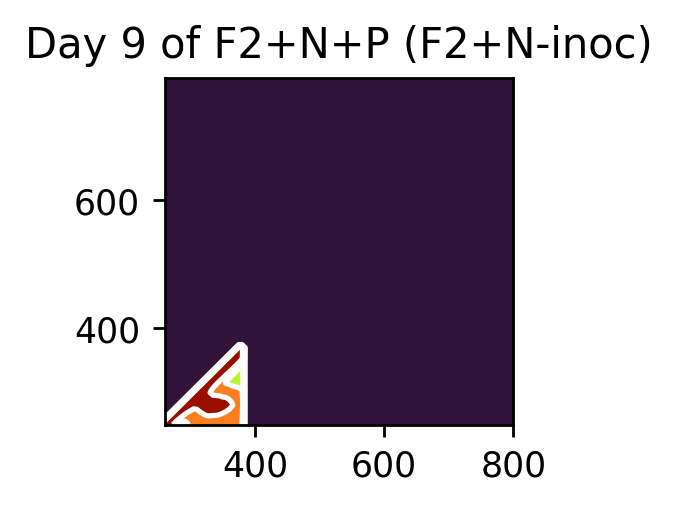

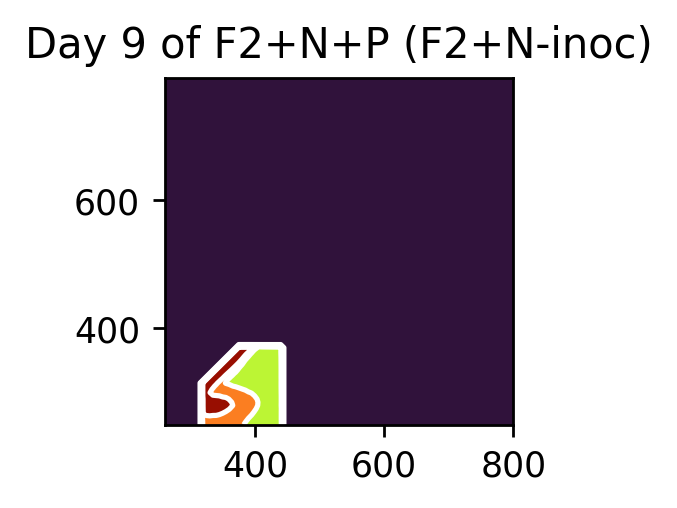

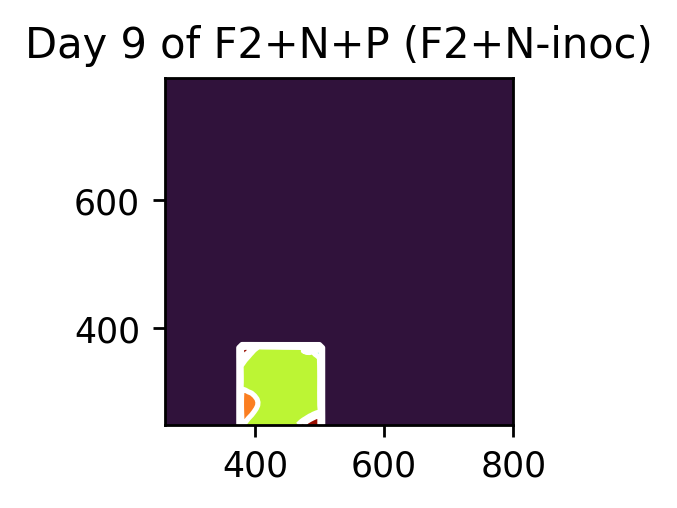

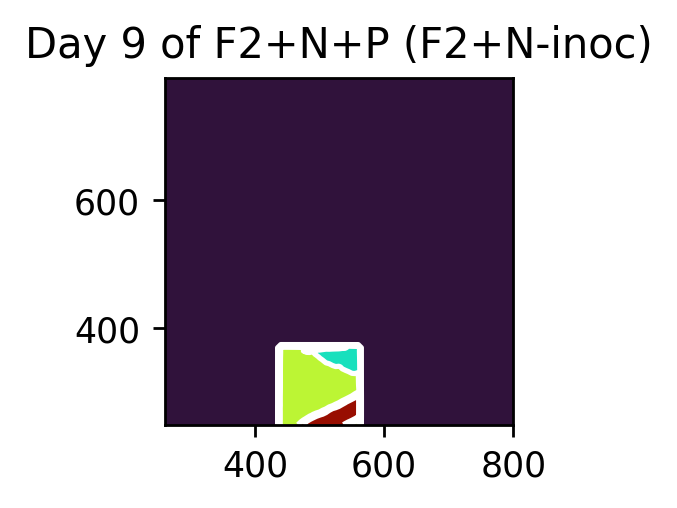

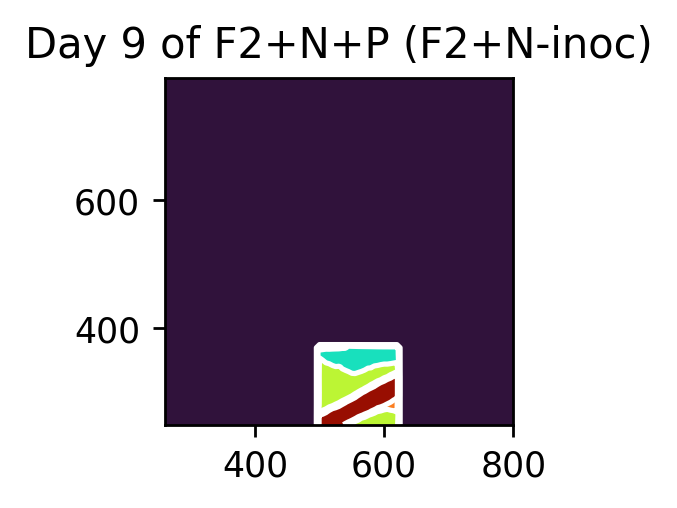

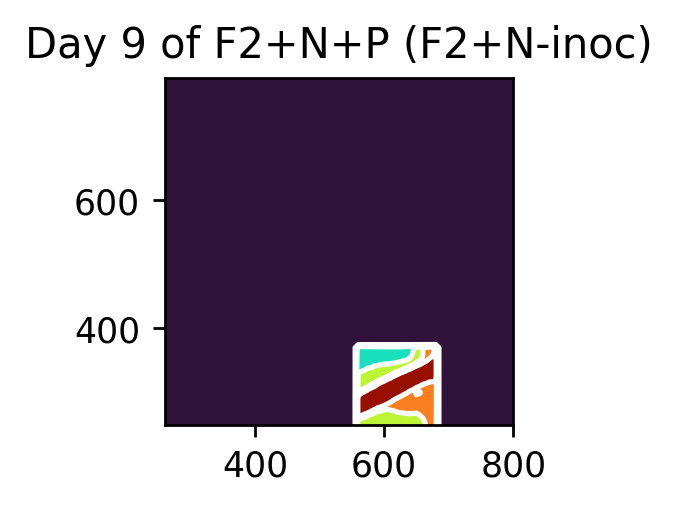

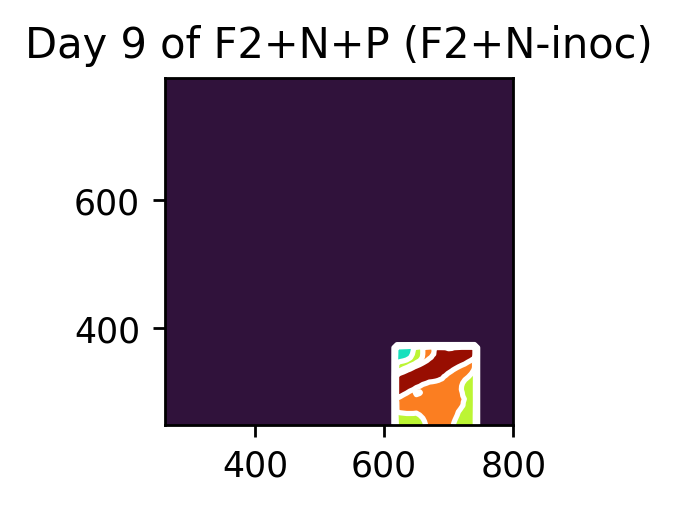

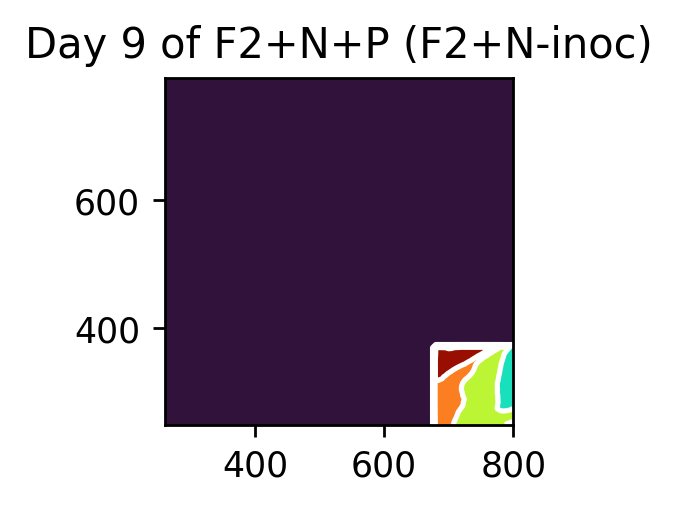

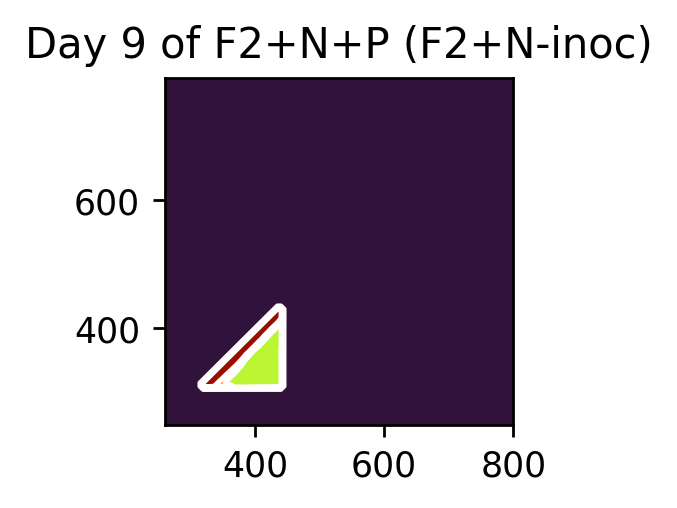

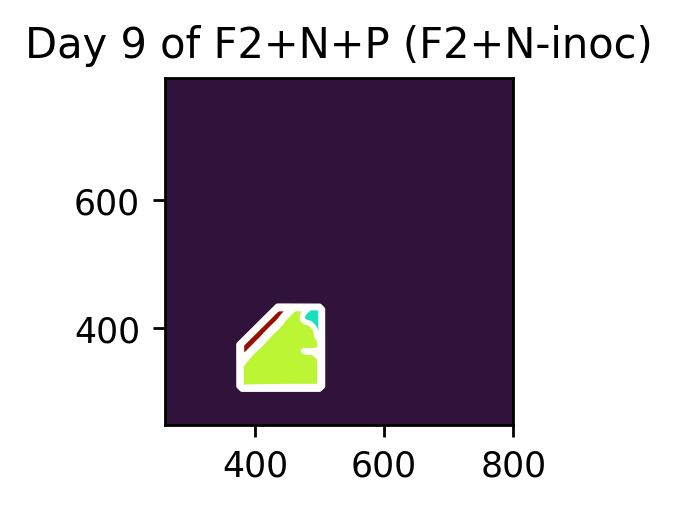

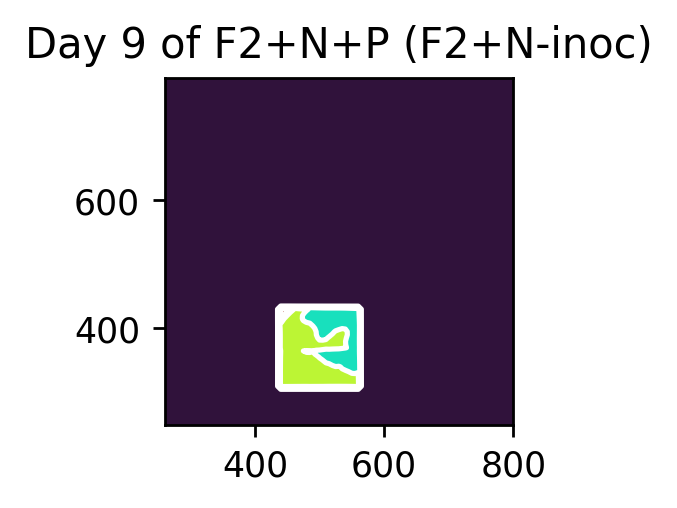

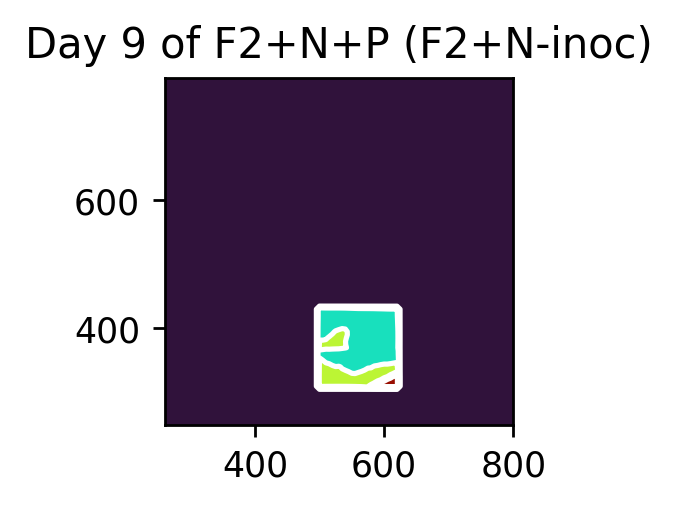

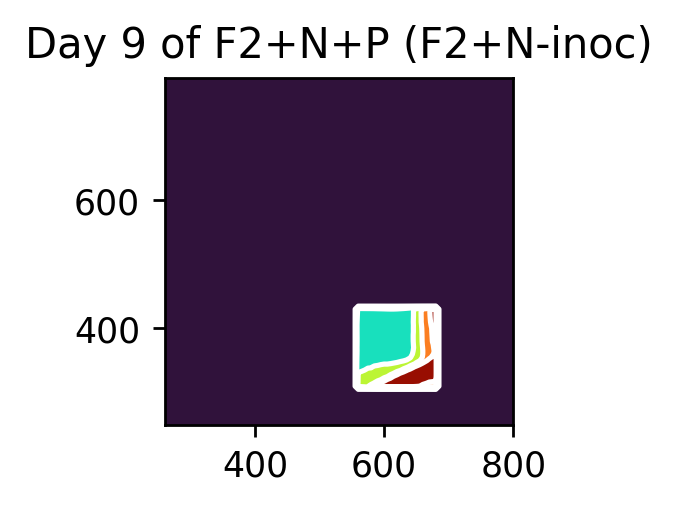

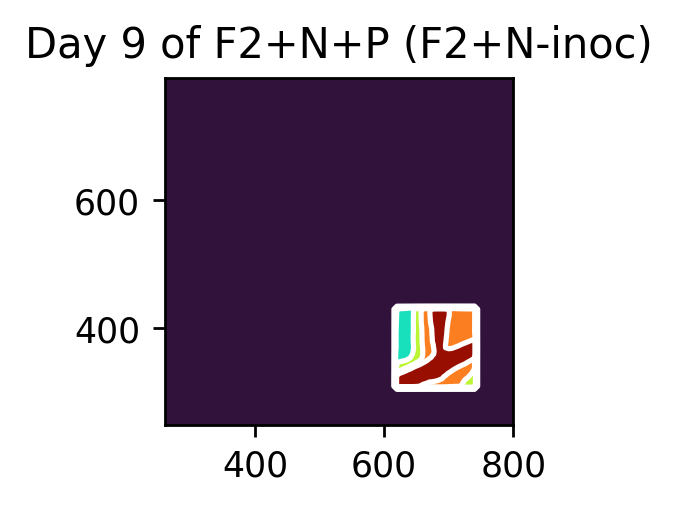

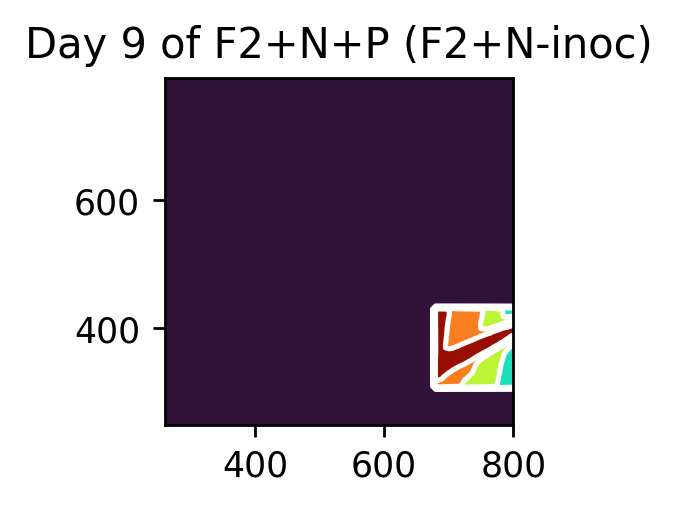

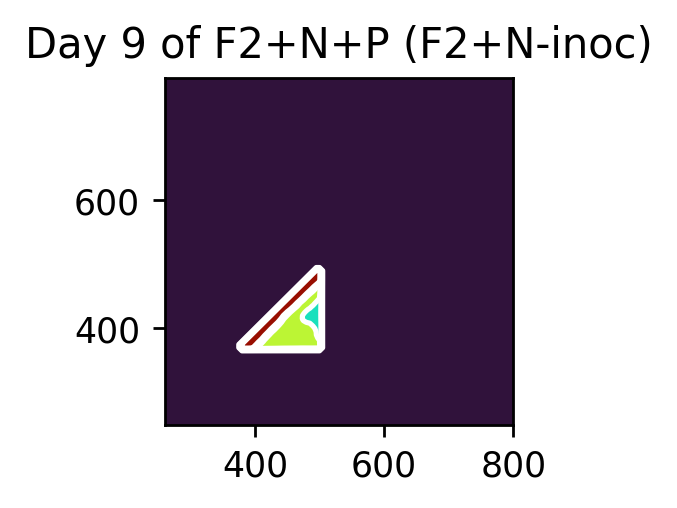

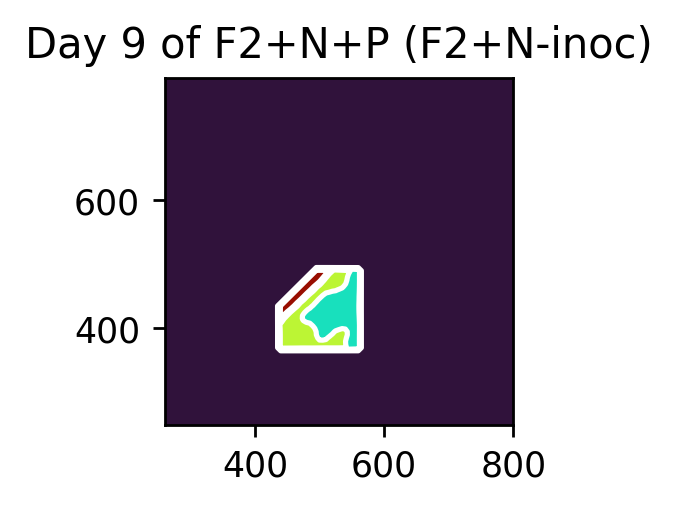

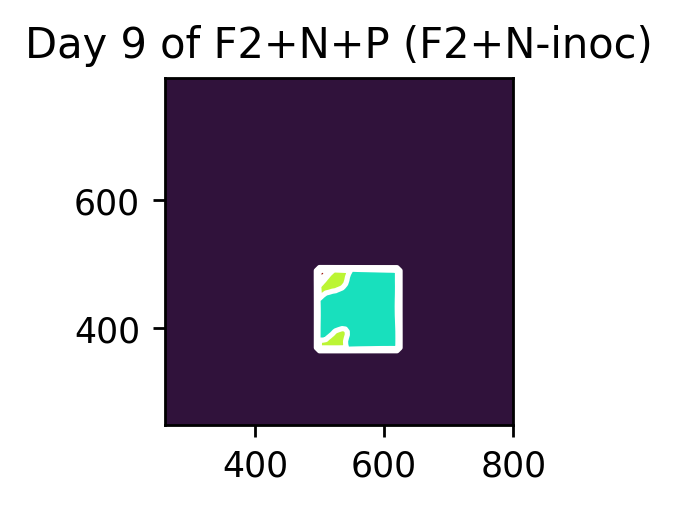

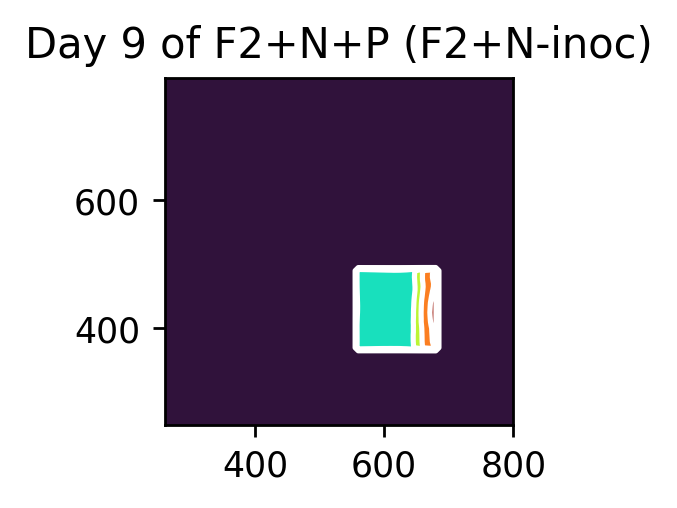

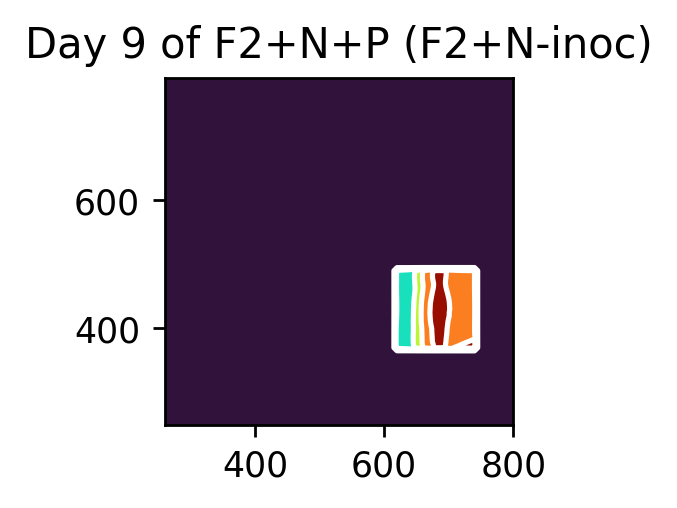

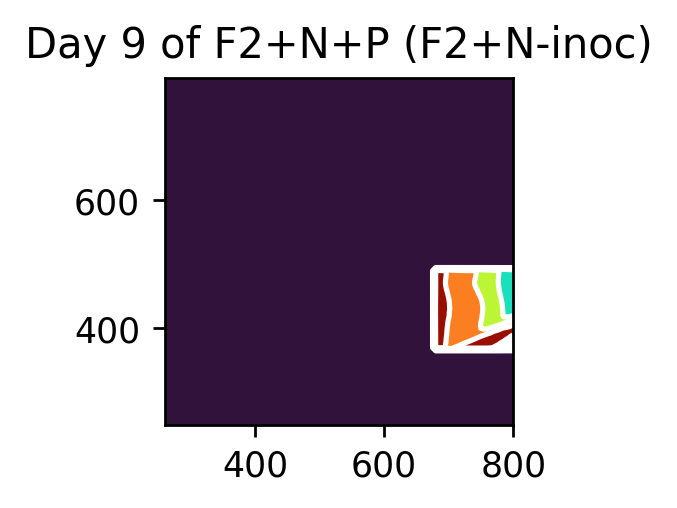

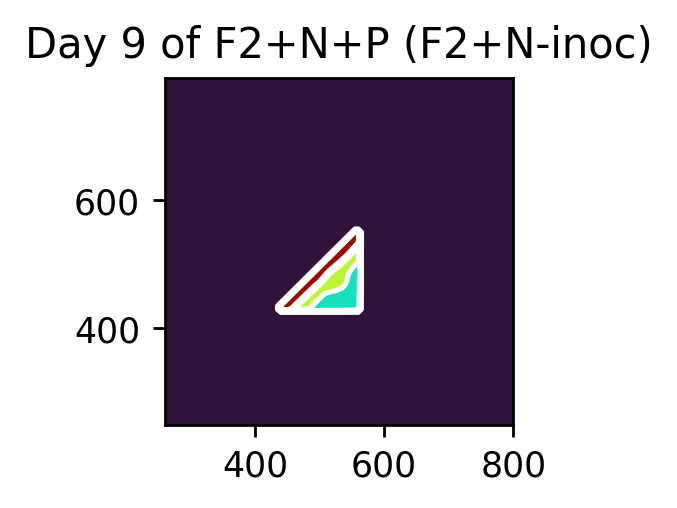

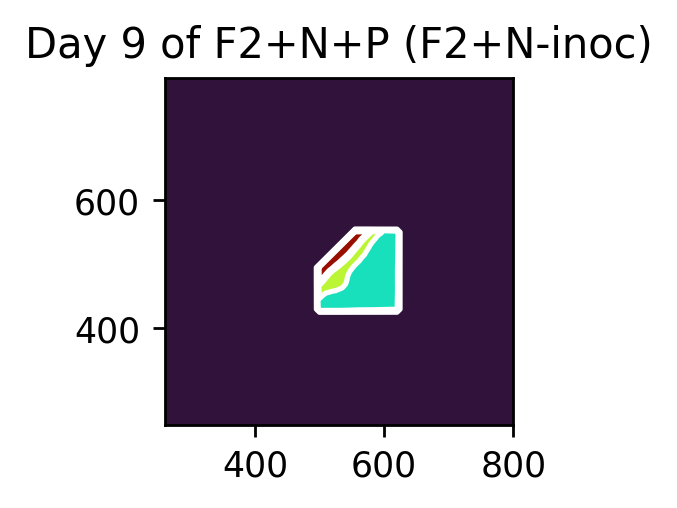

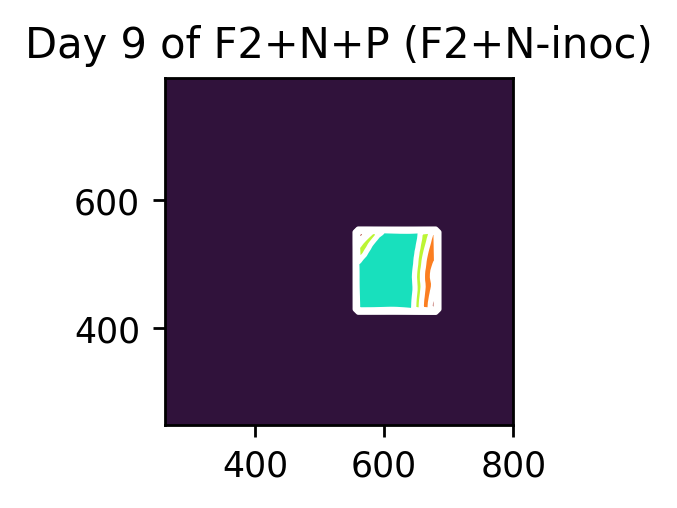

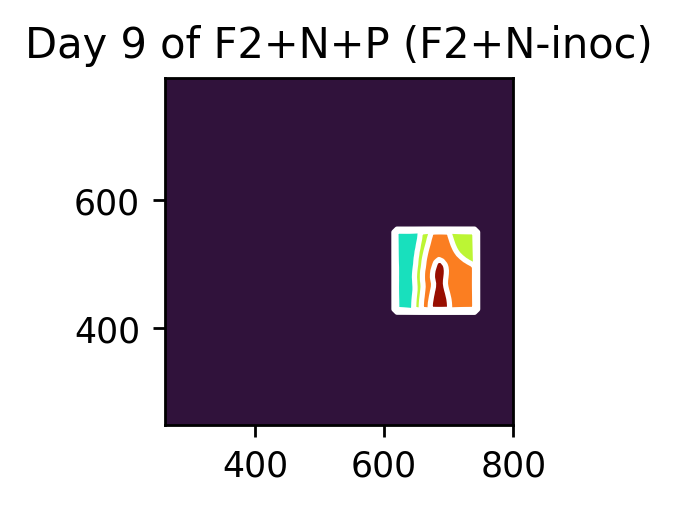

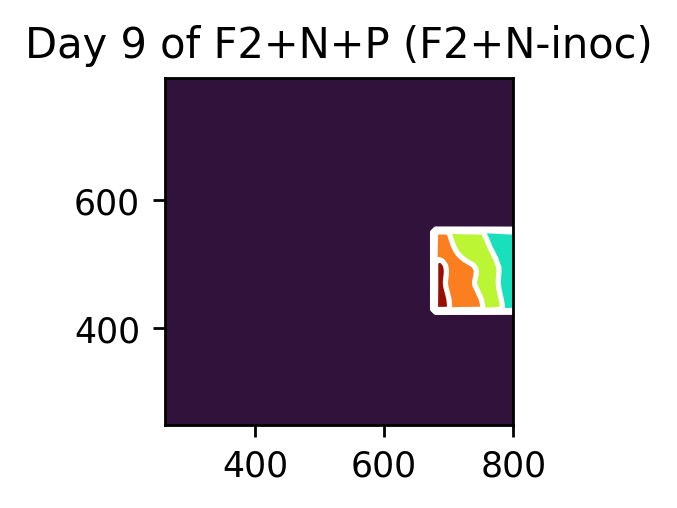

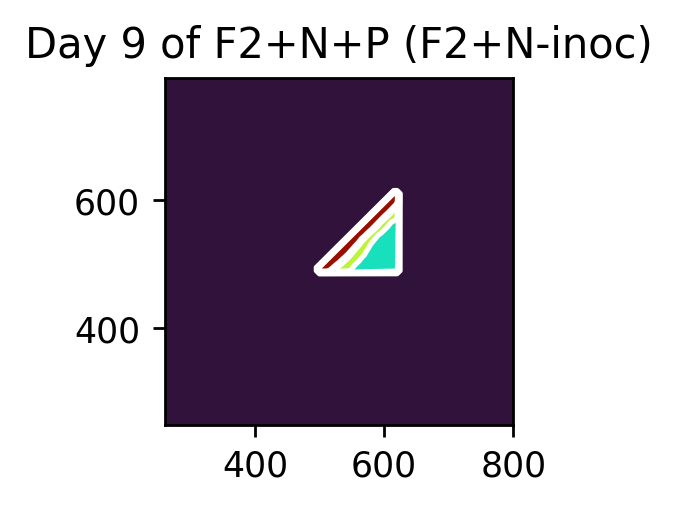

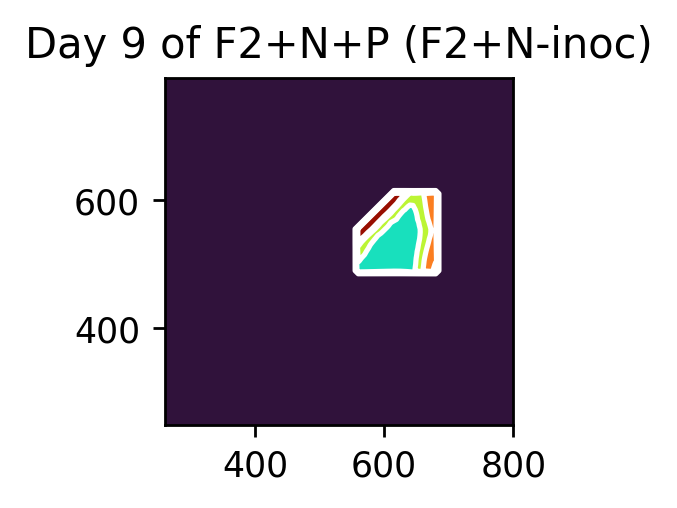

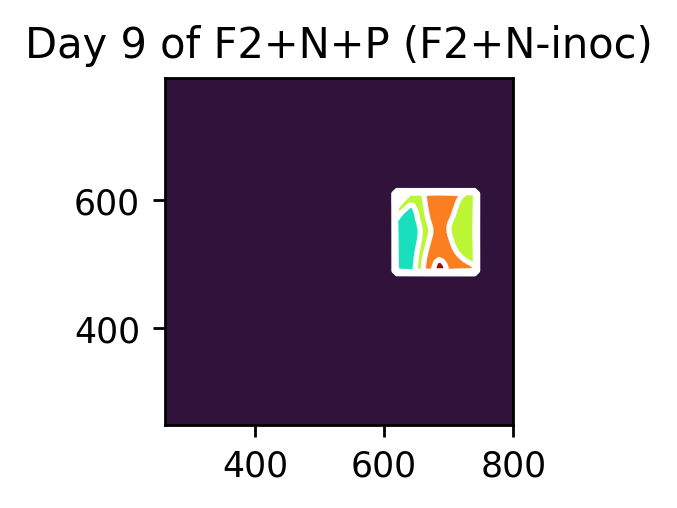

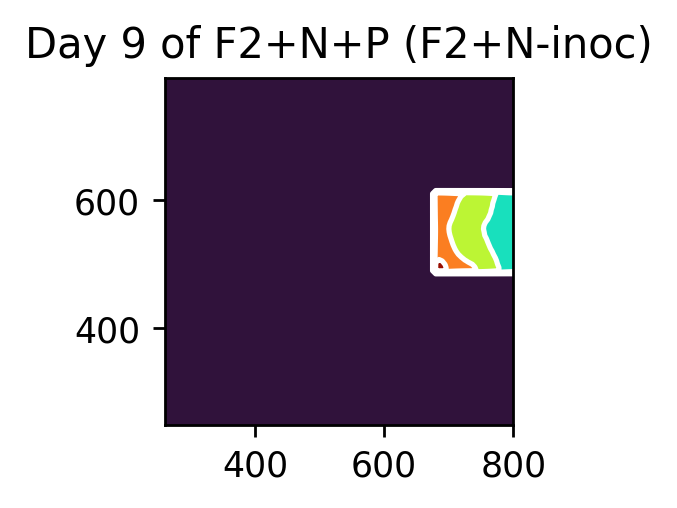

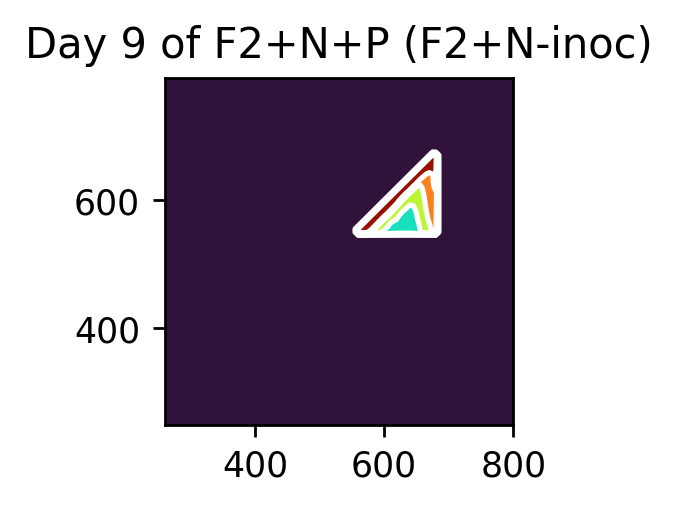

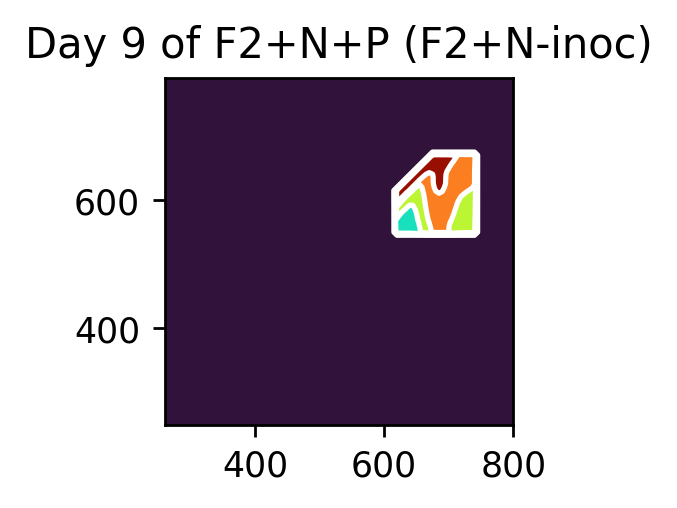

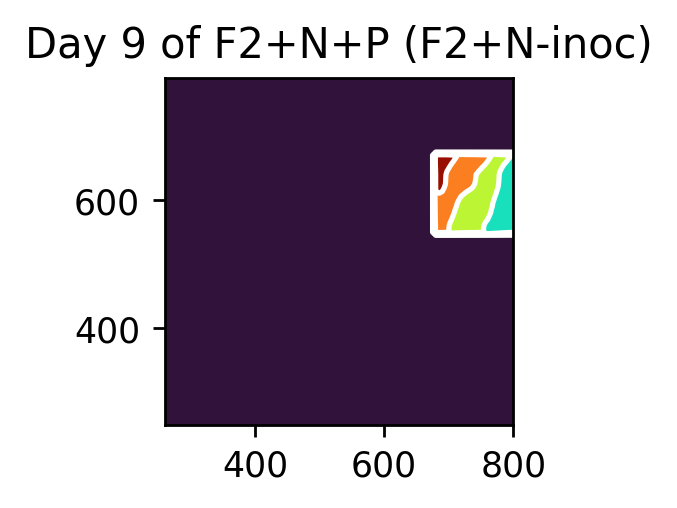

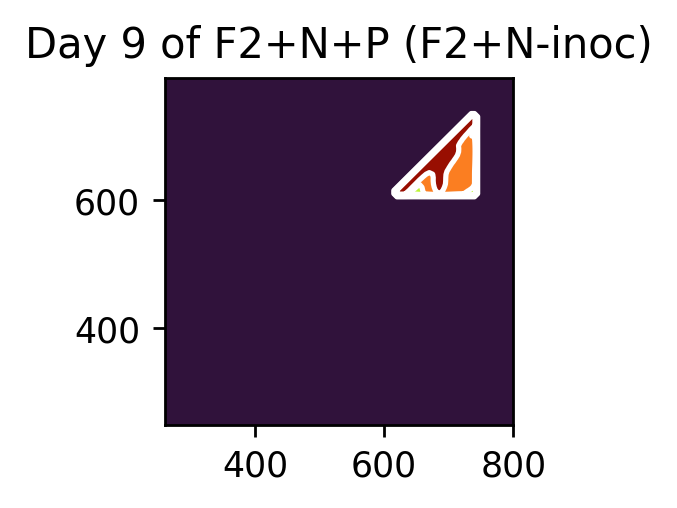

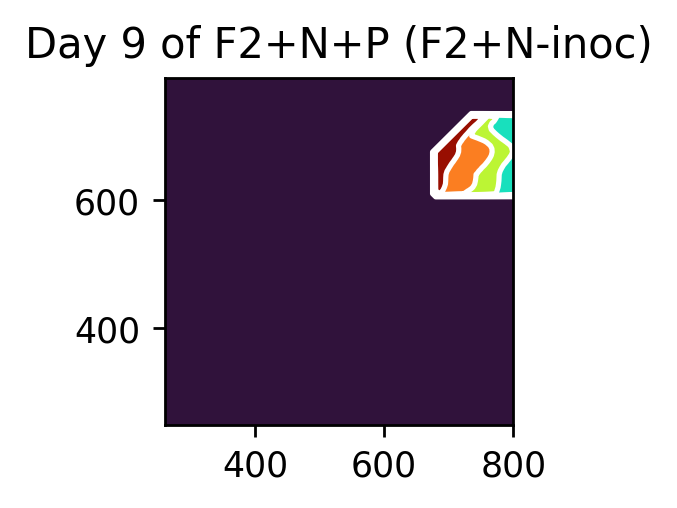

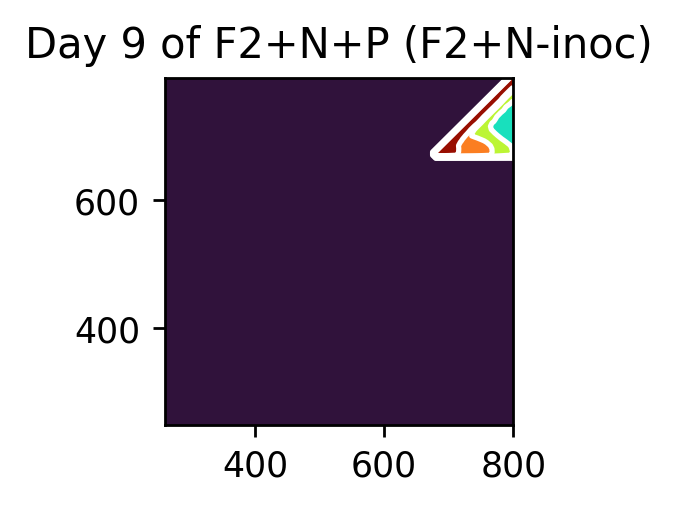

In [5]:
# Display Wavelength Selection: Moving-windows

# Import the wavelenght selection functions
from variable_selection import waveRestrictor2,fluoro1Dgen,EEM_squaredwindowgenerator
from spectrum_plotter import plot_meanpartialspectrum


# Build a function to allow us to store window selection in a dictionary 'window_dict'
window_dict = {}
counter = {}
def add_windows(windows, prefix):
    """
    Add a list of windows to window_dict with a prefix 
    and incremented index.
    
    """
    if prefix not in counter:
        counter[prefix] = 1
    for win in windows:
        key = f"{prefix}{counter[prefix]}"
        window_dict[key] = win
        counter[prefix] += 1

# Get a list of windows sliding 1 window
w1 = EEM_squaredwindowgenerator(size=25, overlap=0.5, numberofwindows=1, desired_length=50)
add_windows(w1, "MW1_")

# Specify the samples for visualization
assays = ['F2+N+P (F2+N-inoc)']
days = [9]

for window in window_dict.keys():
    
    # Pre-process pipeline with just a step of variable selection
    varsel = waveRestrictor2(window_dict = window_dict, window = window)

    
    X_transf = varsel.fit_transform(fluorodata)
    plot_meanpartialspectrum(fluorodata, X_transf,days,assays,sampleinfo,
                             contours = 1,
                             log=1)
    


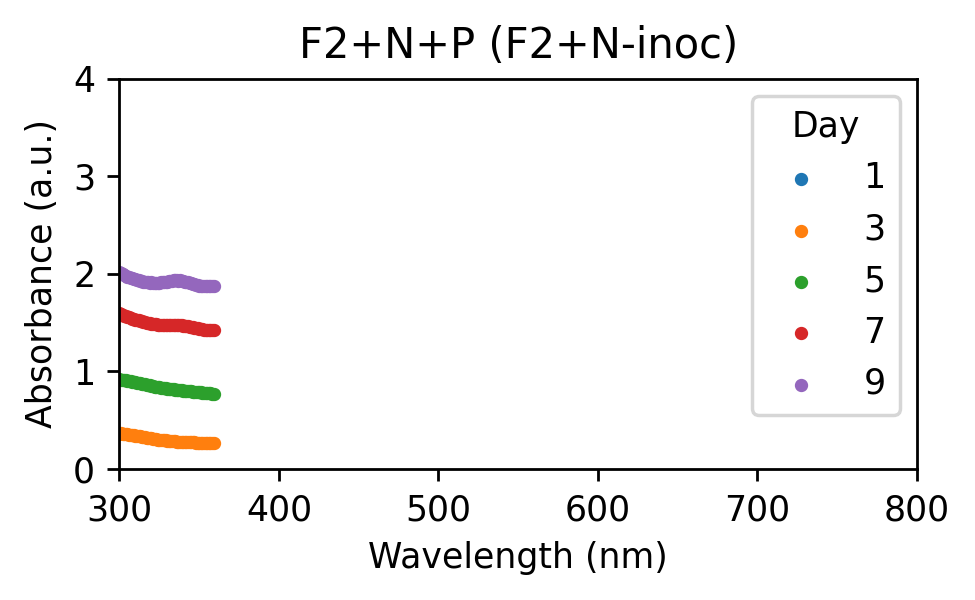

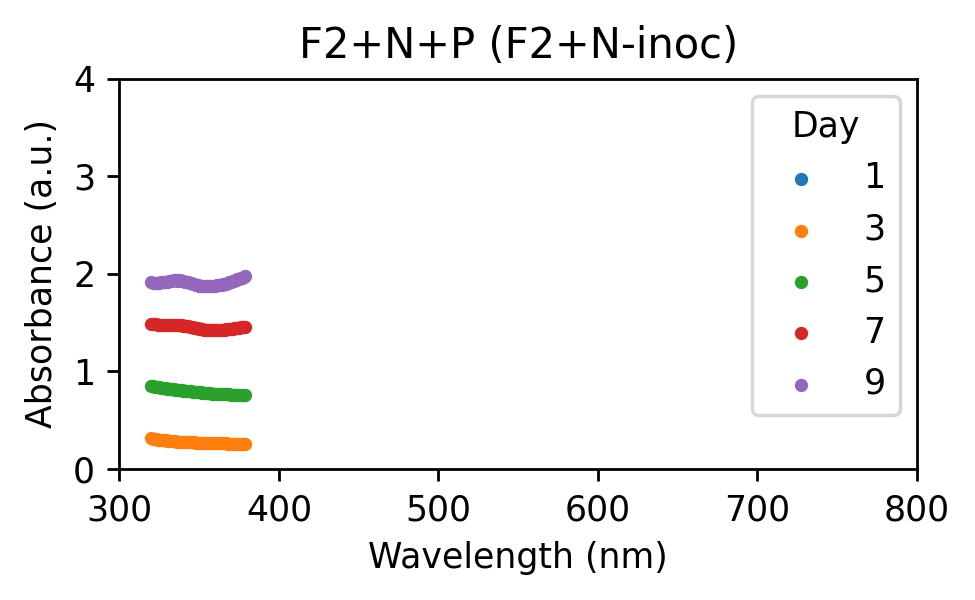

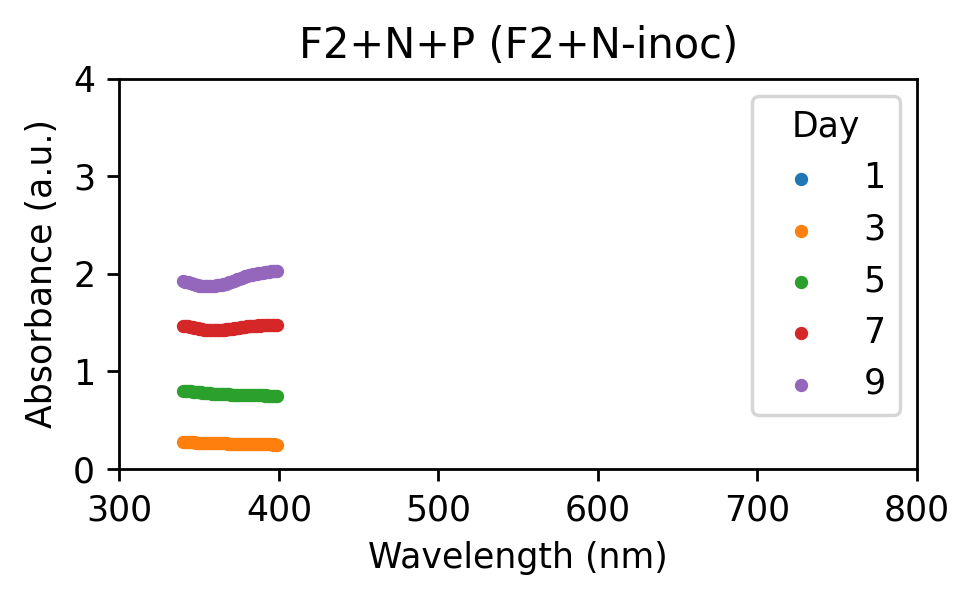

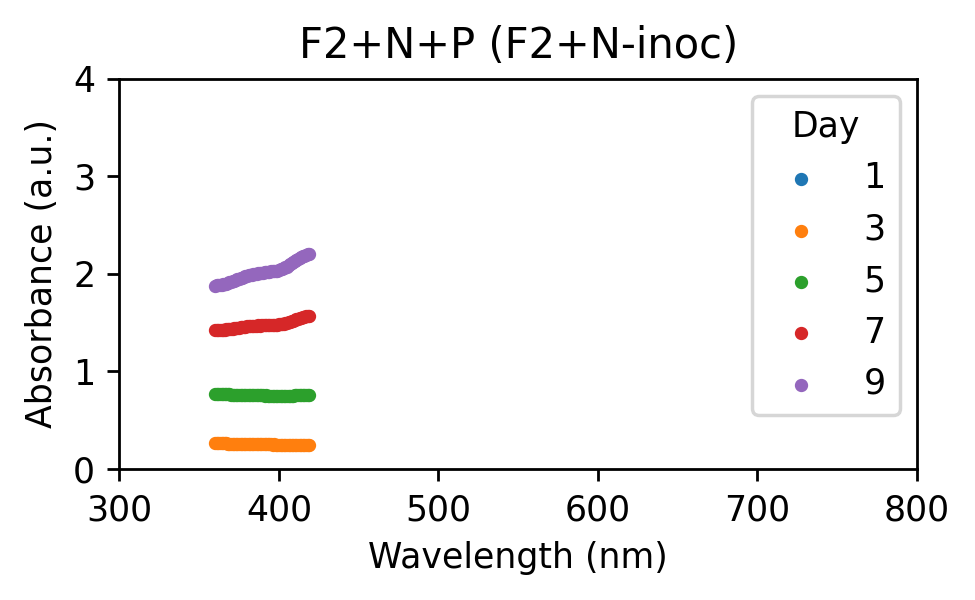

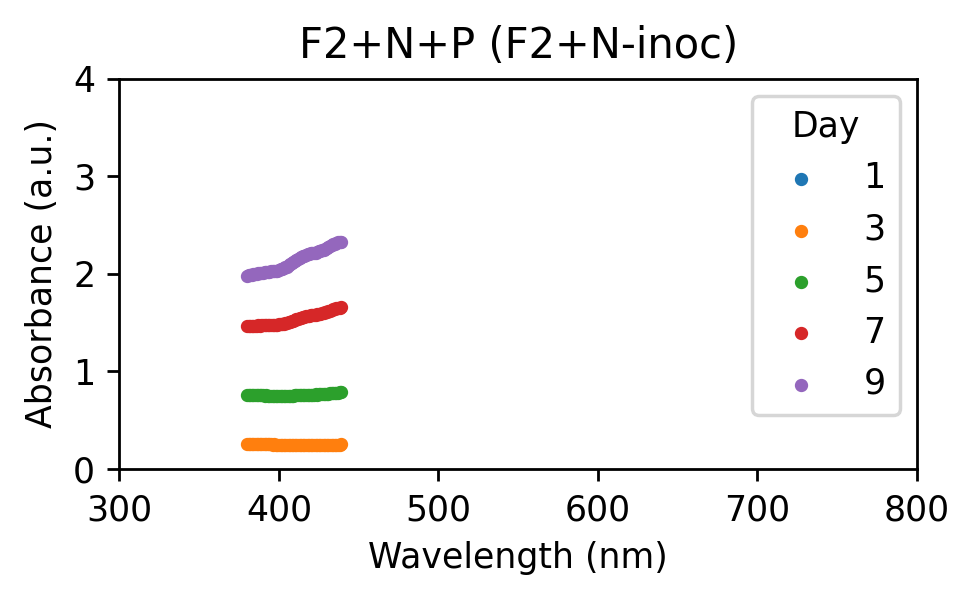

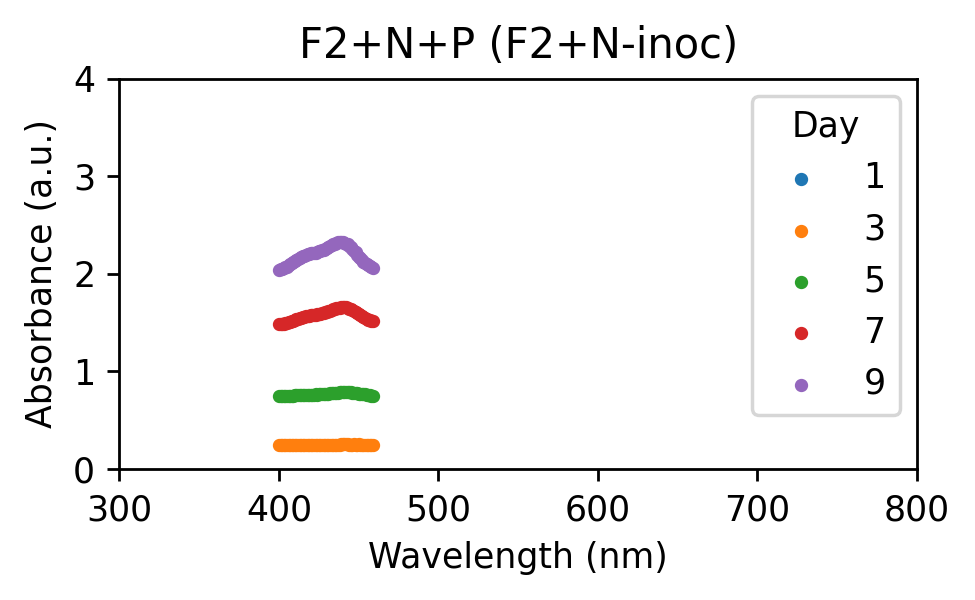

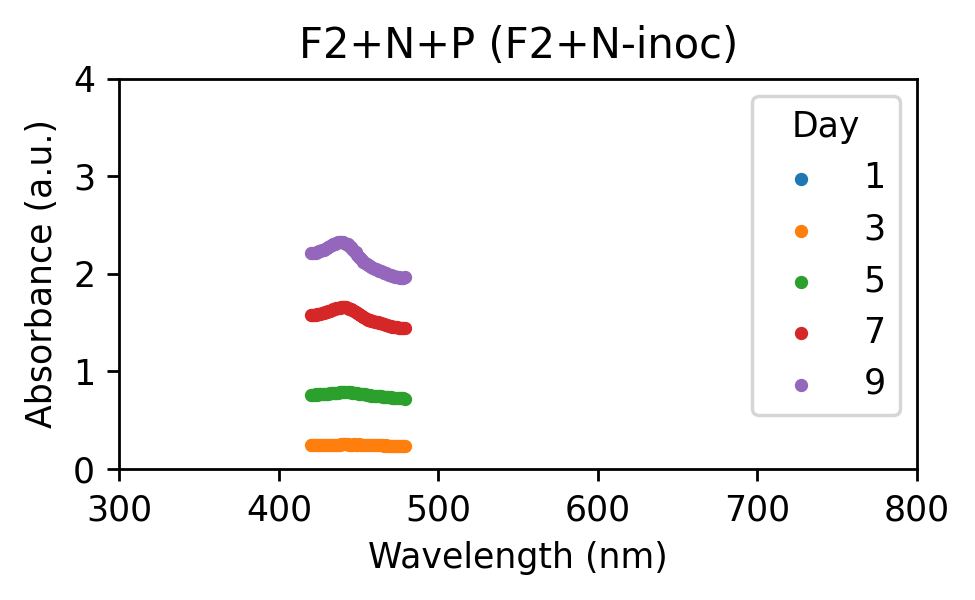

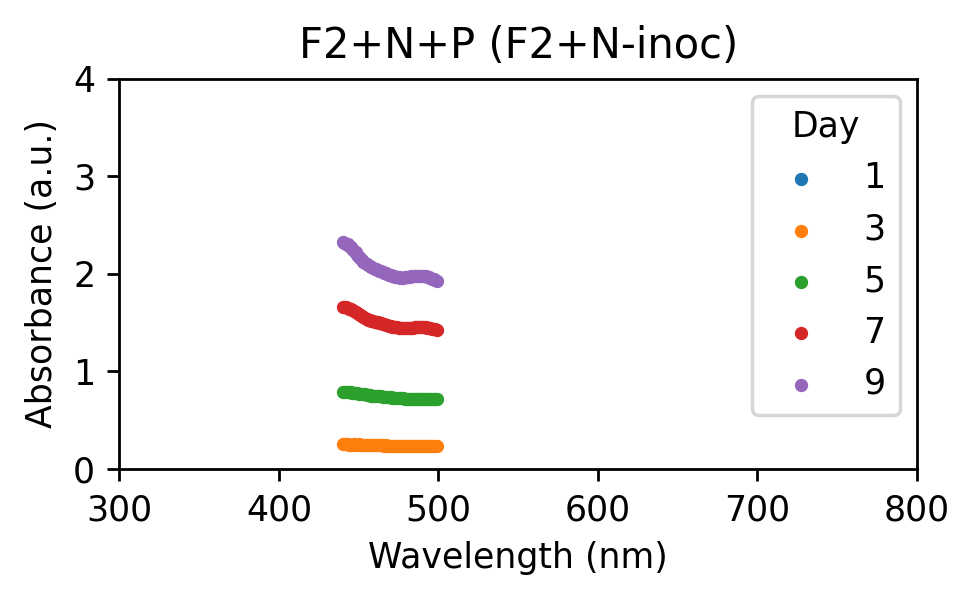

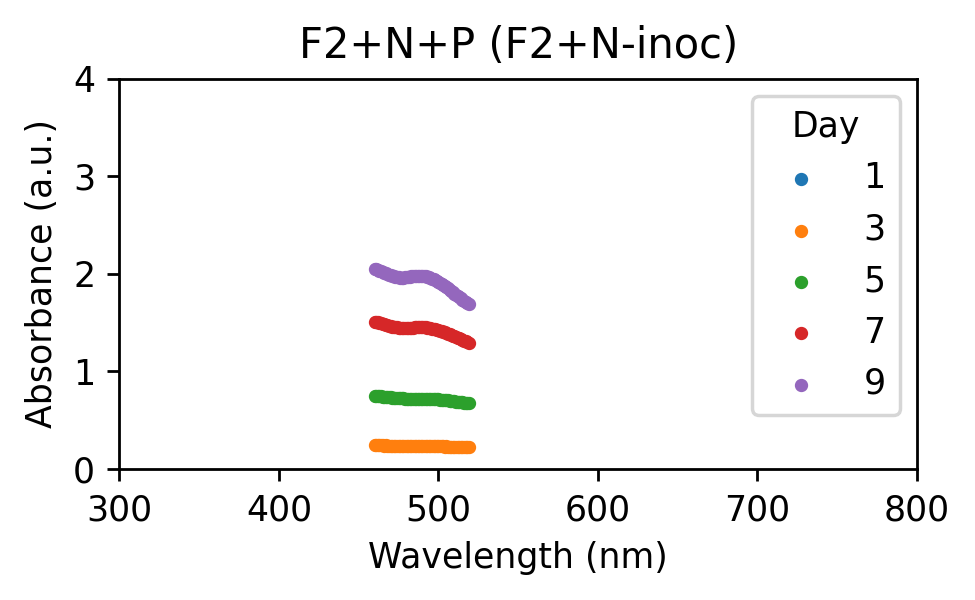

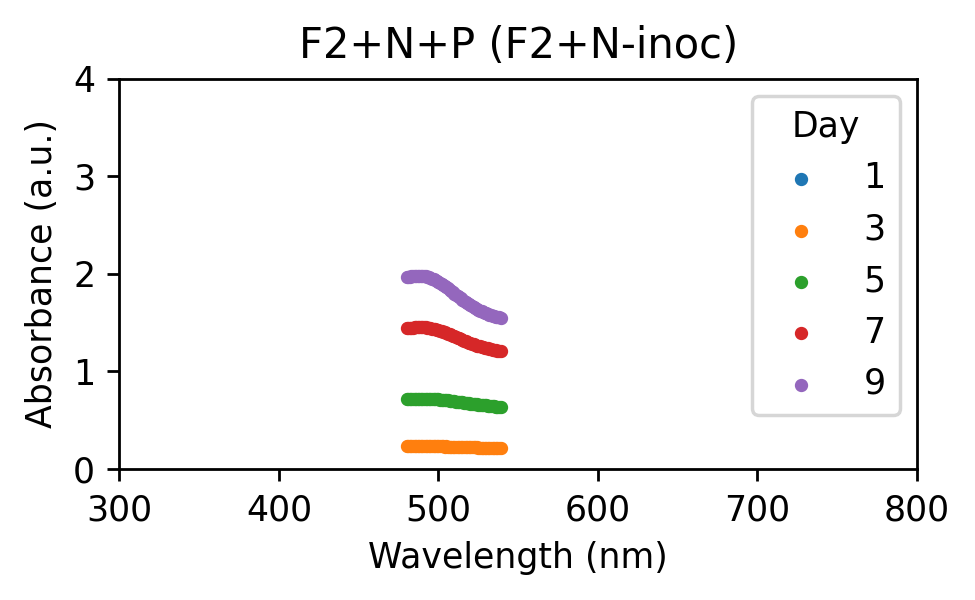

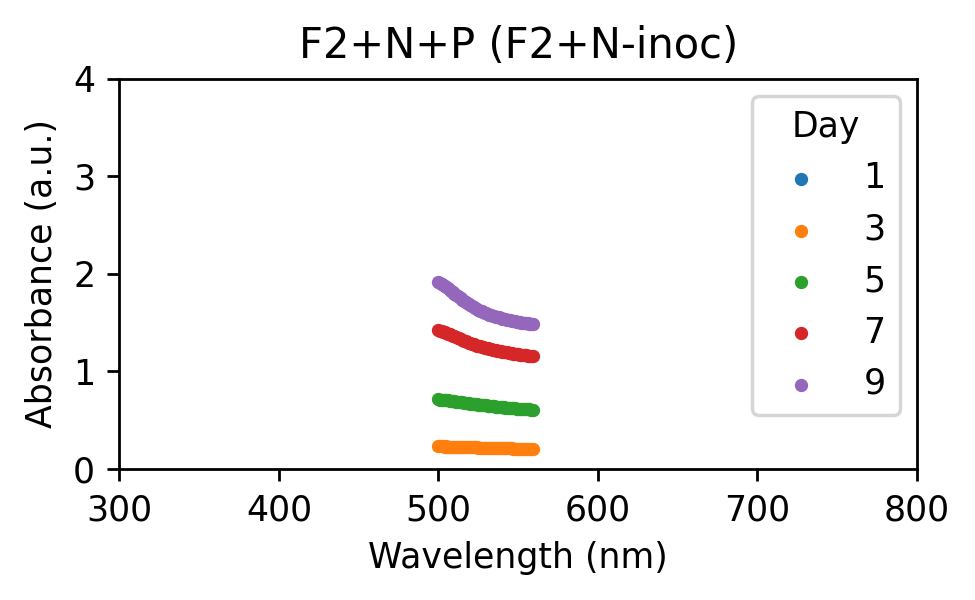

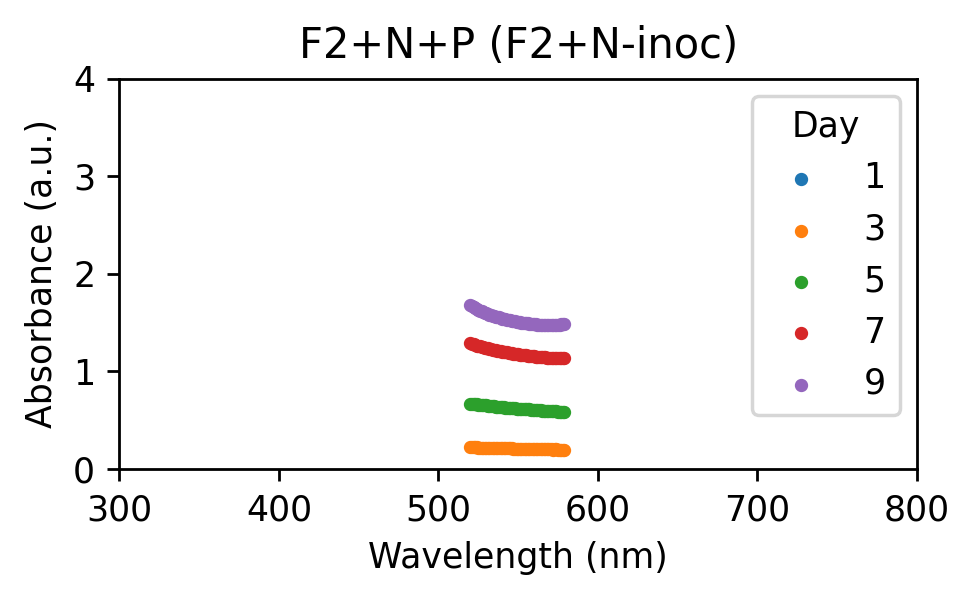

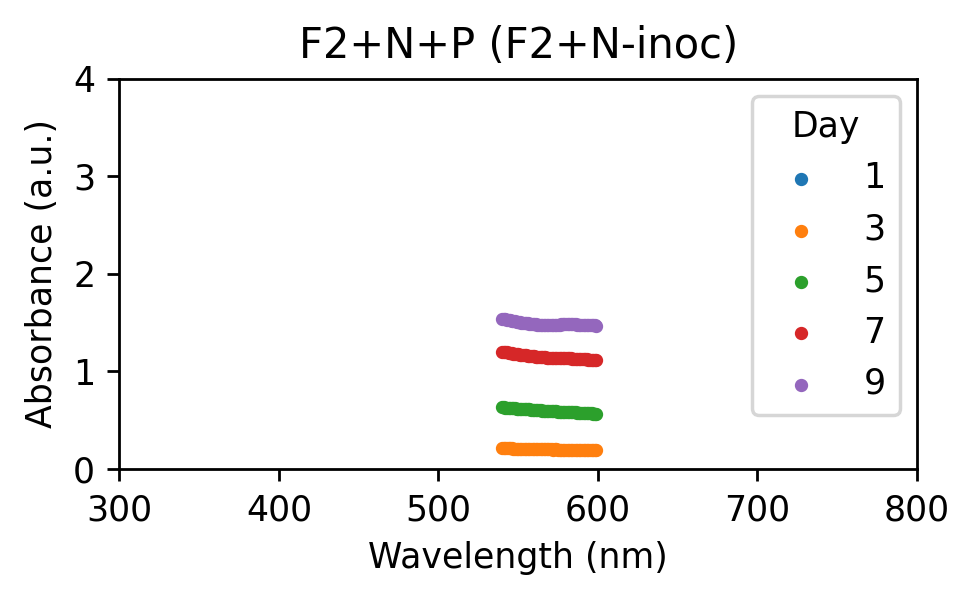

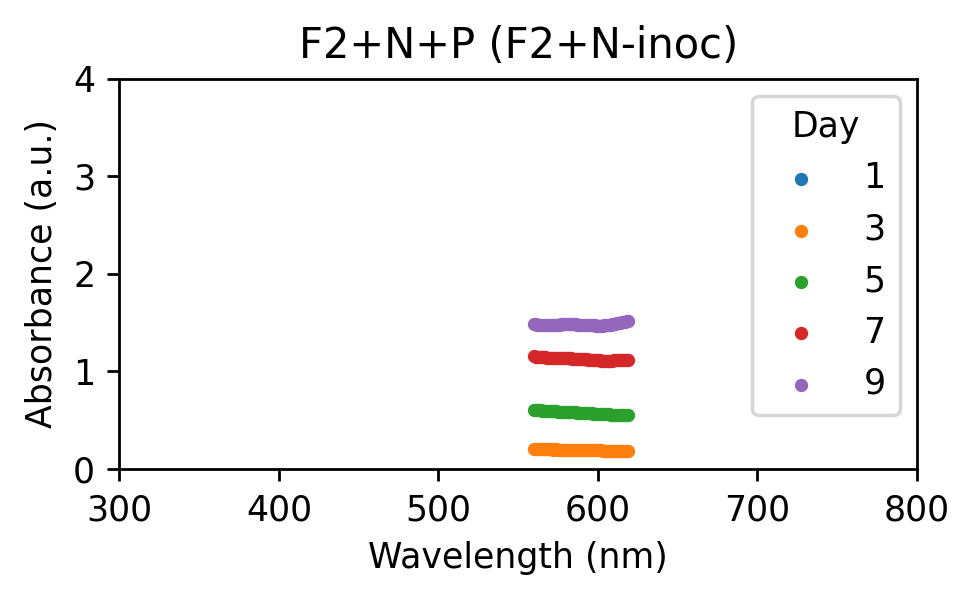

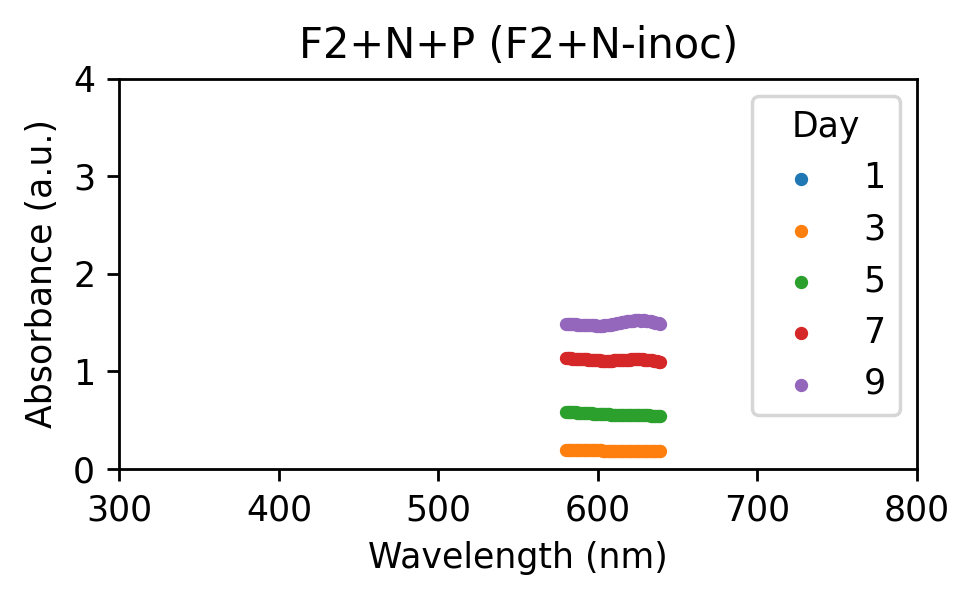

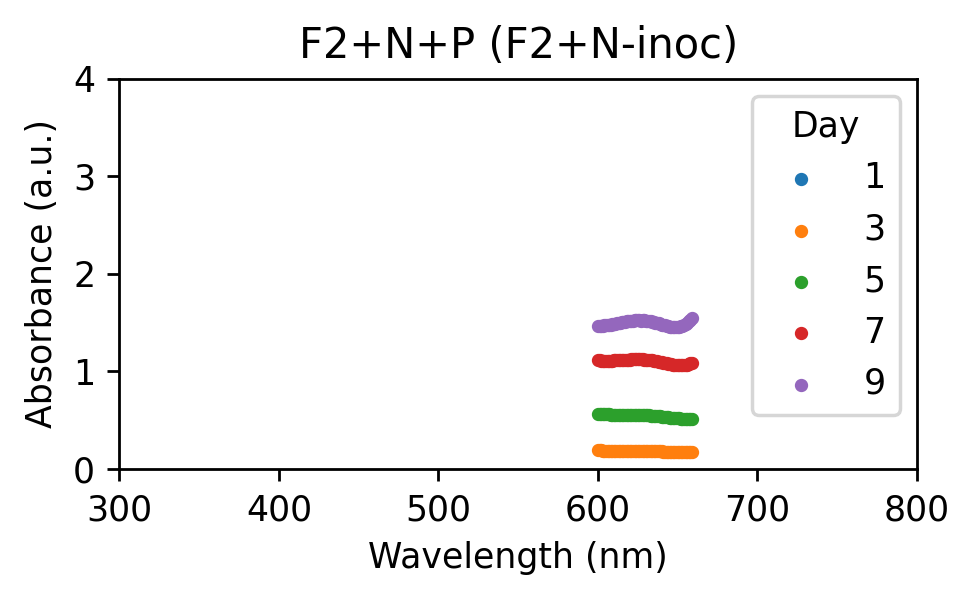

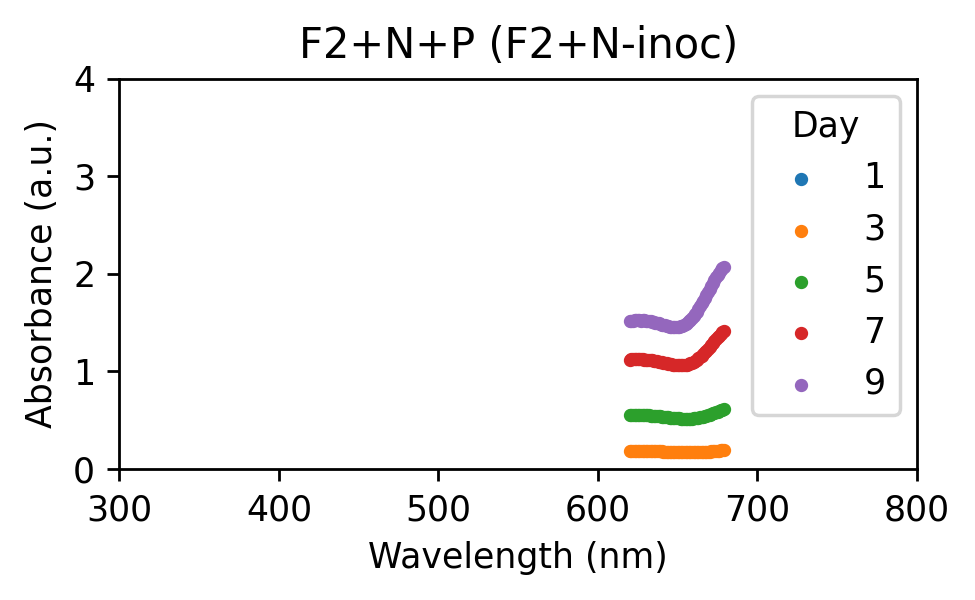

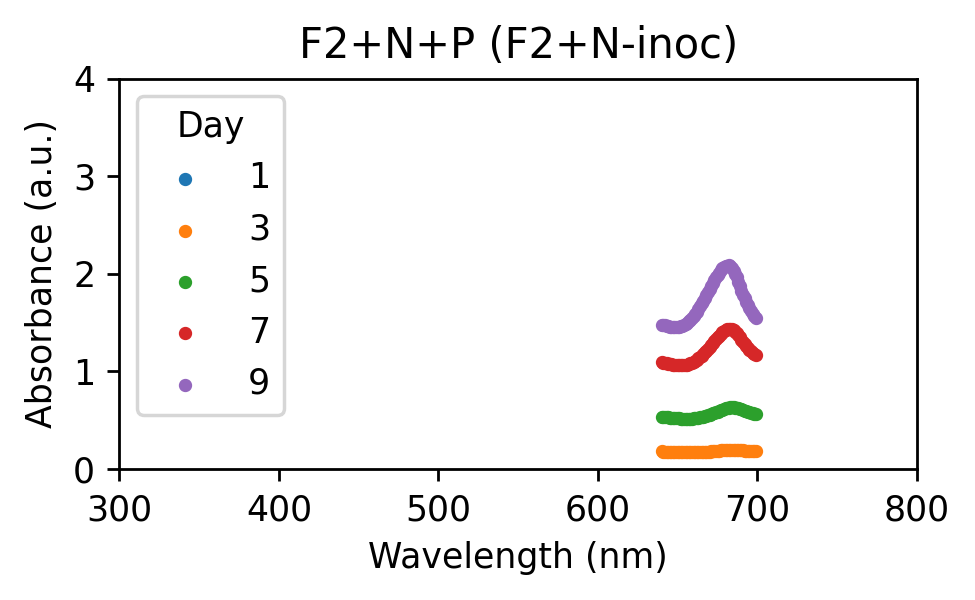

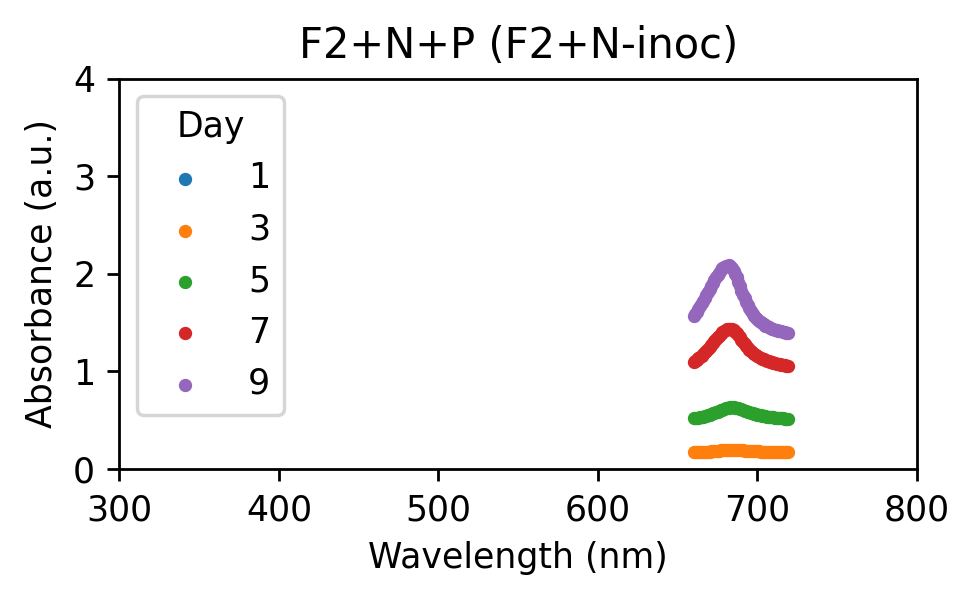

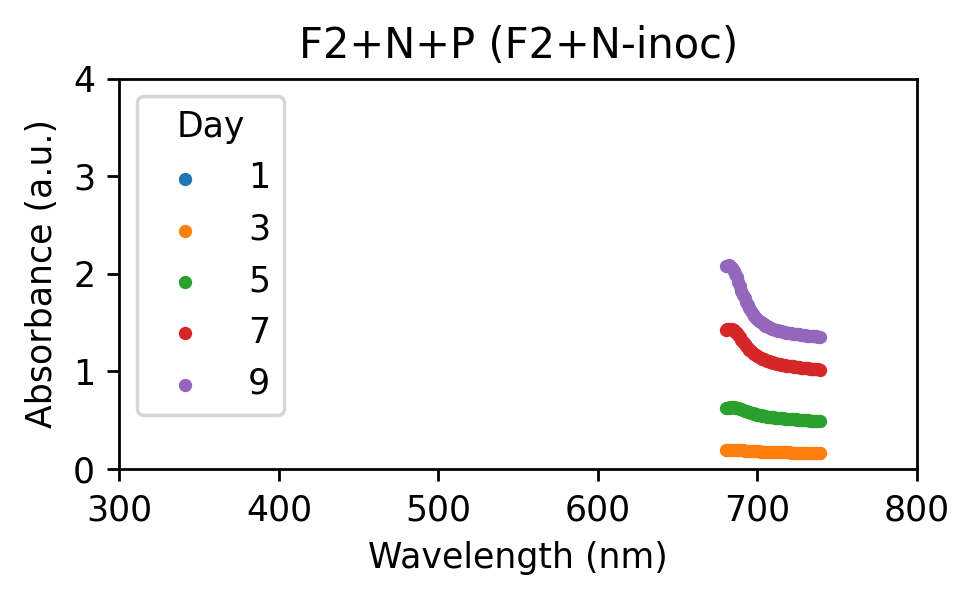

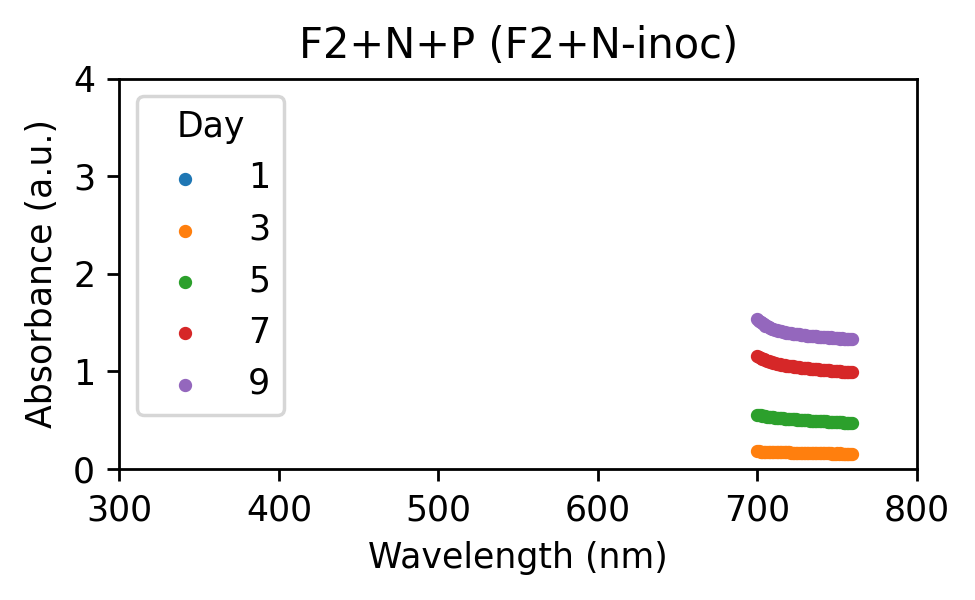

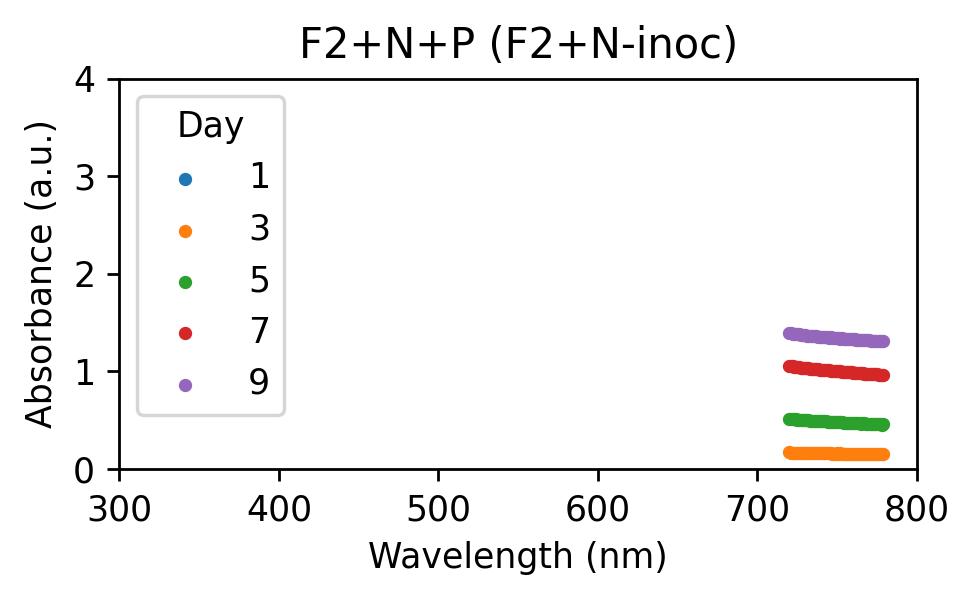

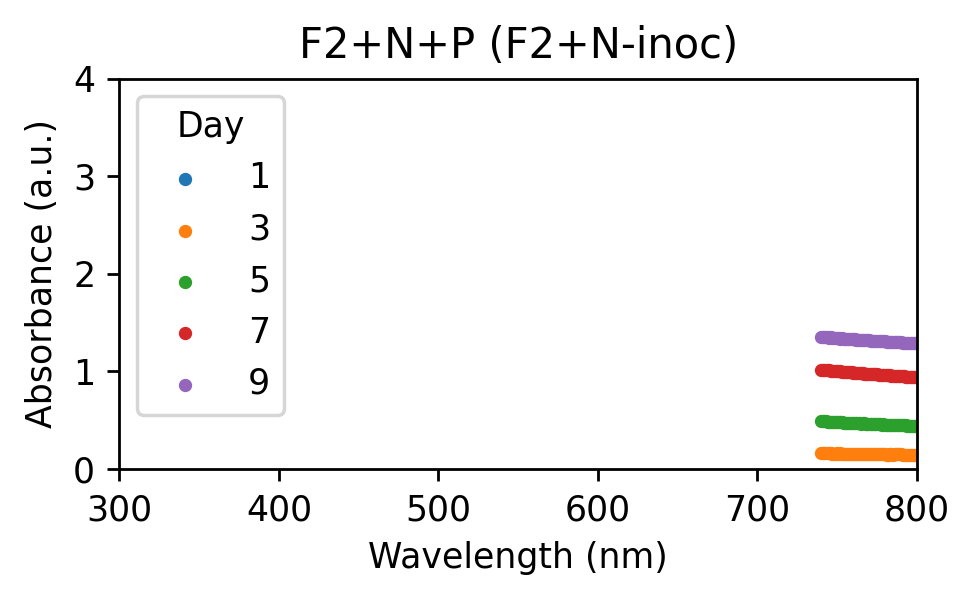

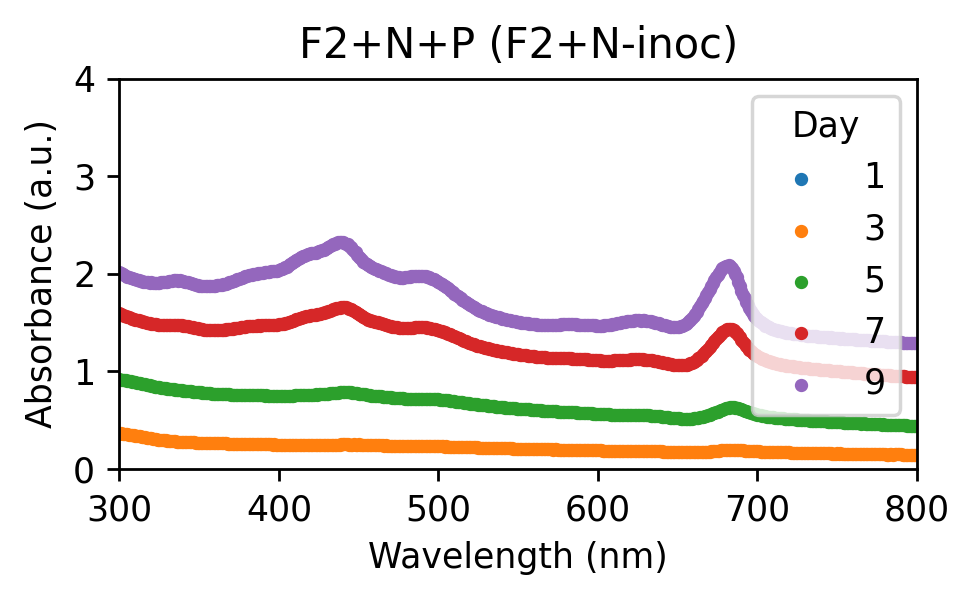

In [7]:
# Moving-window for absorbance

# Import the wavelength selection function
from variable_selection import movingwindow_forAbs

window_dict = {}
counter = {}

# Sliding 1 window
w1 = movingwindow_forAbs(absdata,
                         window_size=60,
                              step_size=20,
                              window_no=1)

from spectrum_plotter import plotmeanAbsSpecs

add_windows(w1, "MW1abs_")
add_windows([abswaves], "absall_")

days = [1,3,5,7,9]

for window in window_dict.keys():
    
    # Pre-process pipeline with just a step of variable selection
    varsel = waveRestrictor2(window_dict = window_dict, window = window)
   
    
    X_transf = varsel.fit_transform(absdata)
    plotmeanAbsSpecs(assays, 'Assay',
                     days,
                     window_dict[window],
                     X_transf,ymax=4,dataindex= True) 

Here, we show a different kind of wavelength selection: a moving emission scan on 2D fluorescence

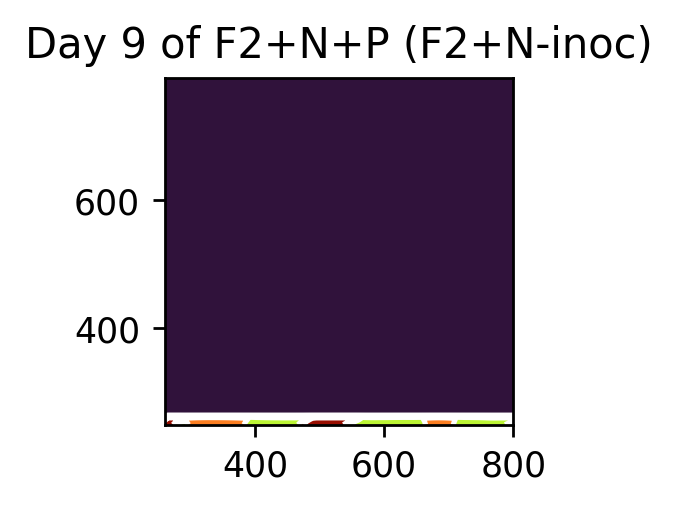

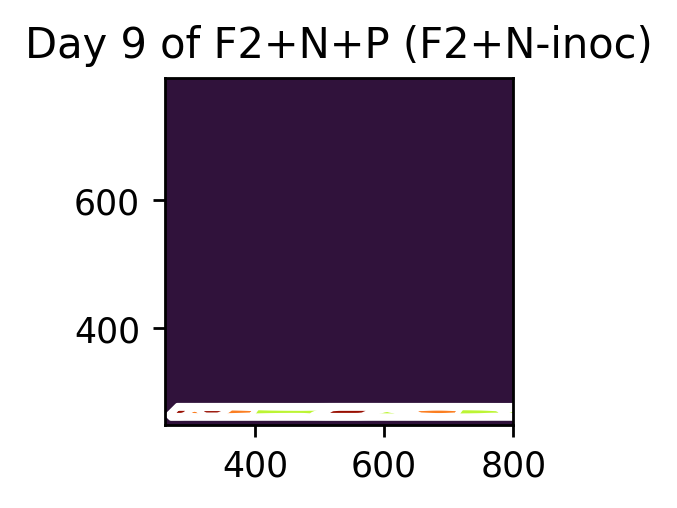

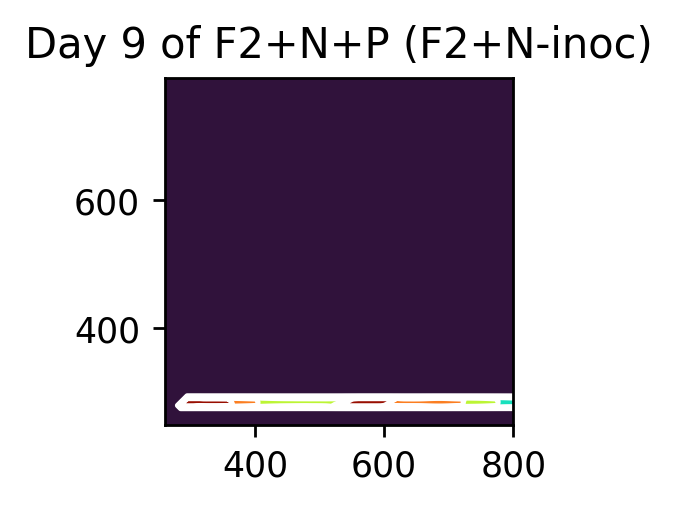

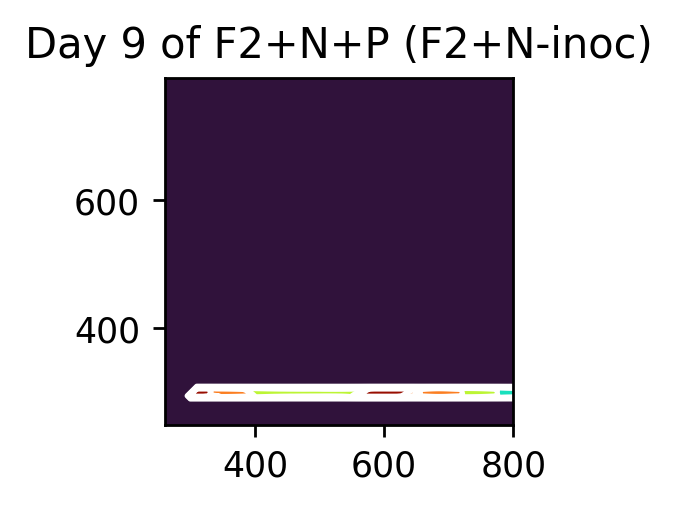

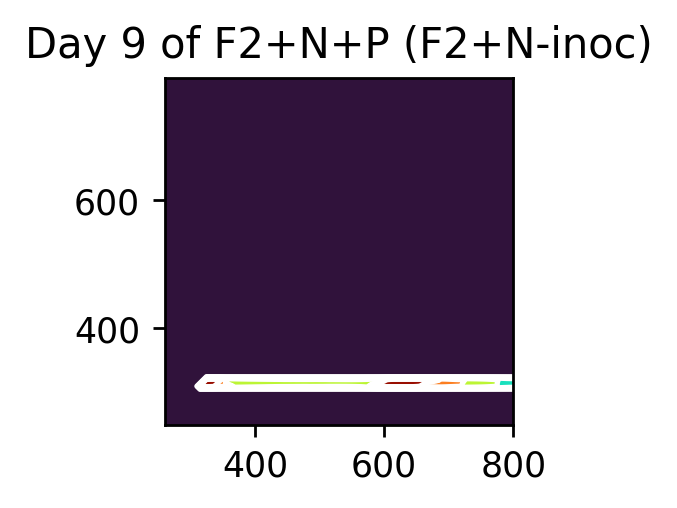

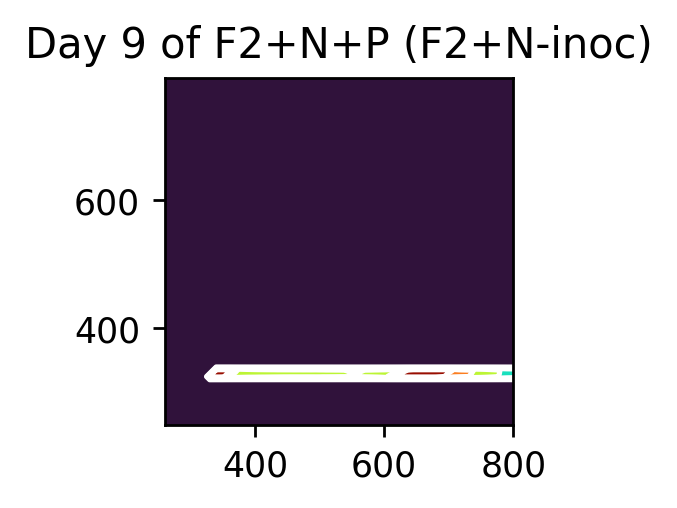

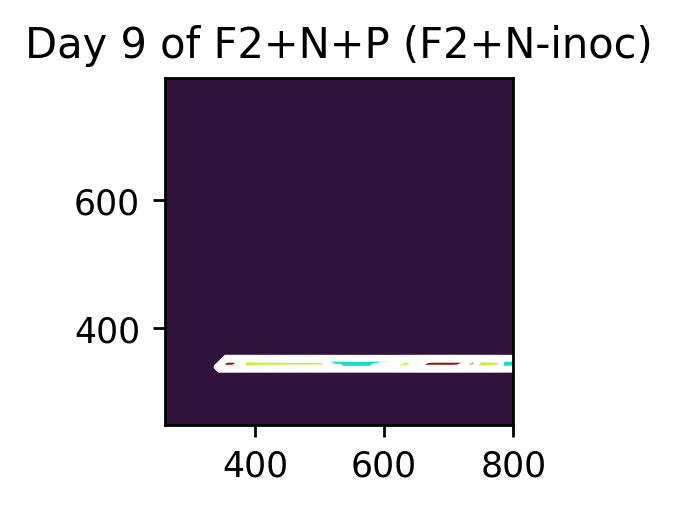

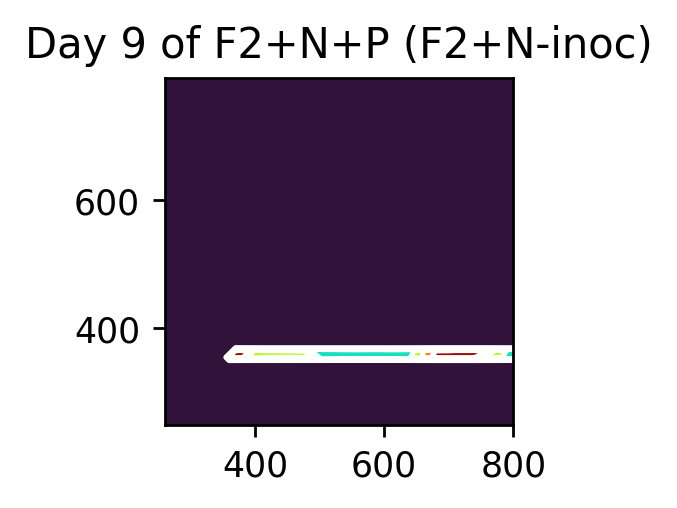

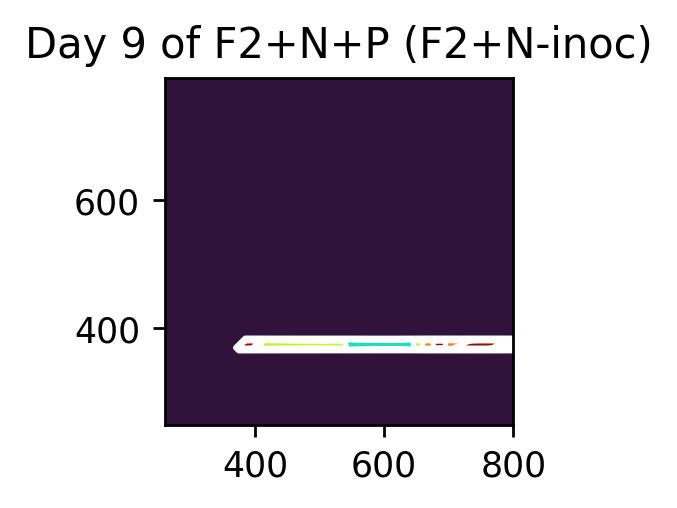

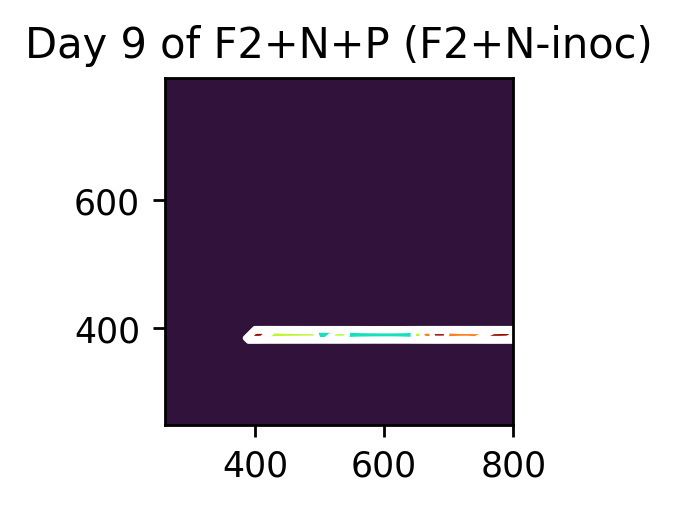

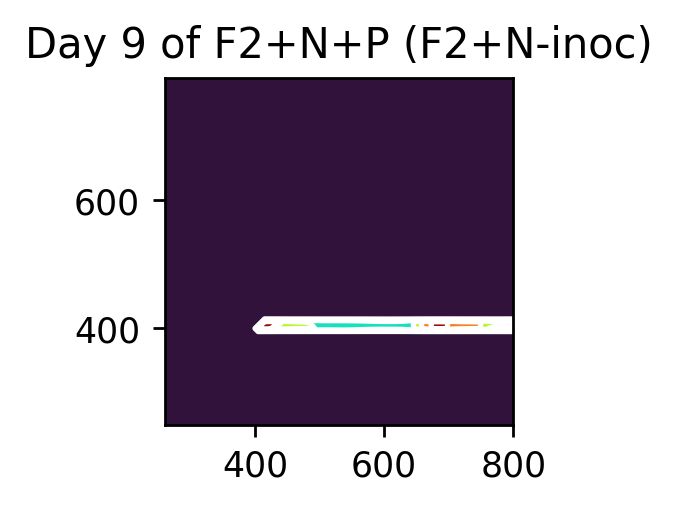

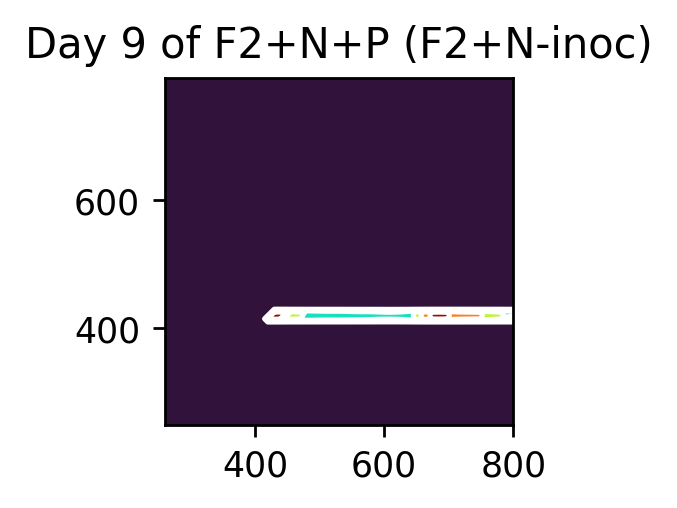

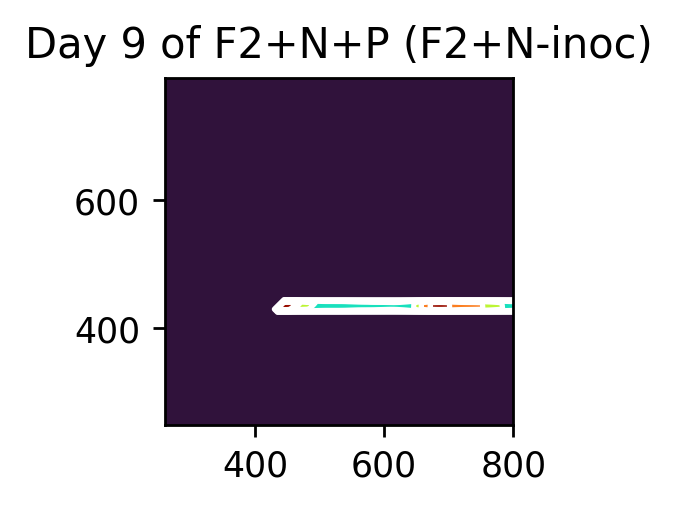

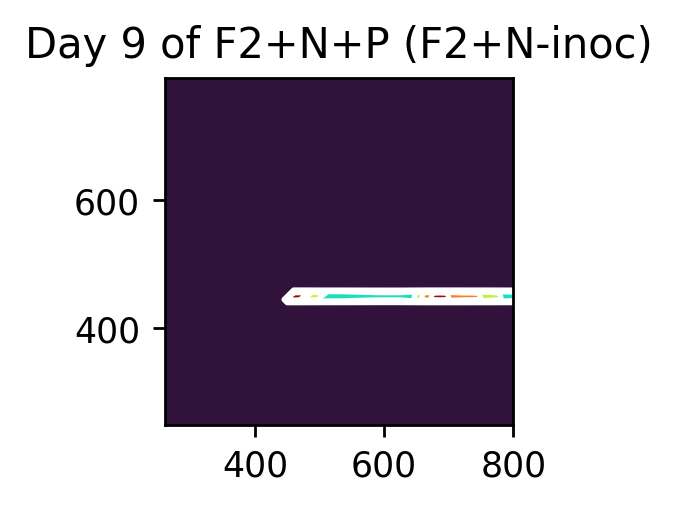

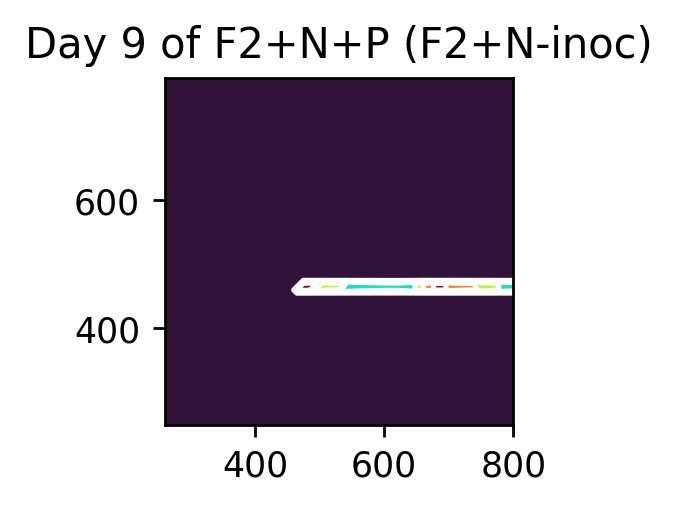

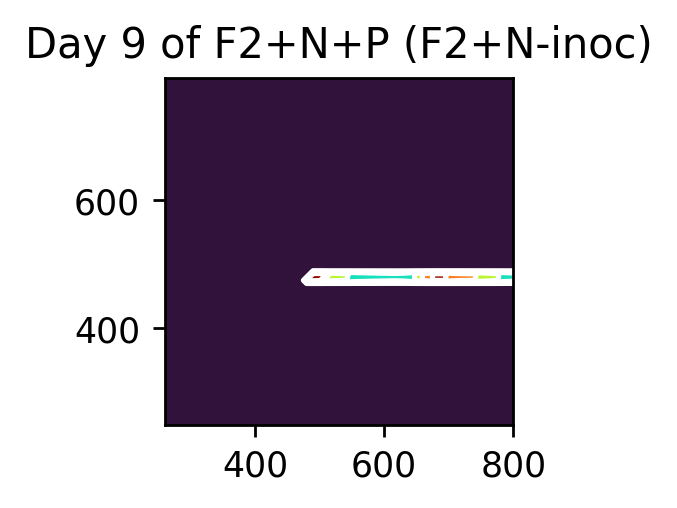

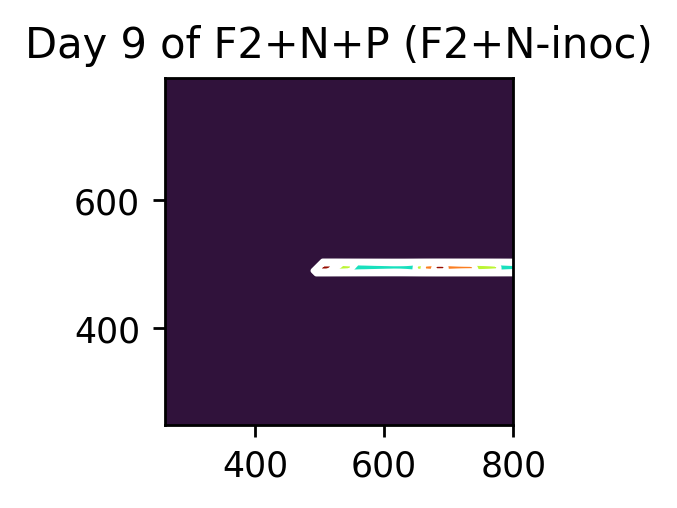

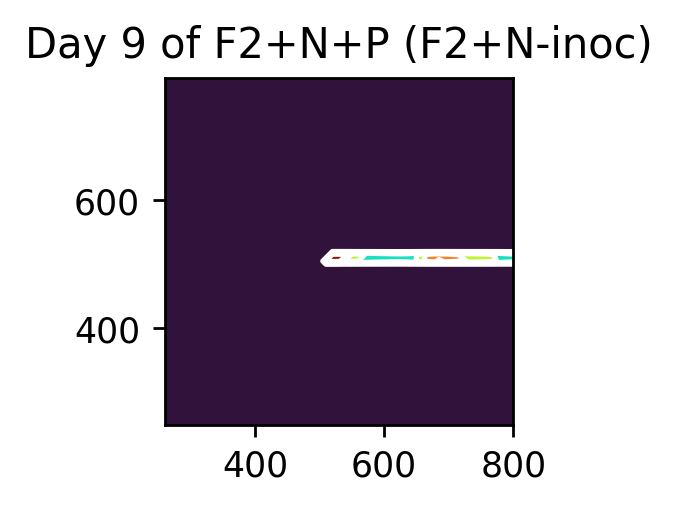

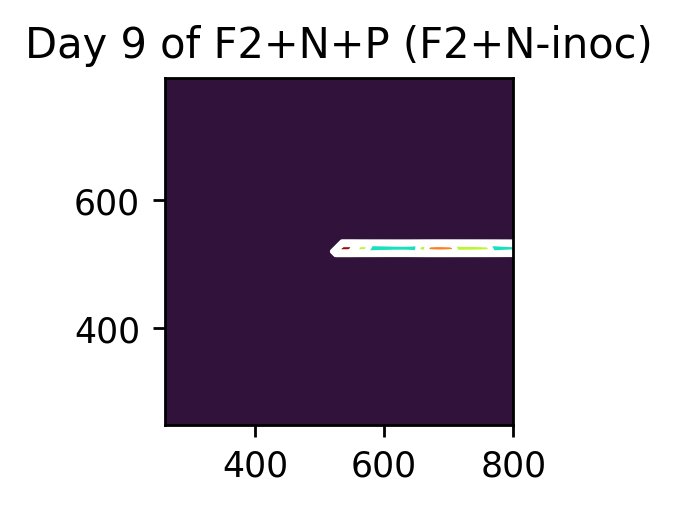

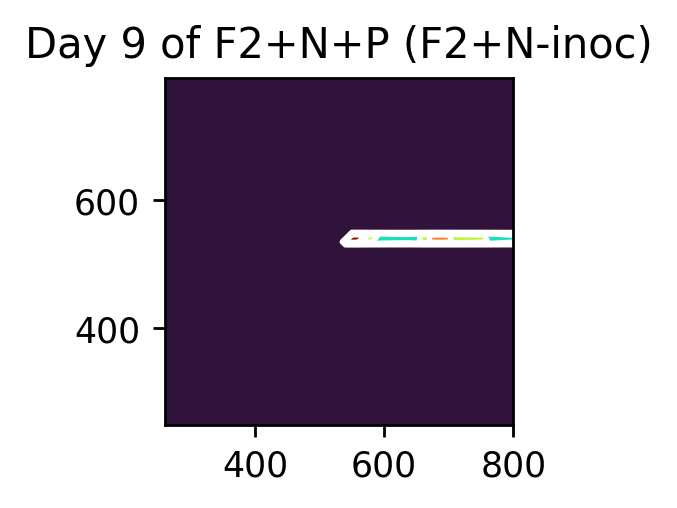

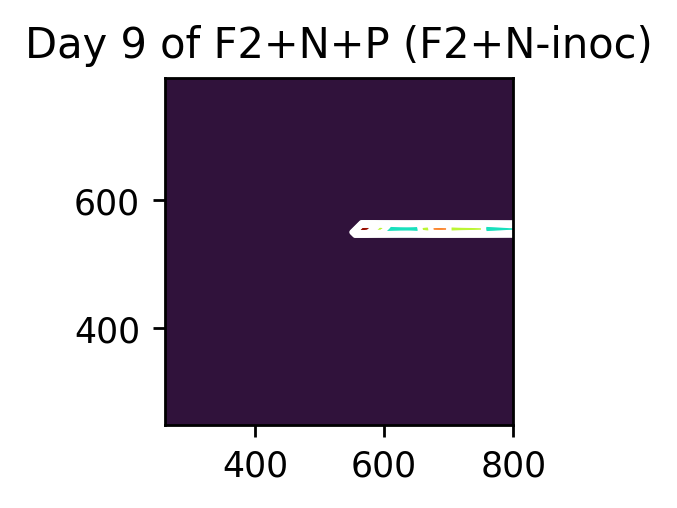

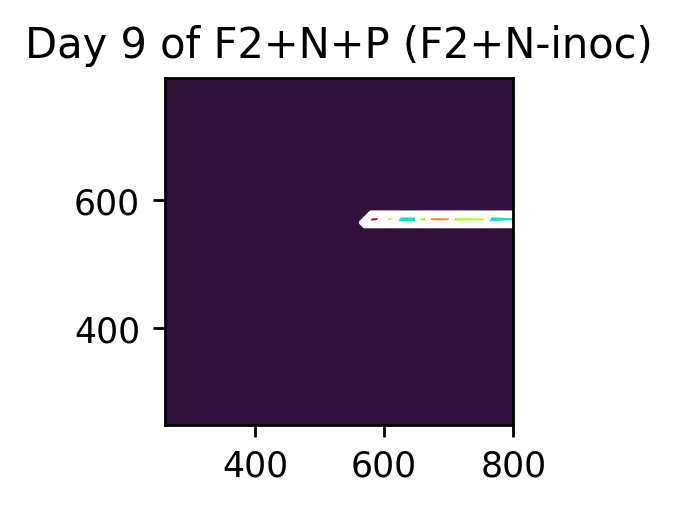

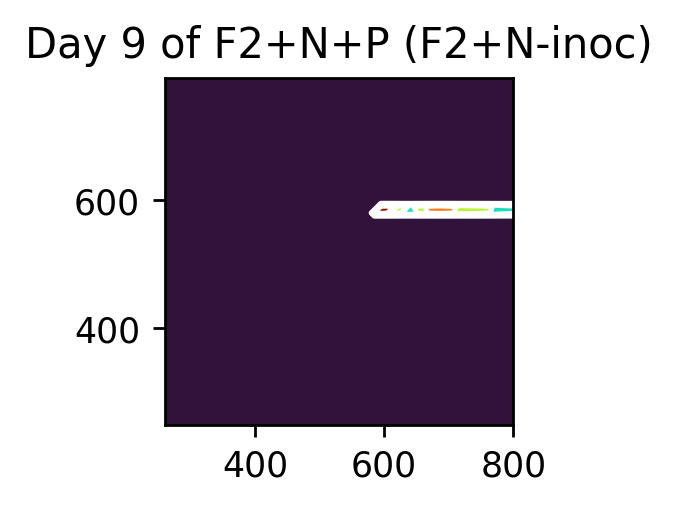

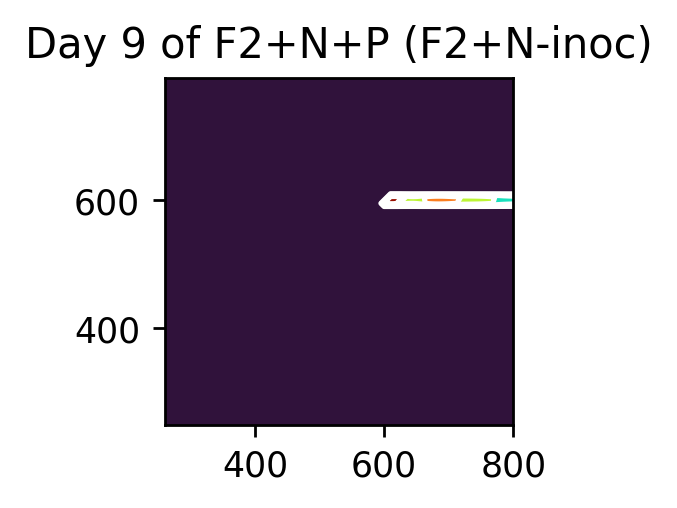

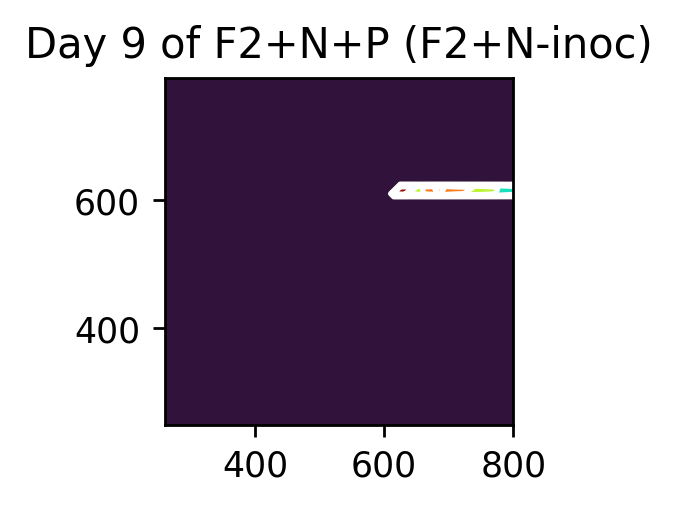

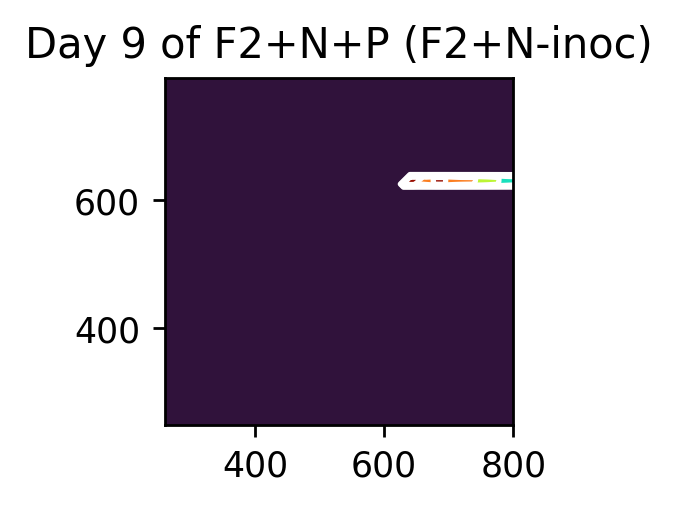

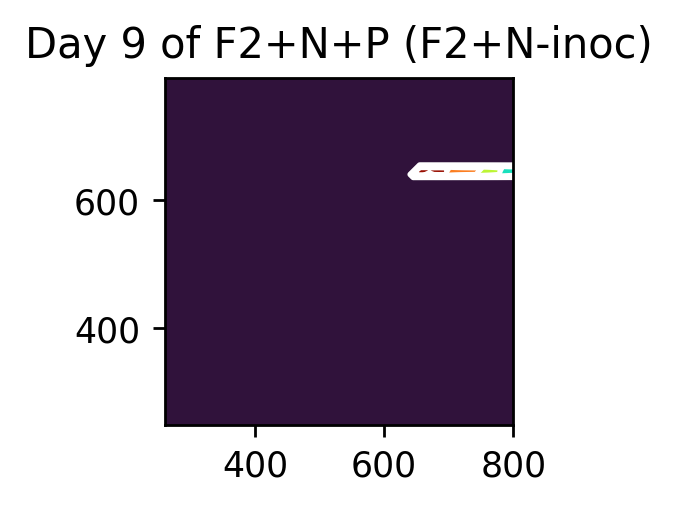

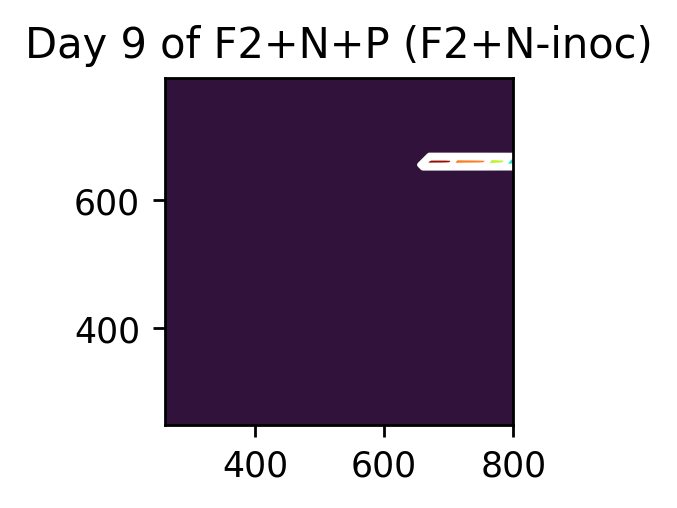

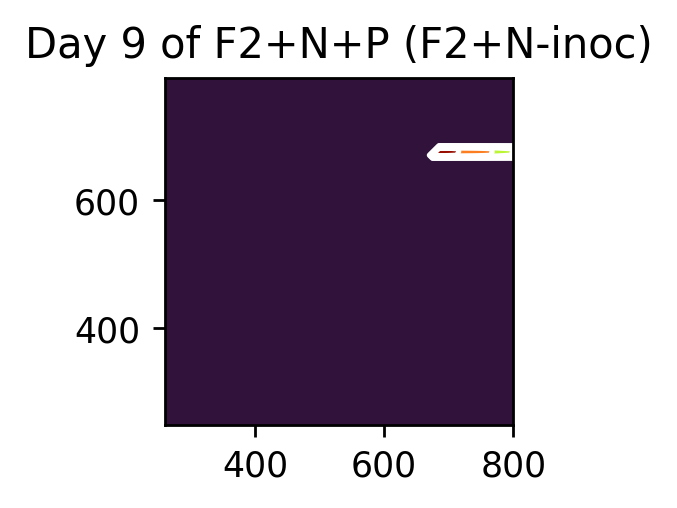

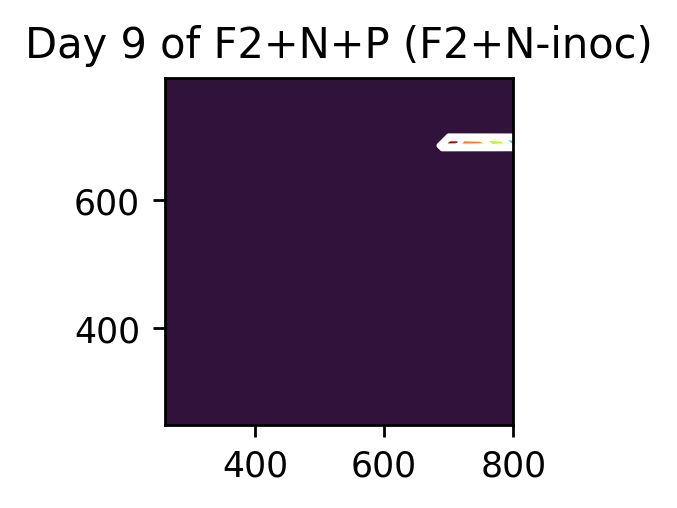

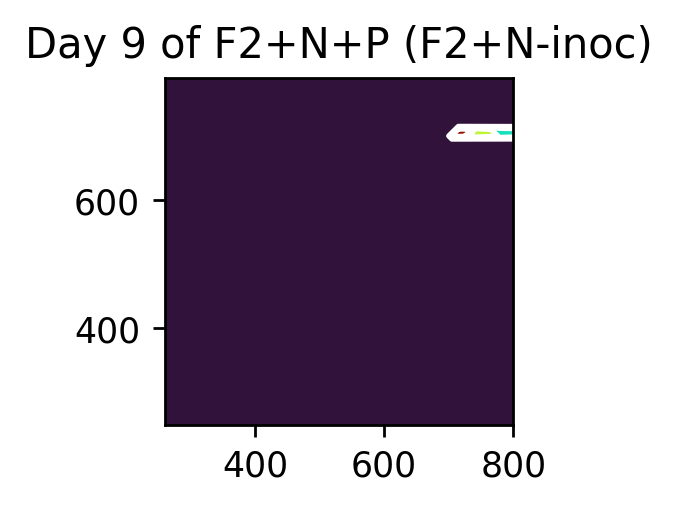

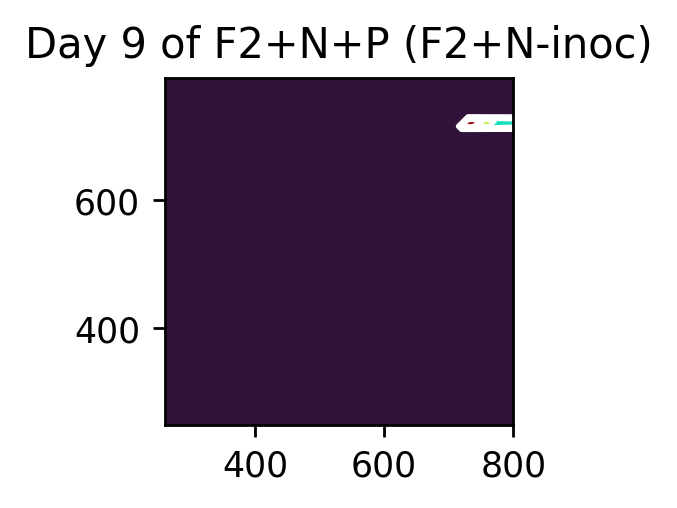

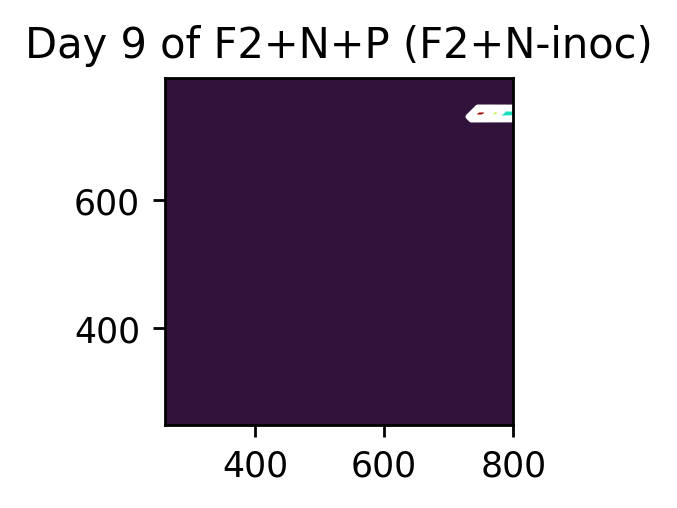

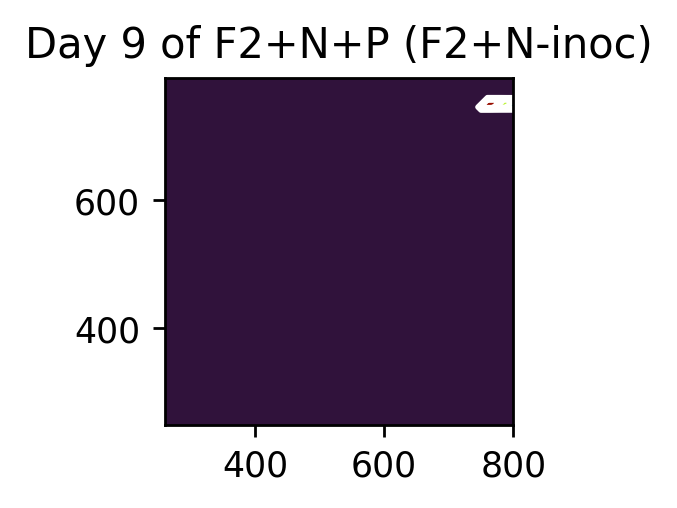

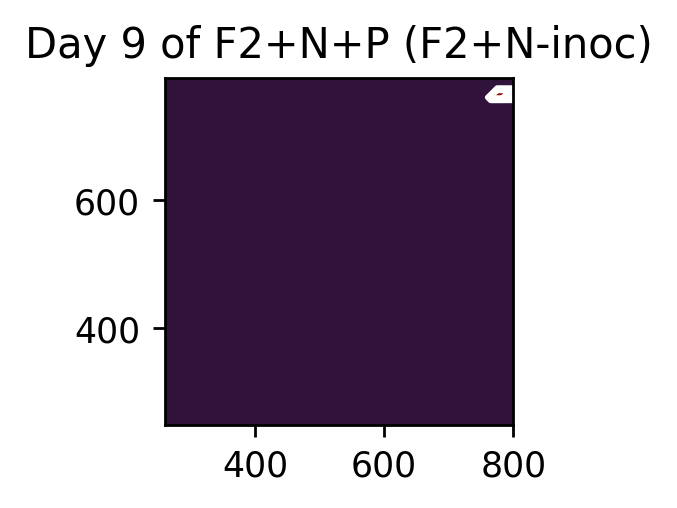

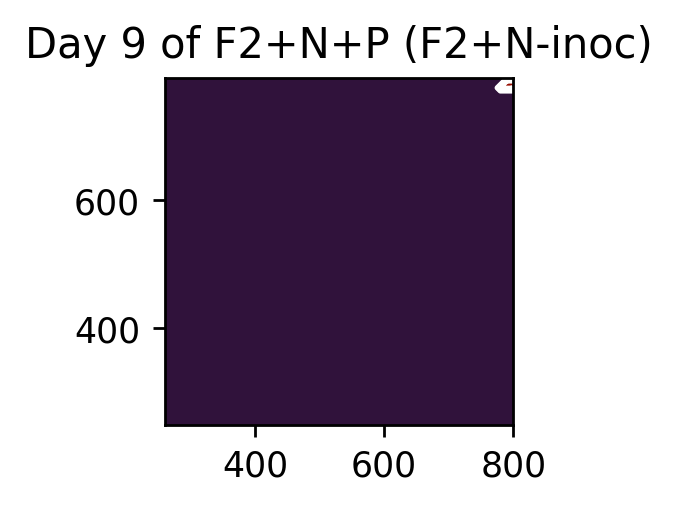

In [8]:
#%% Display Variable Spectral Selection: The emission scans

days = [9]
        
window_dict = {}
counter = {}

w7 = fluoro1Dgen(fluorowaves,moving_excitation=True,window_size=3,random_selection=0,
                                    wave_interval= range(250,790,5))

add_windows(w7, "Em_")

for window in window_dict.keys():
    
    # Pre-process pipeline with just a step of variable selection
    varsel = waveRestrictor2(window_dict = window_dict, window = window)
    
    X_transf = varsel.fit_transform(fluorodata)
    plot_meanpartialspectrum(fluorodata, X_transf,days,assays,sampleinfo,
                             contours = 1,
                             log=1)


Finally, with the following script we generate a list of randomly generated windows

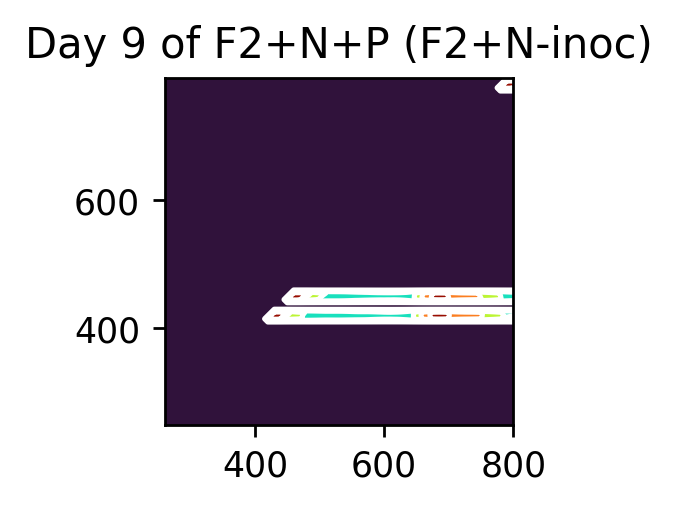

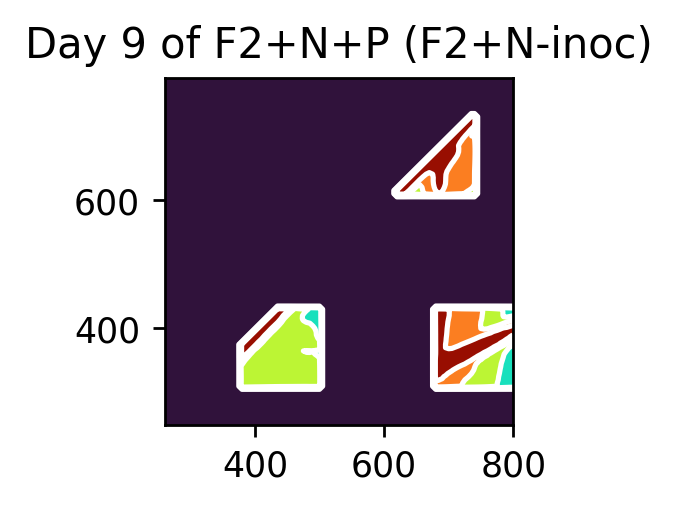

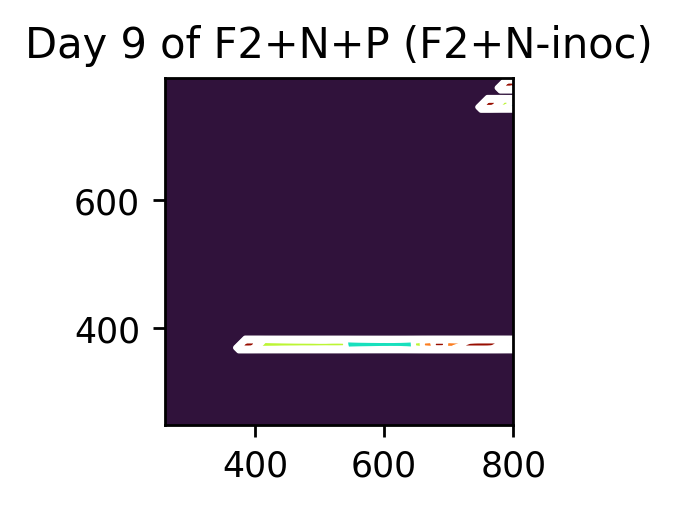

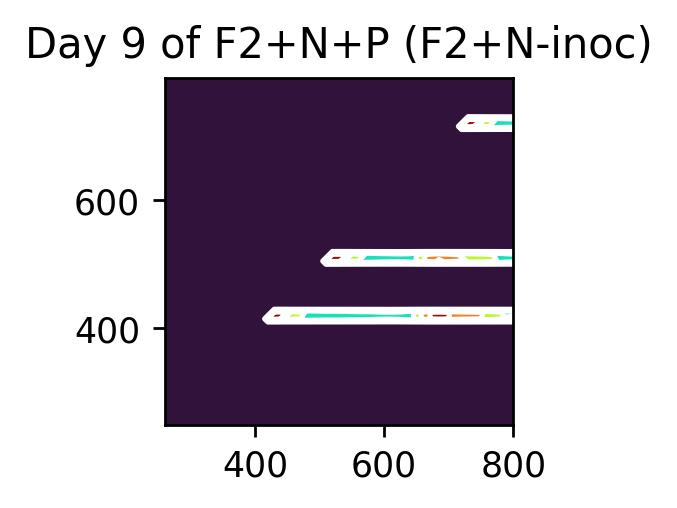

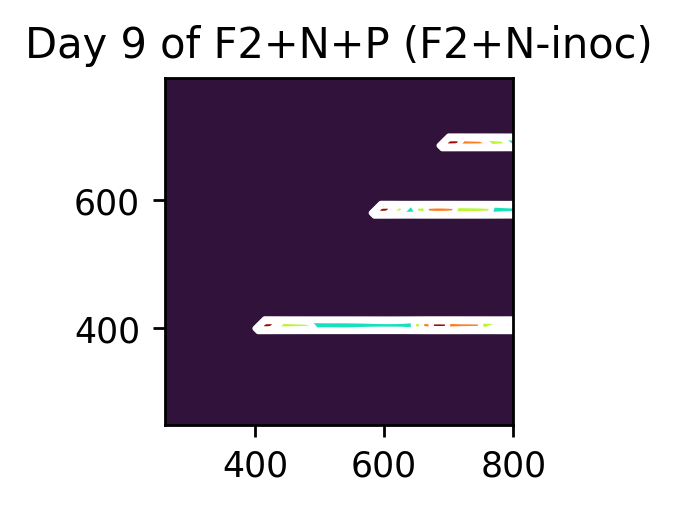

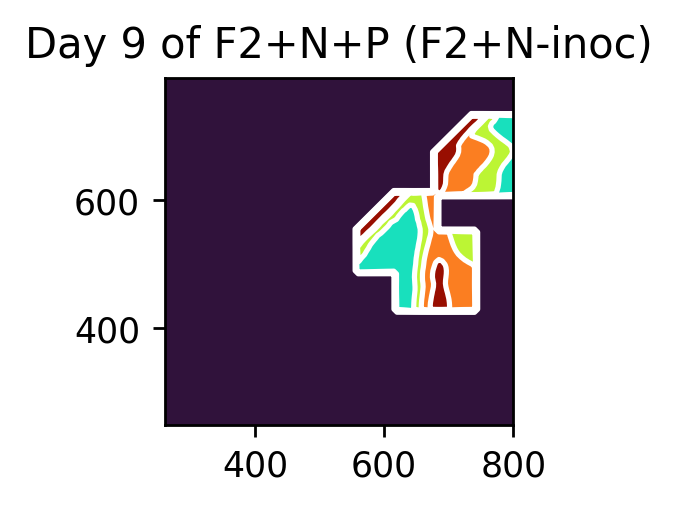

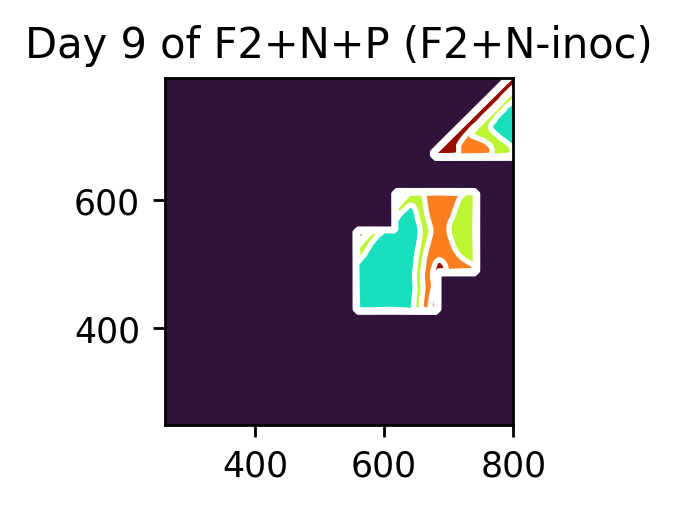

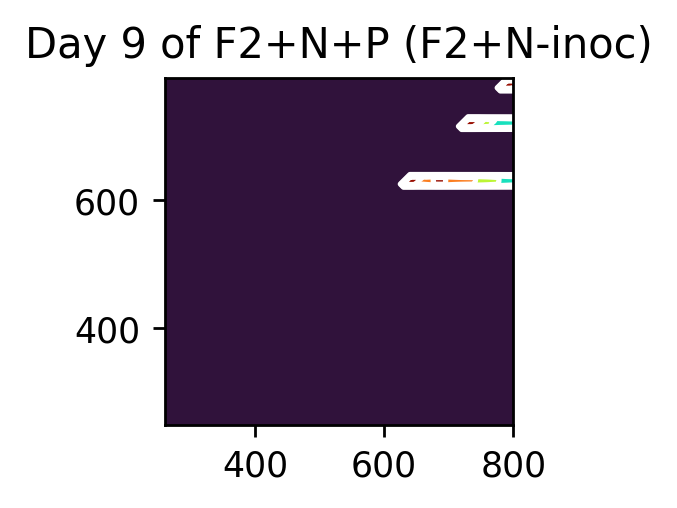

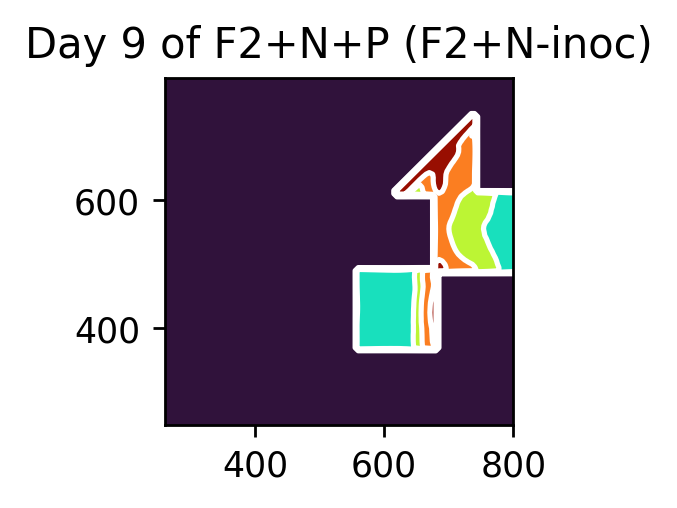

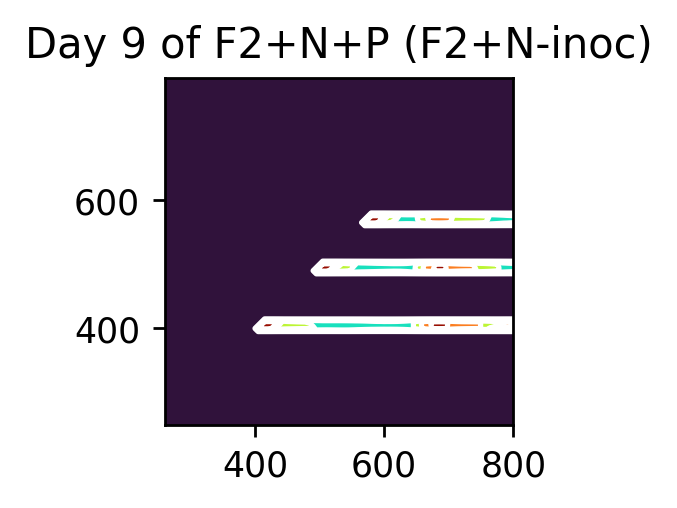

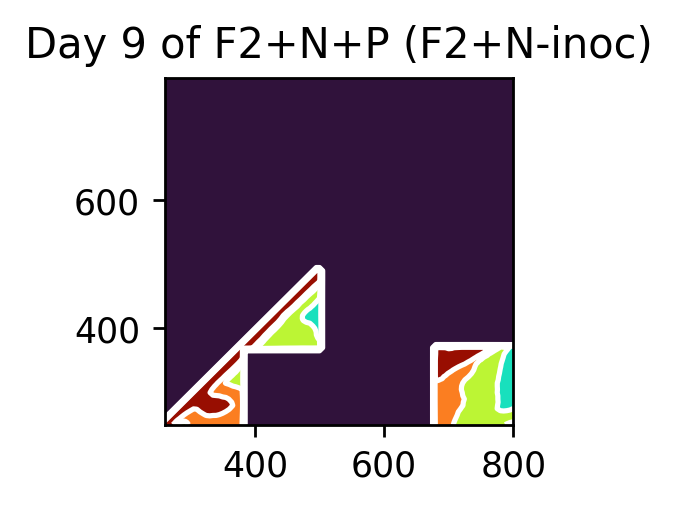

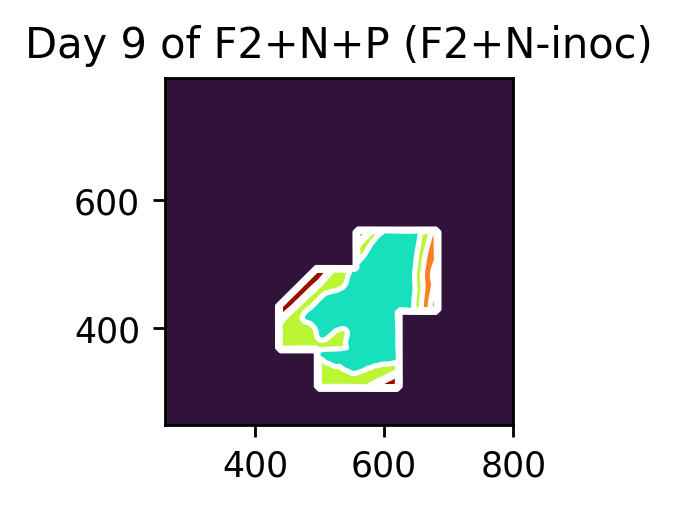

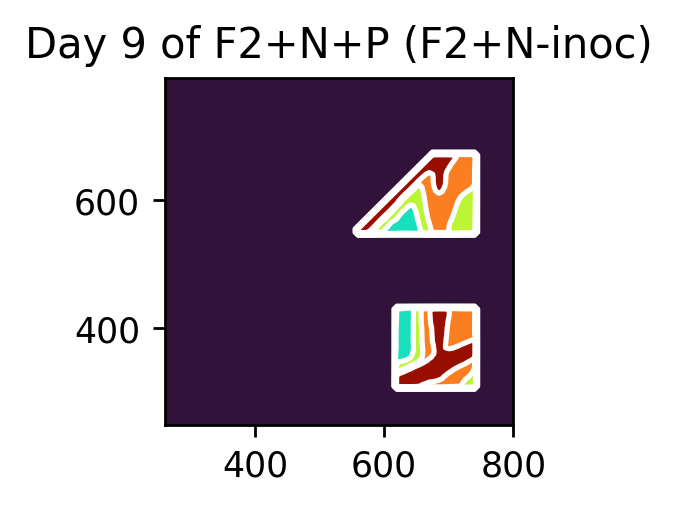

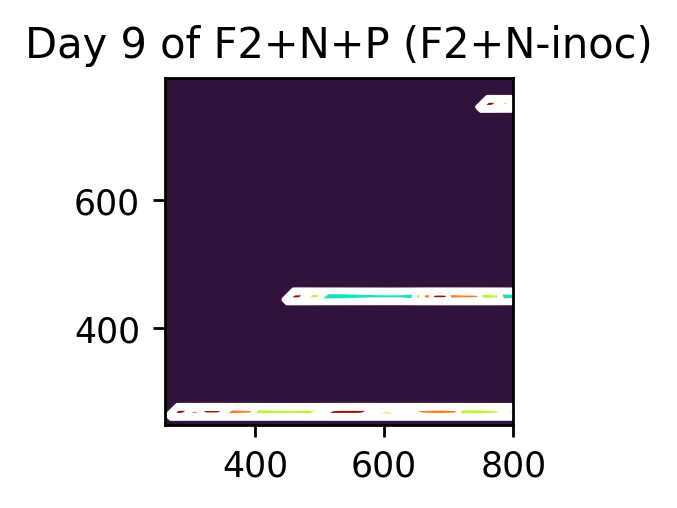

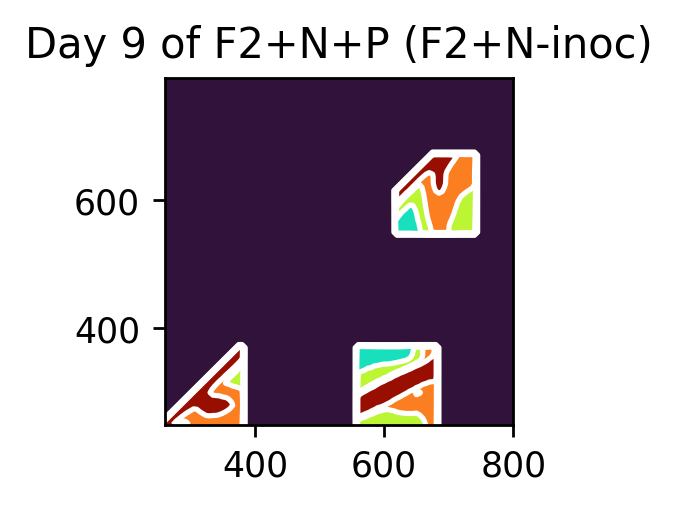

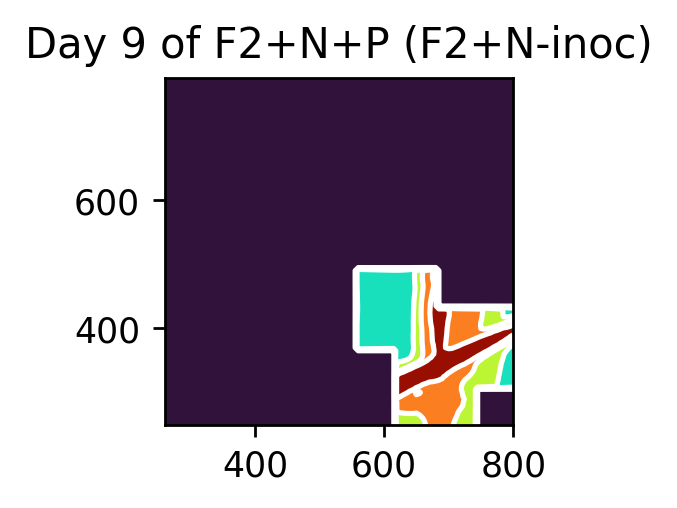

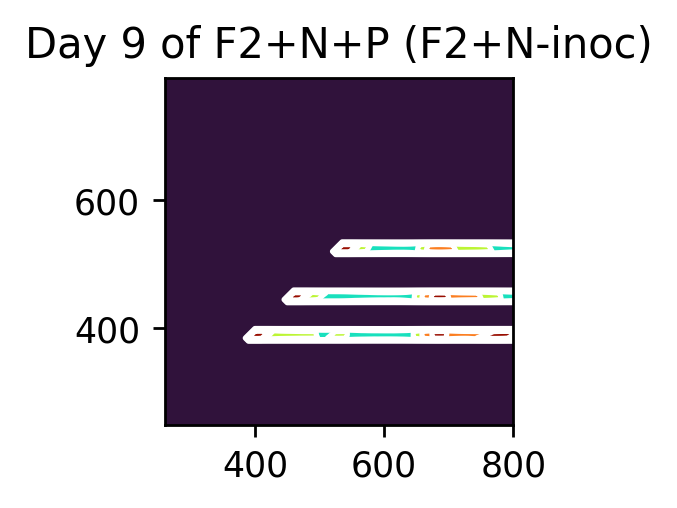

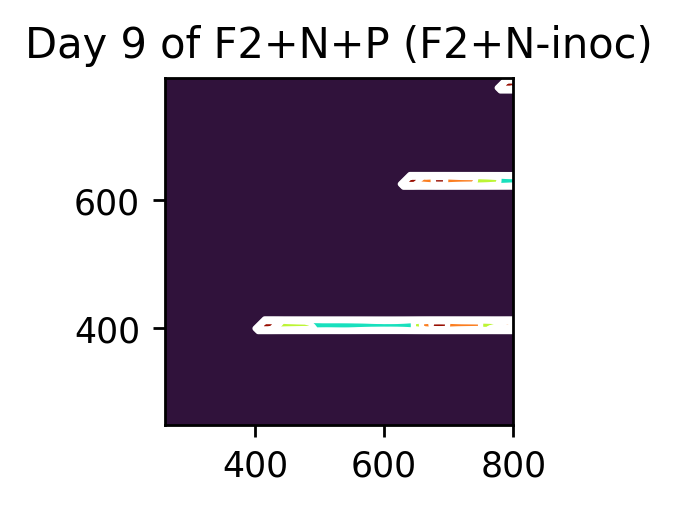

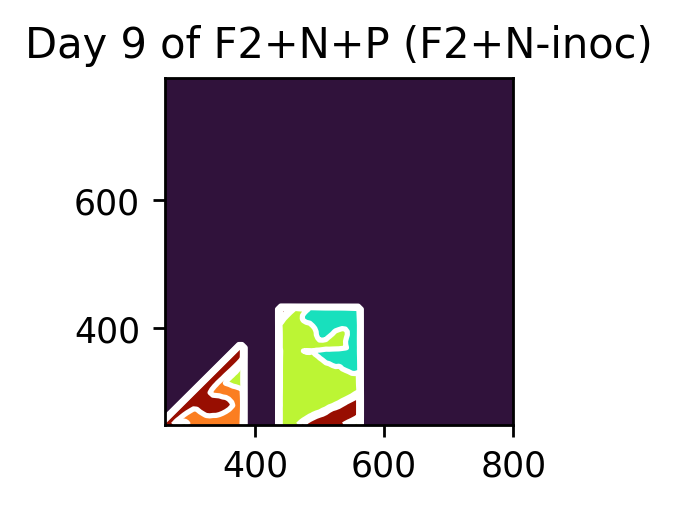

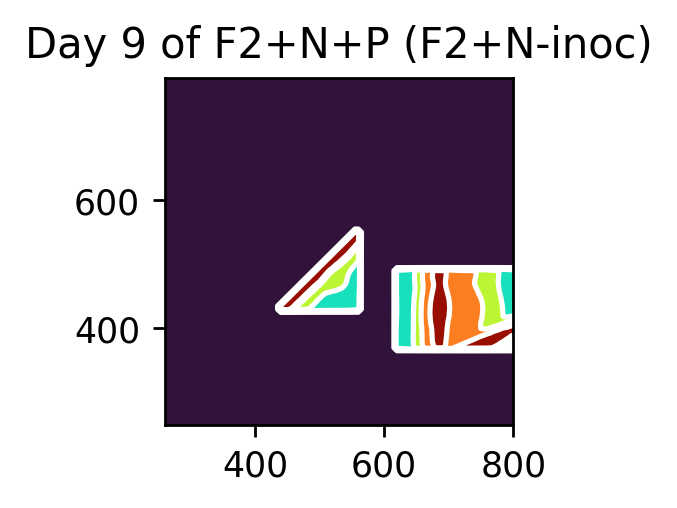

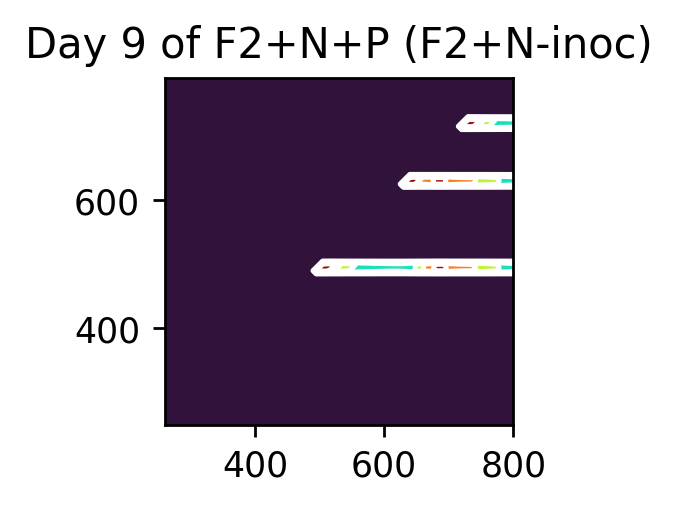

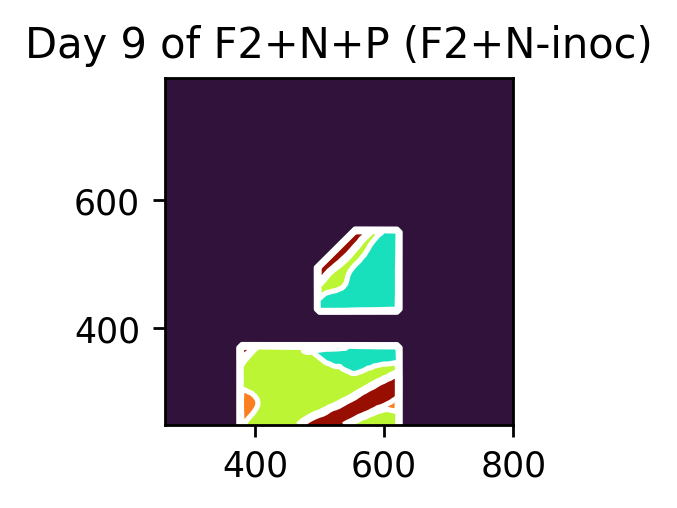

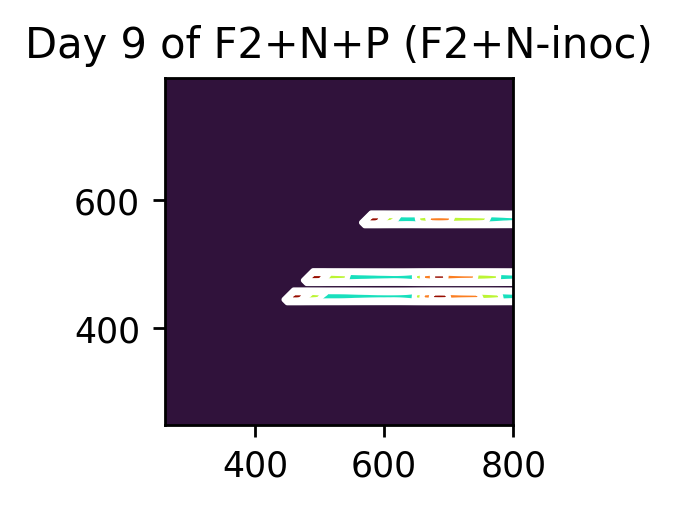

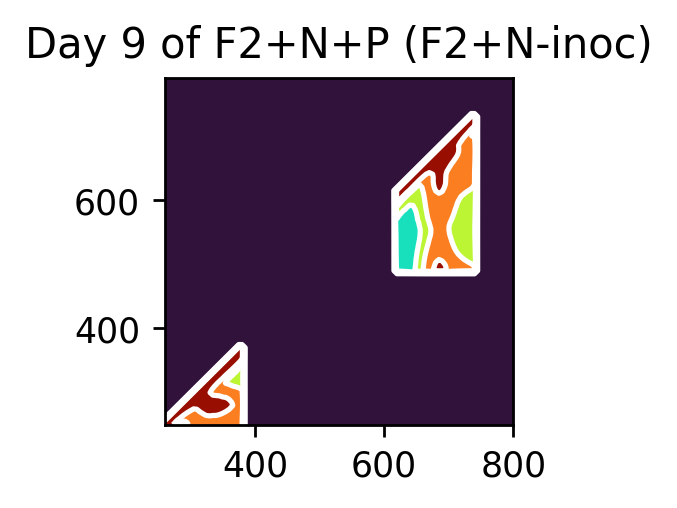

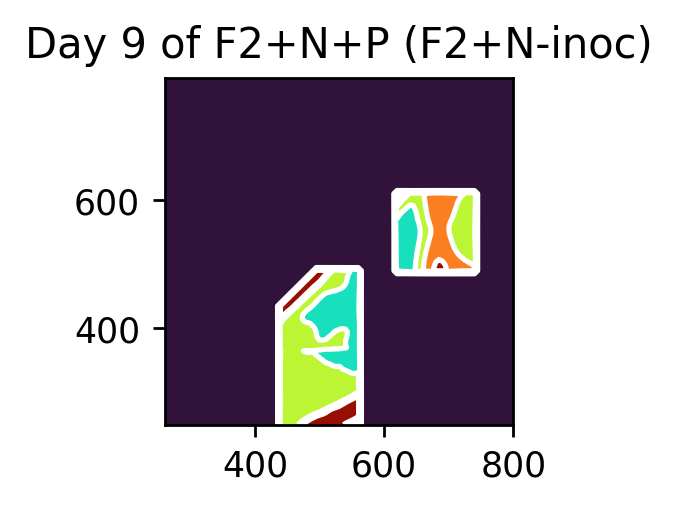

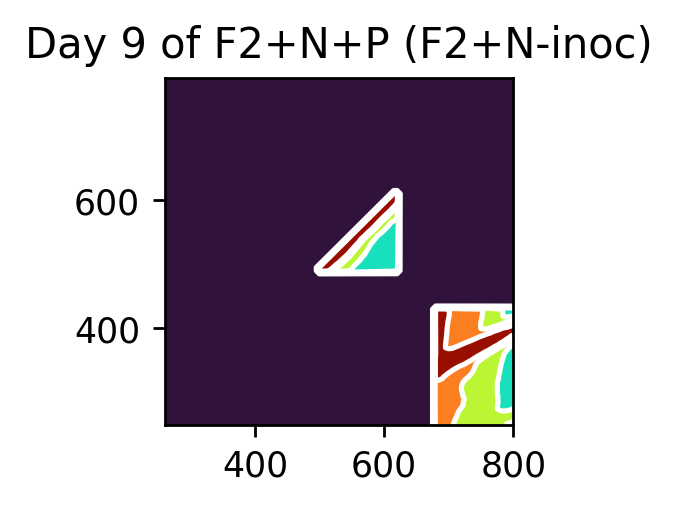

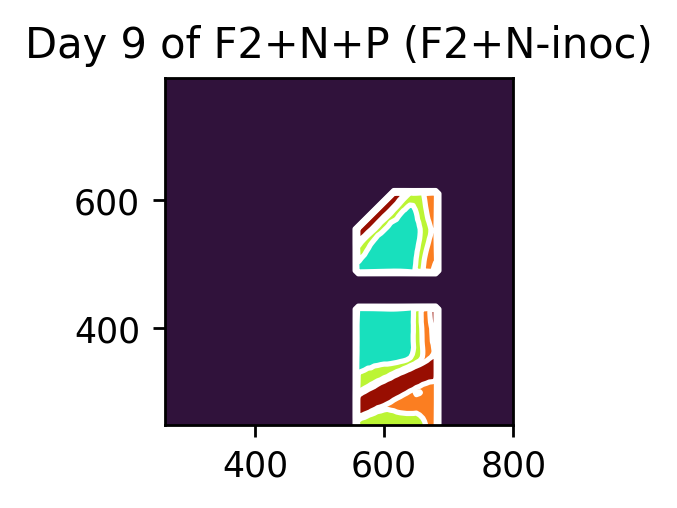

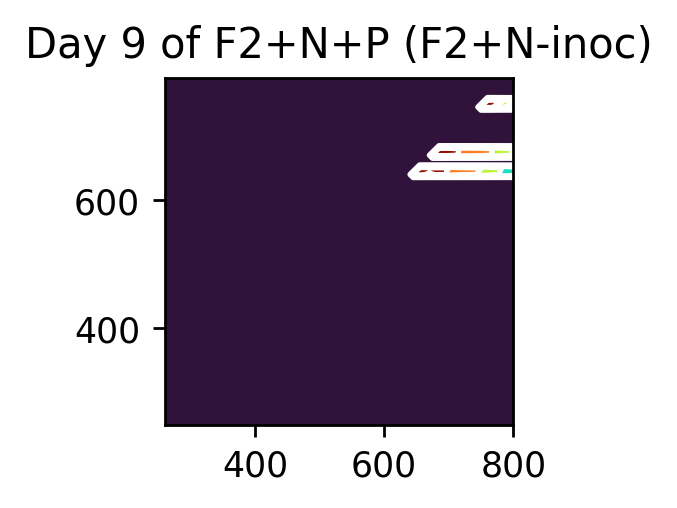

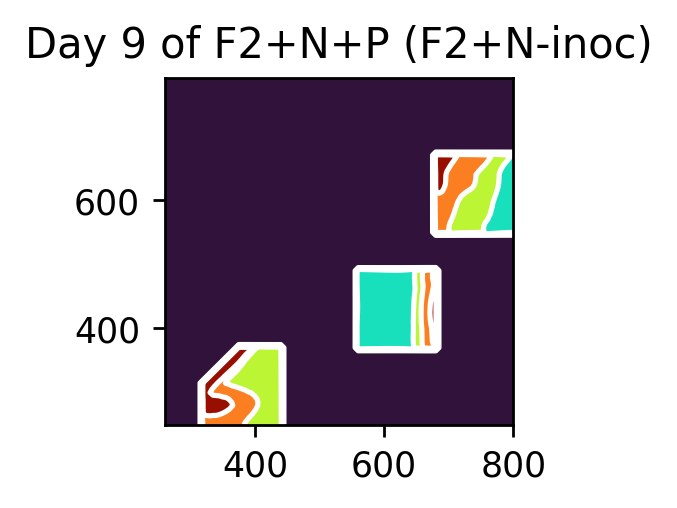

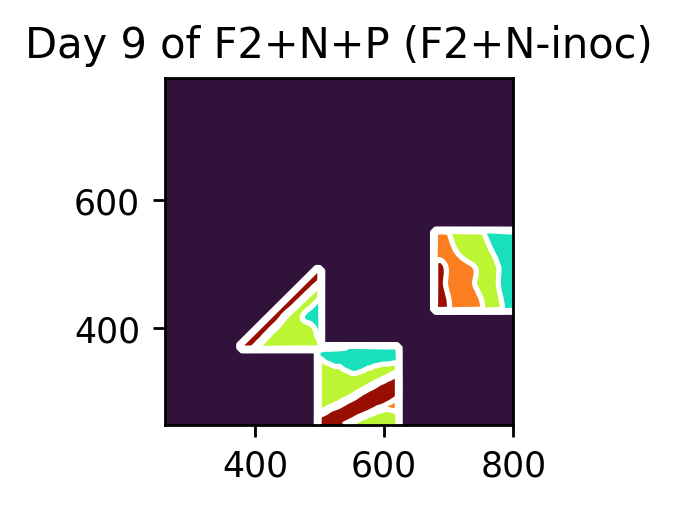

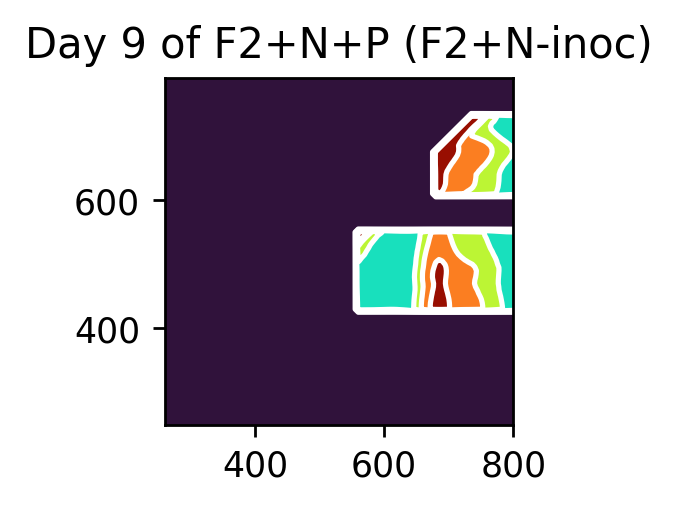

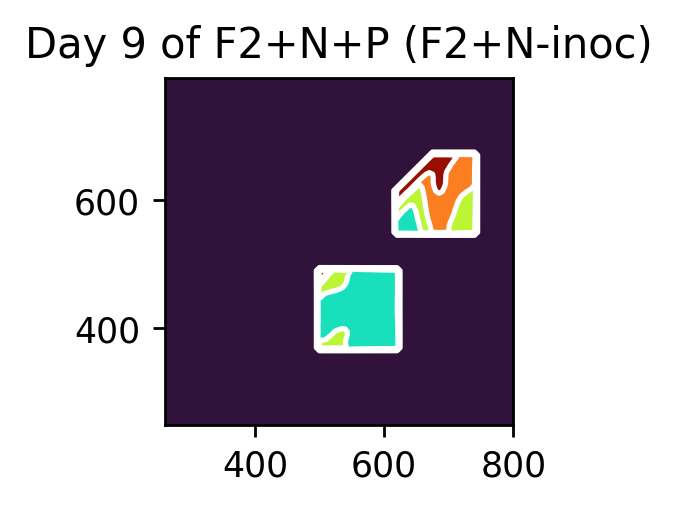

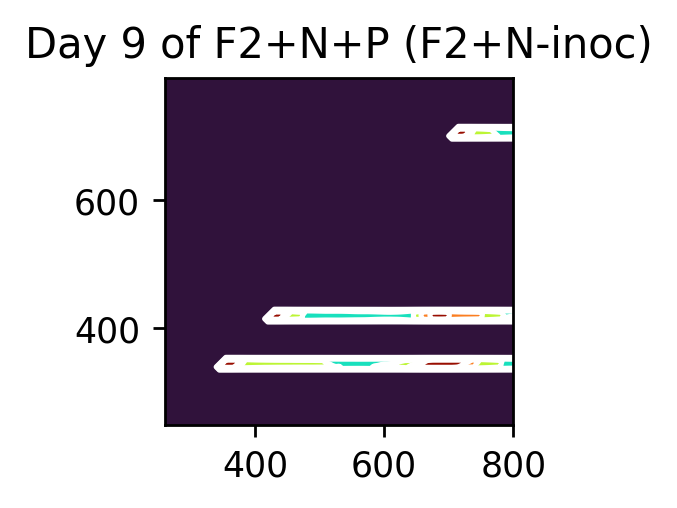

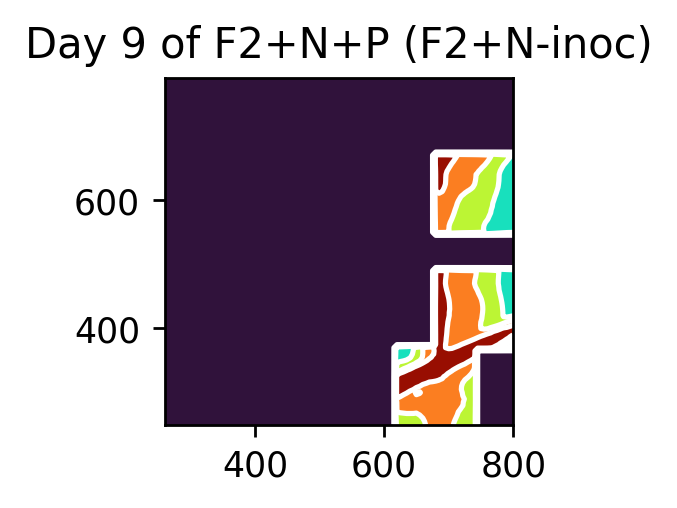

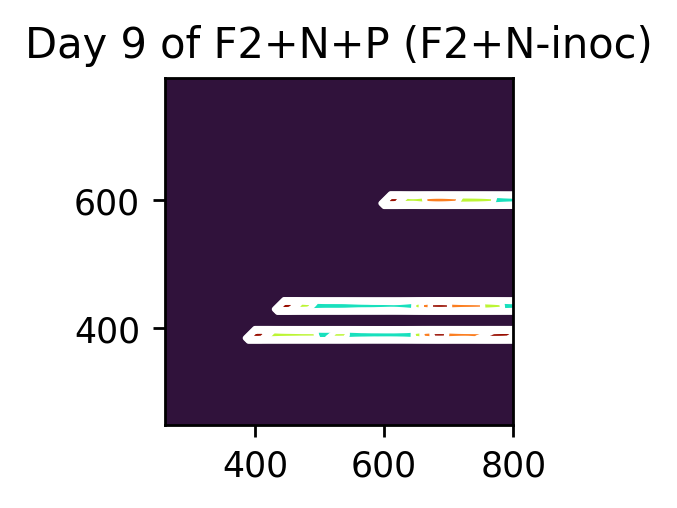

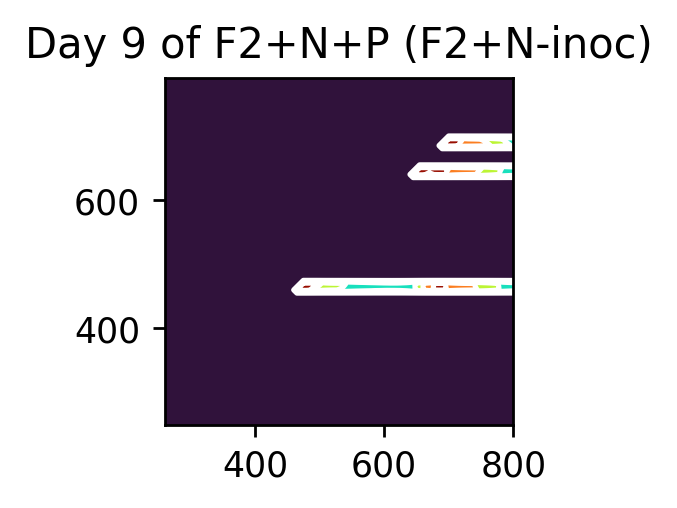

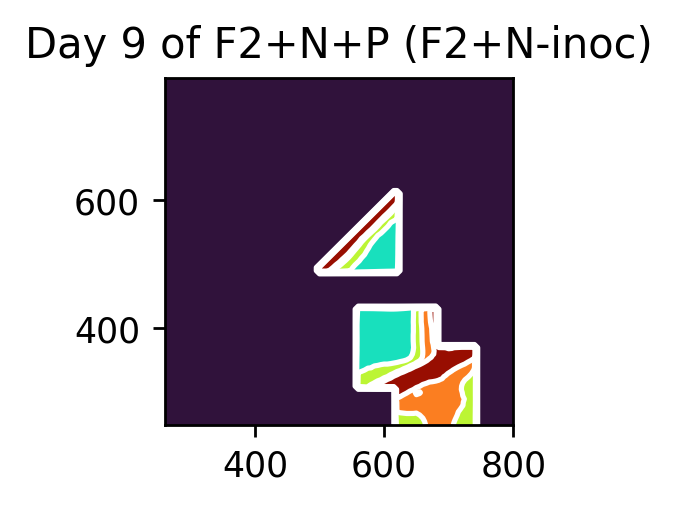

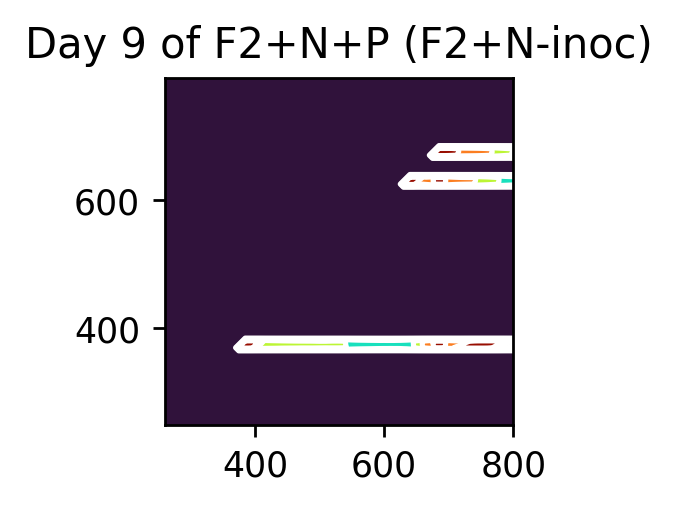

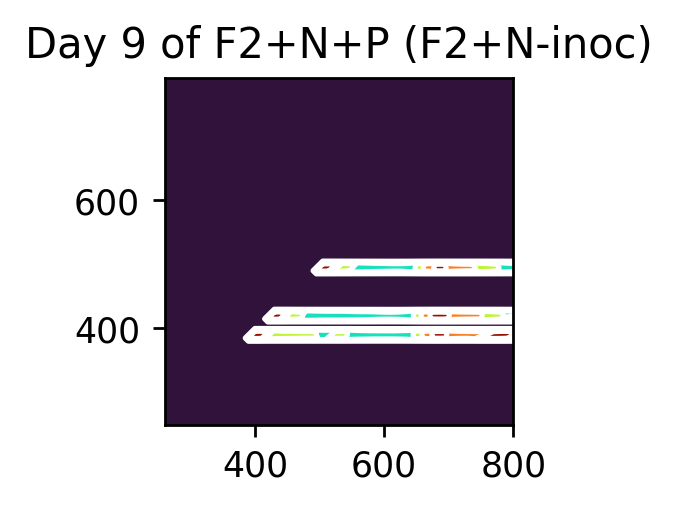

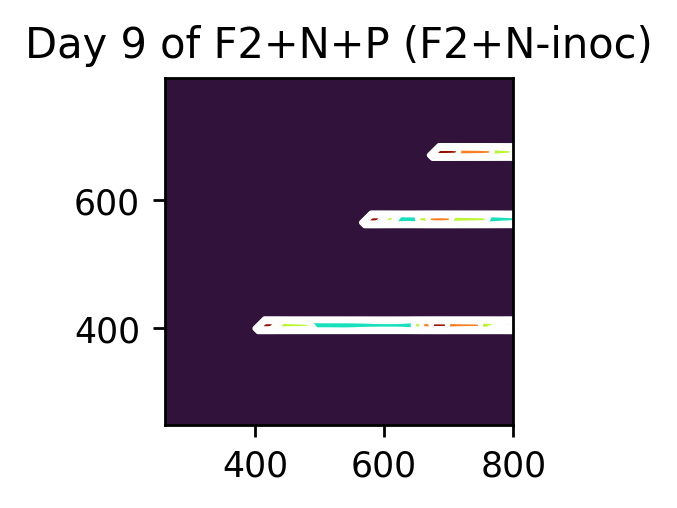

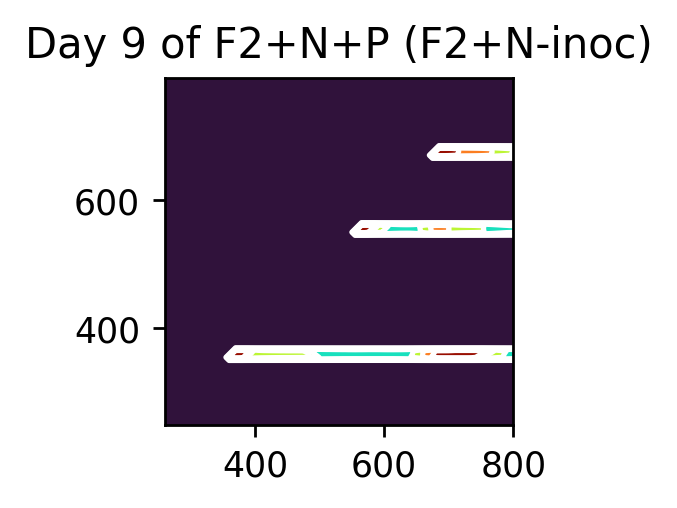

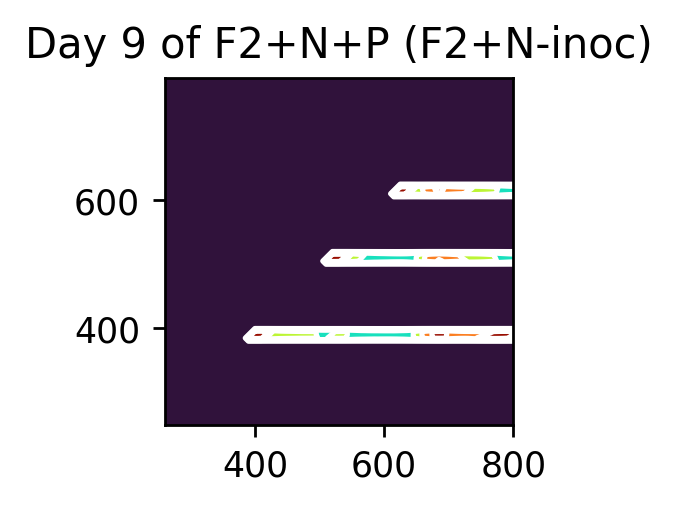

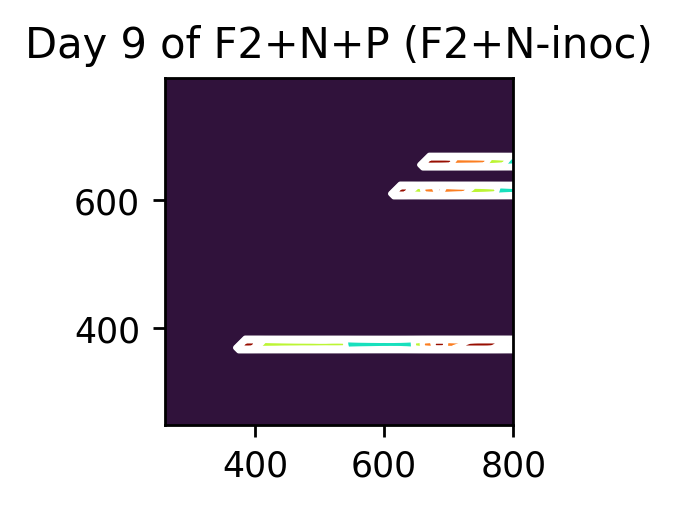

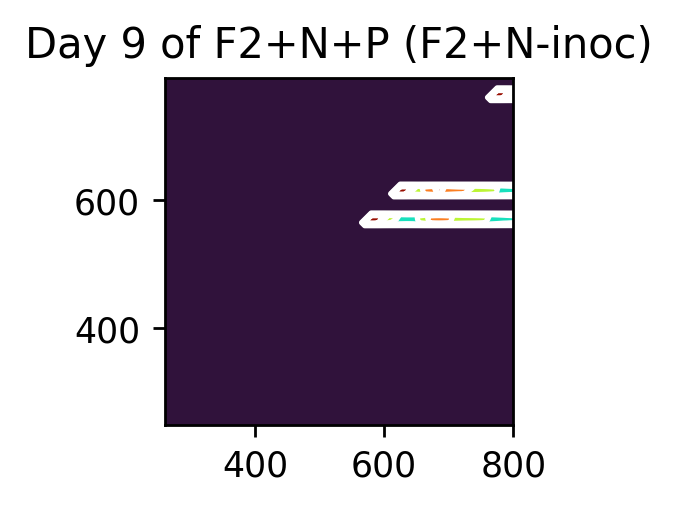

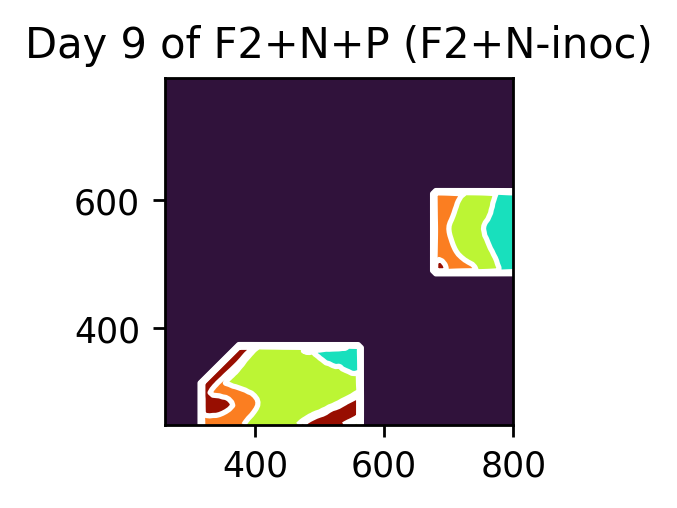

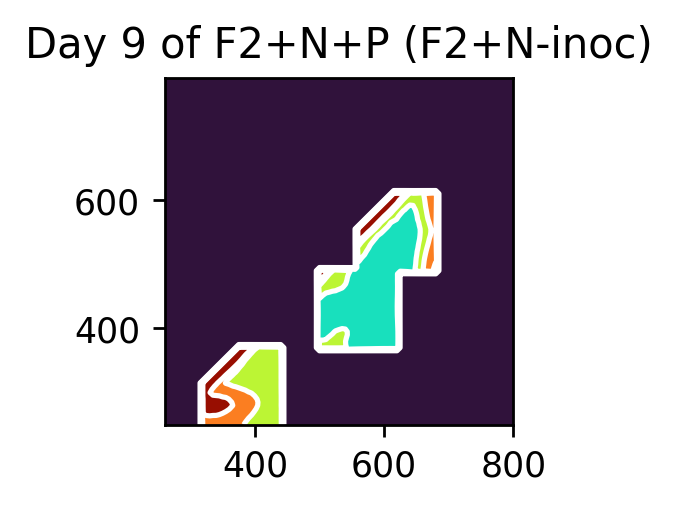

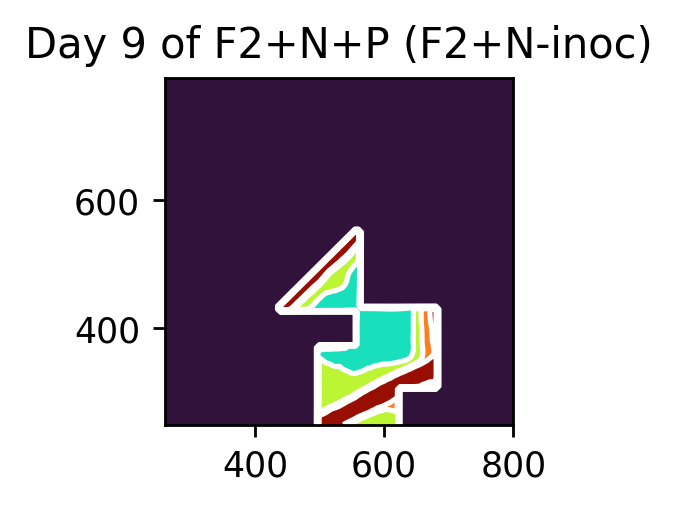

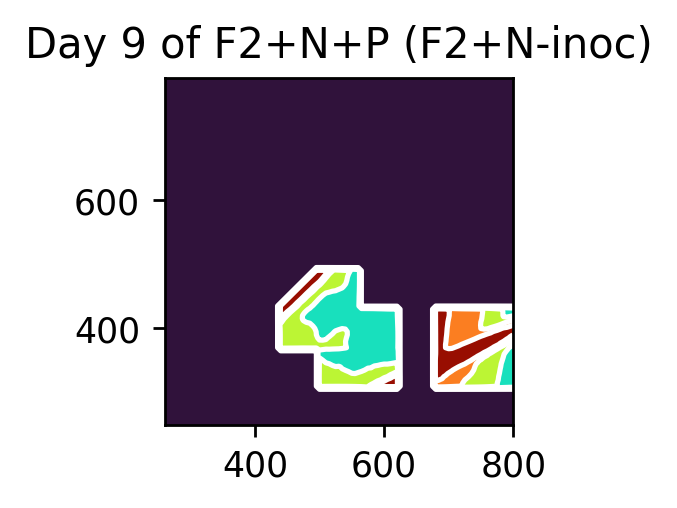

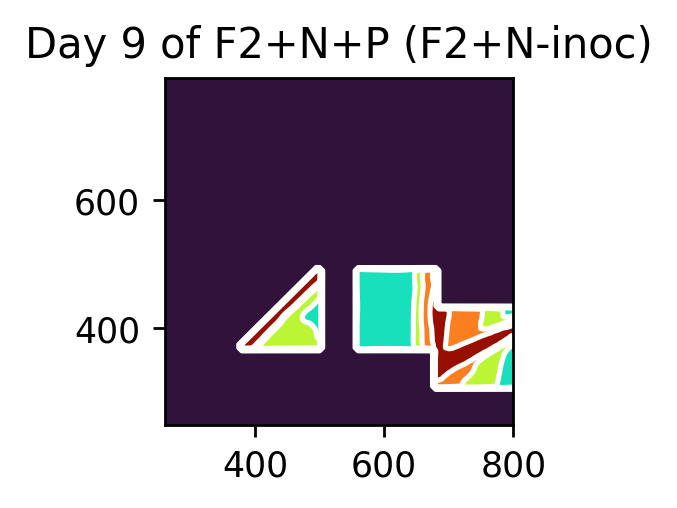

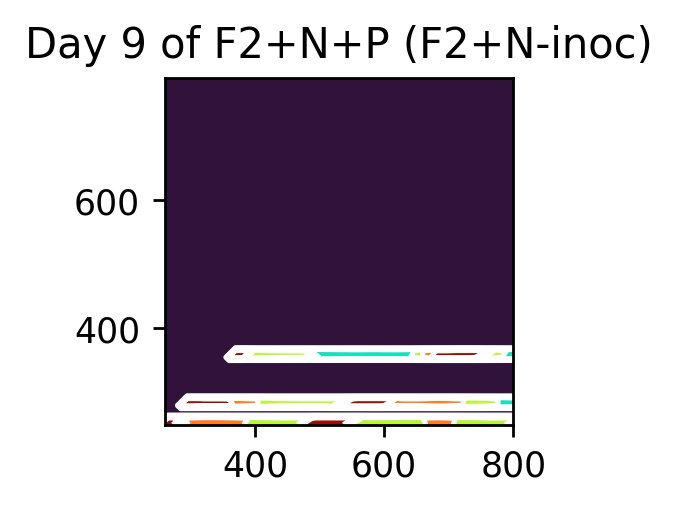

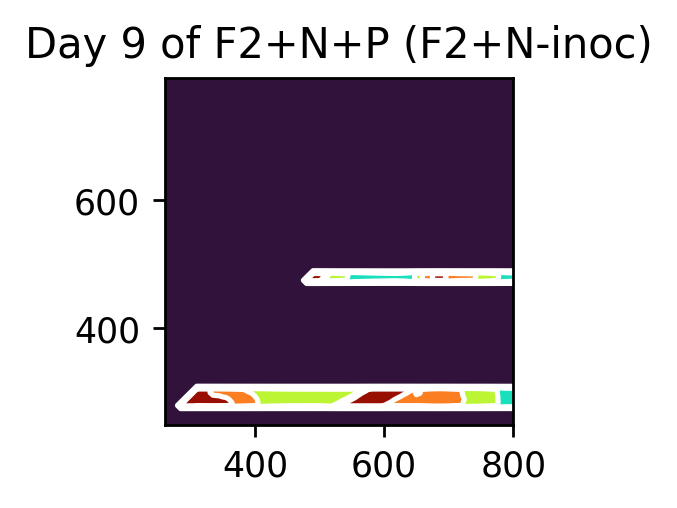

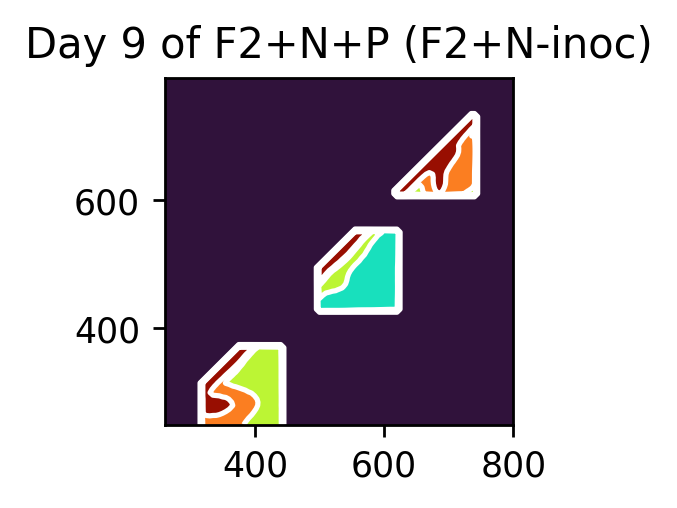

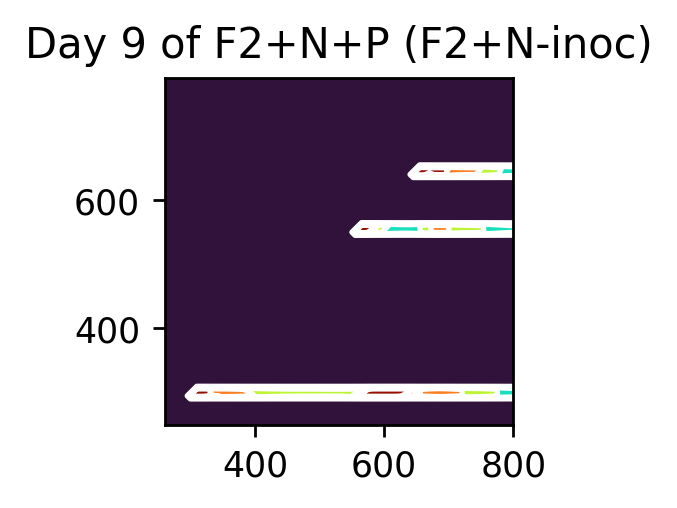

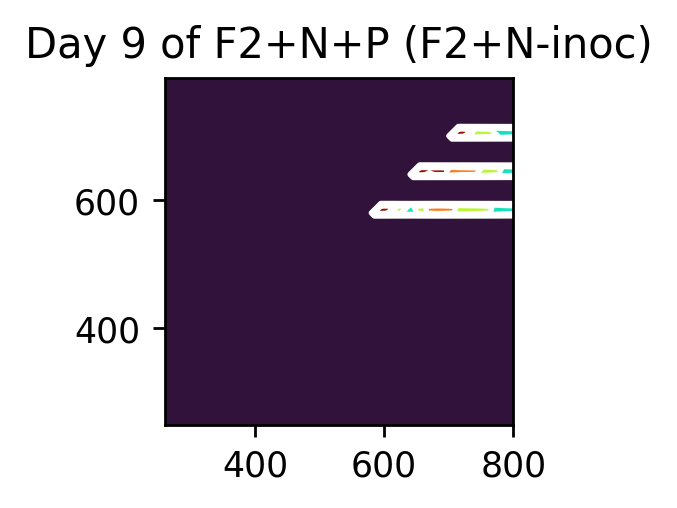

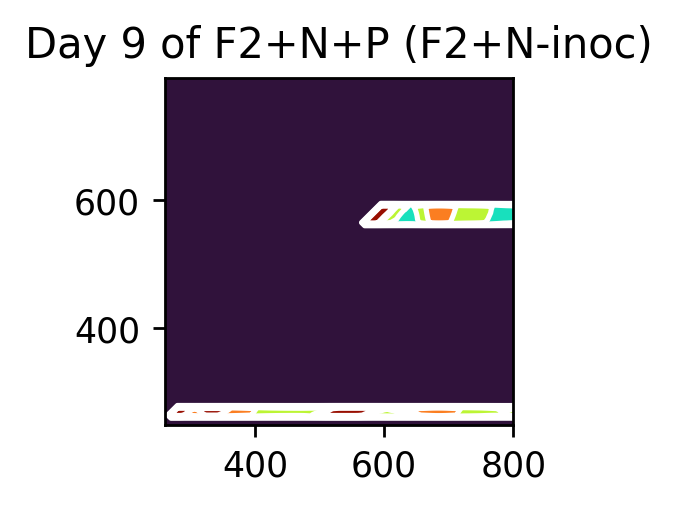

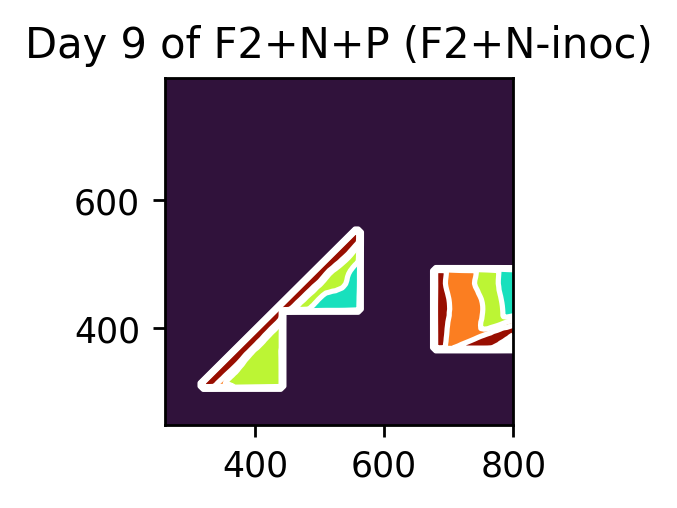

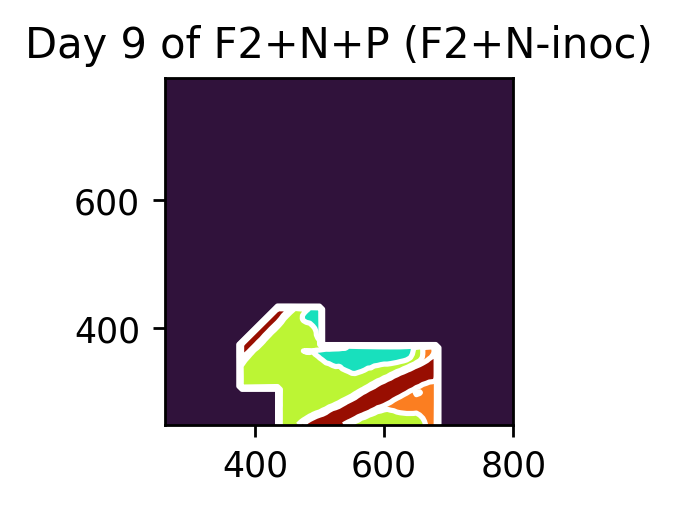

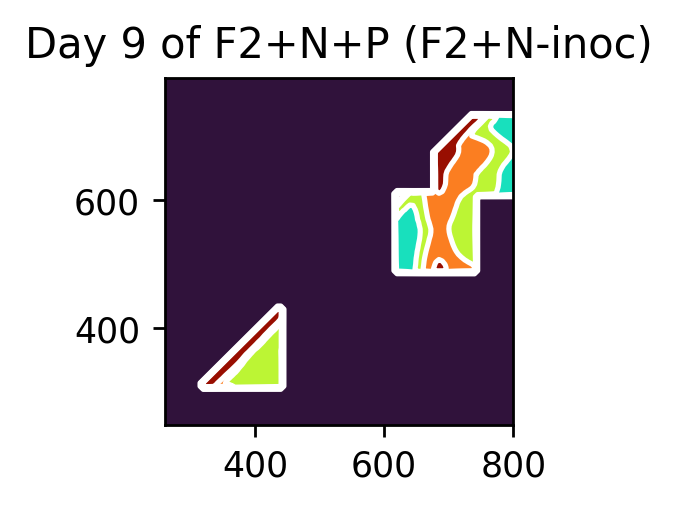

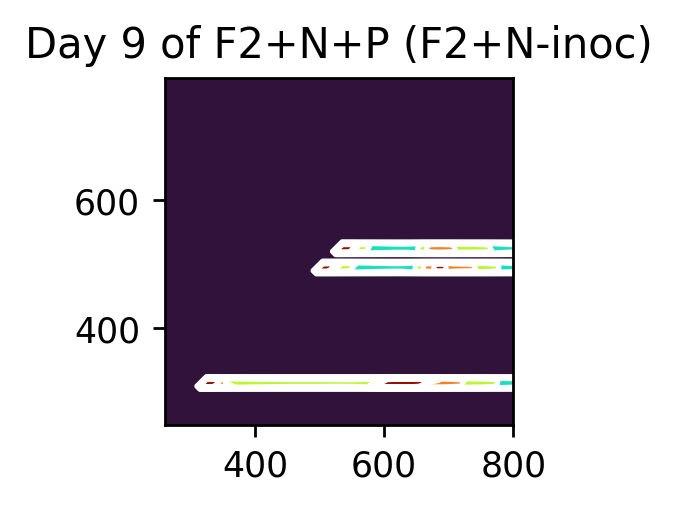

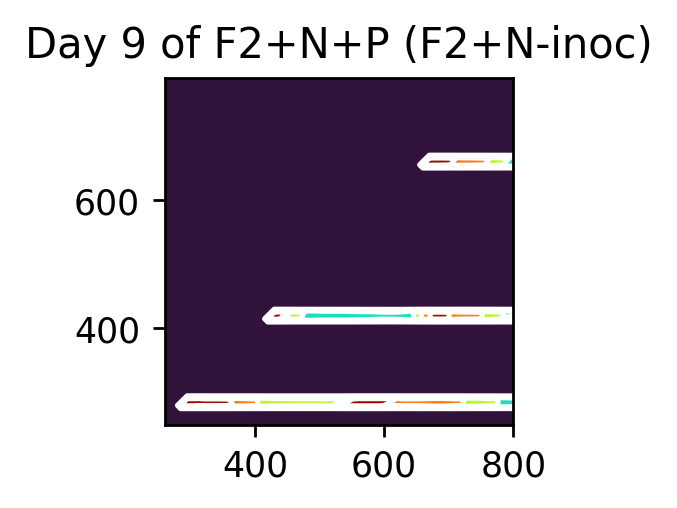

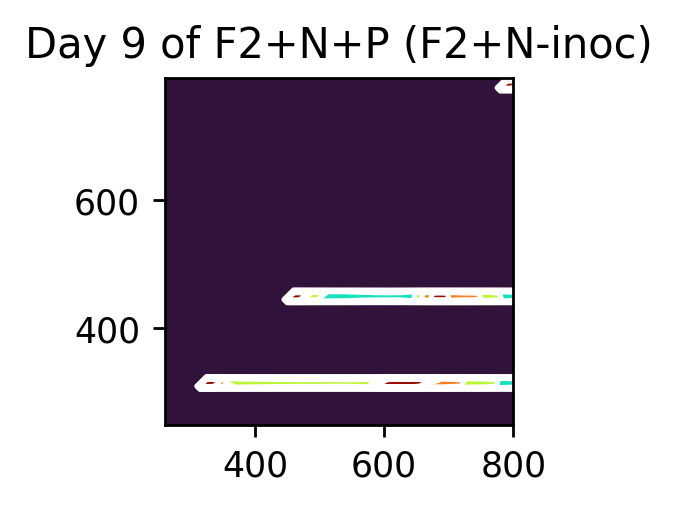

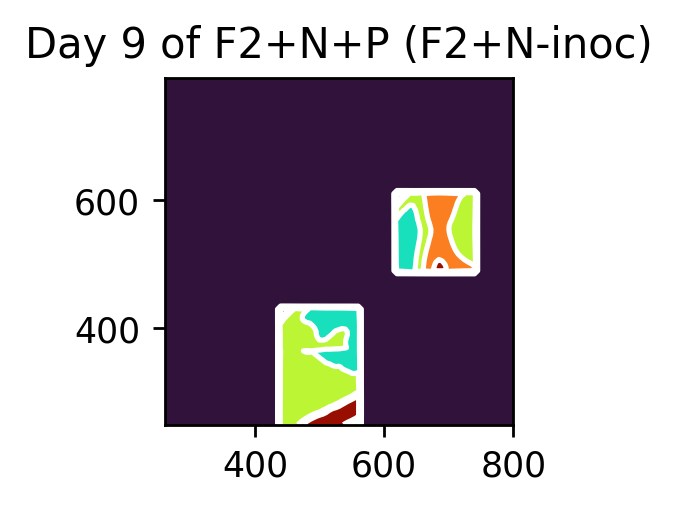

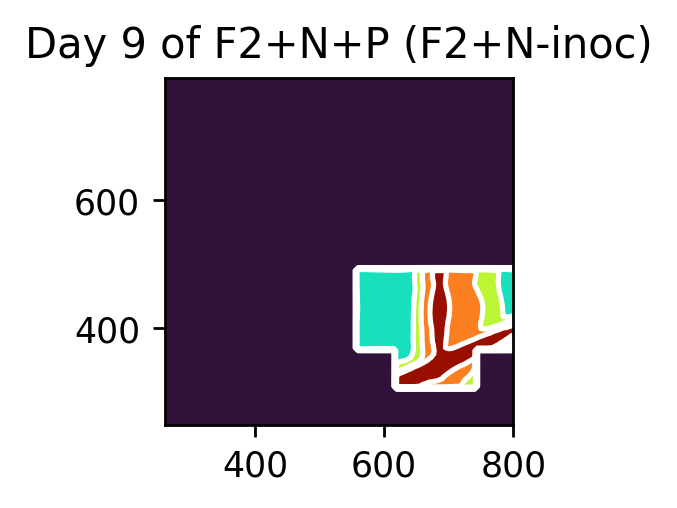

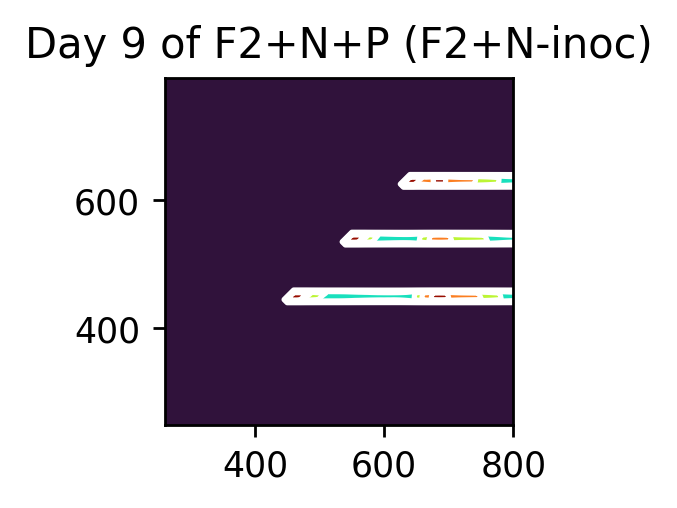

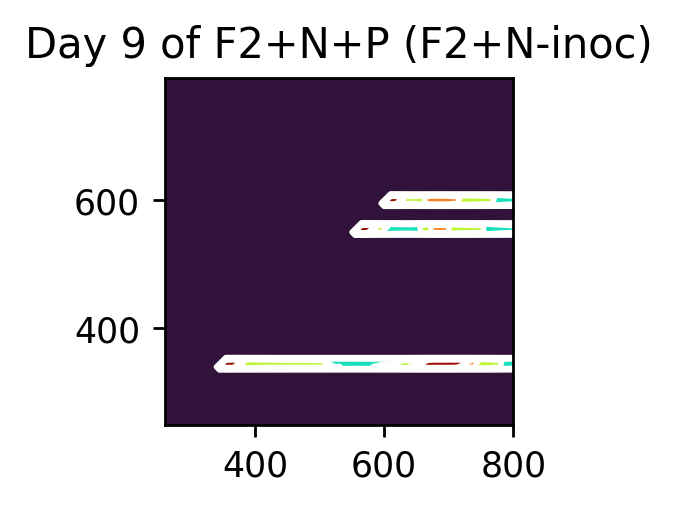

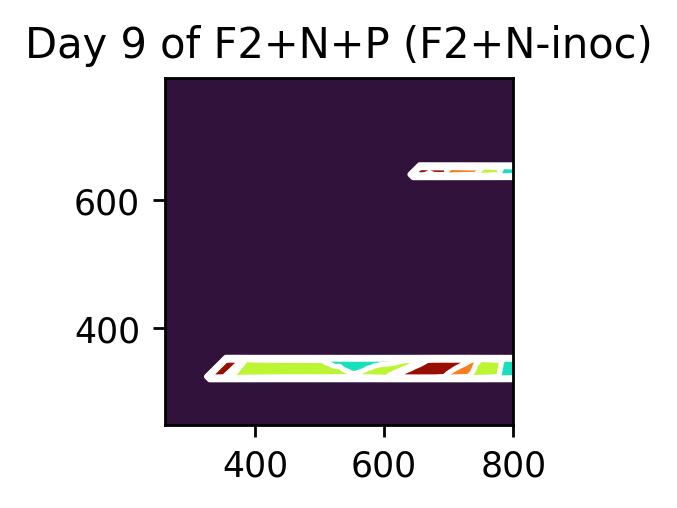

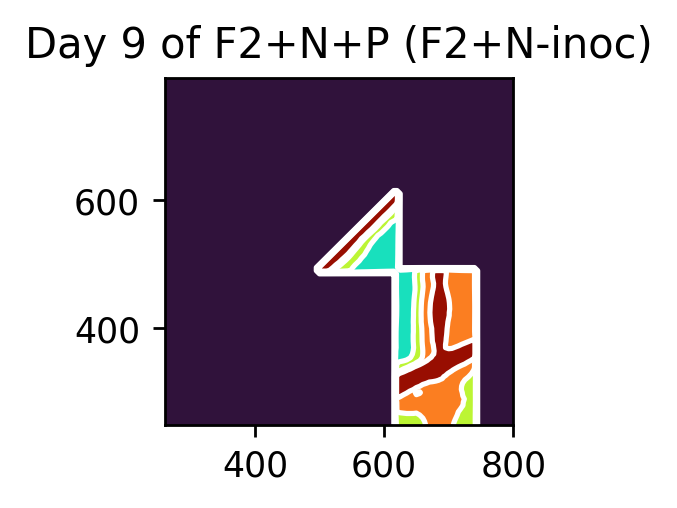

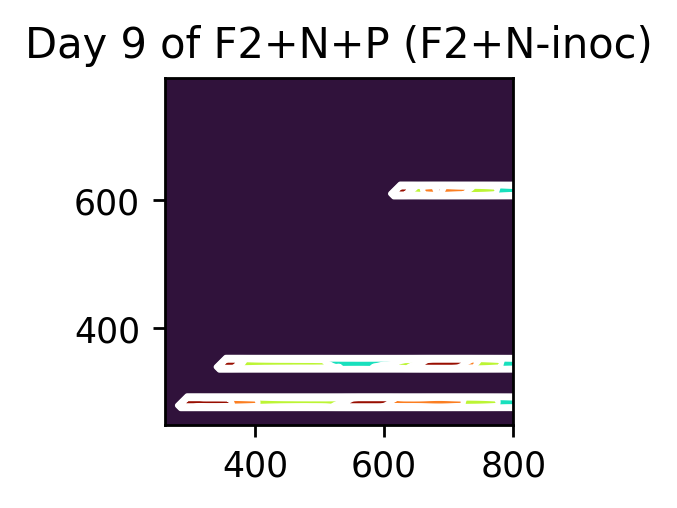

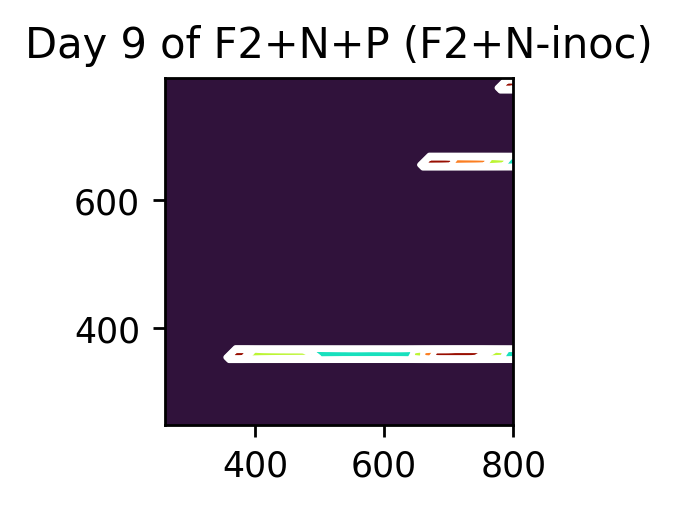

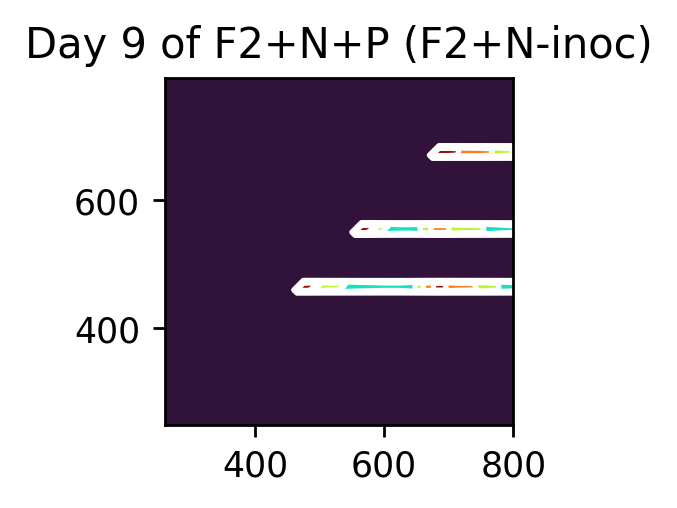

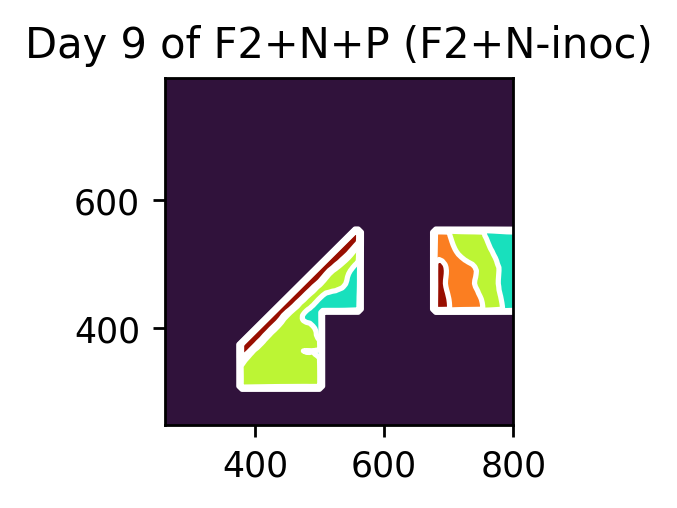

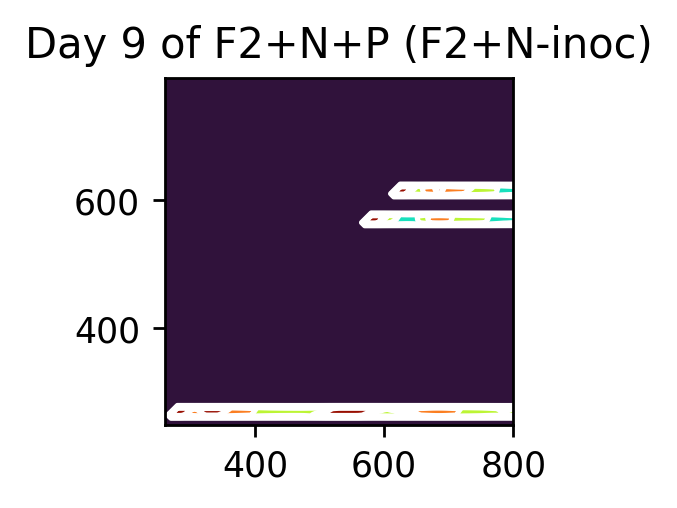

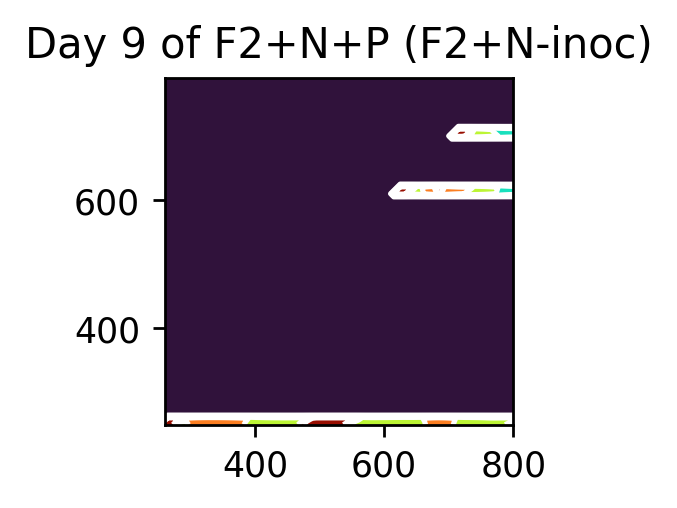

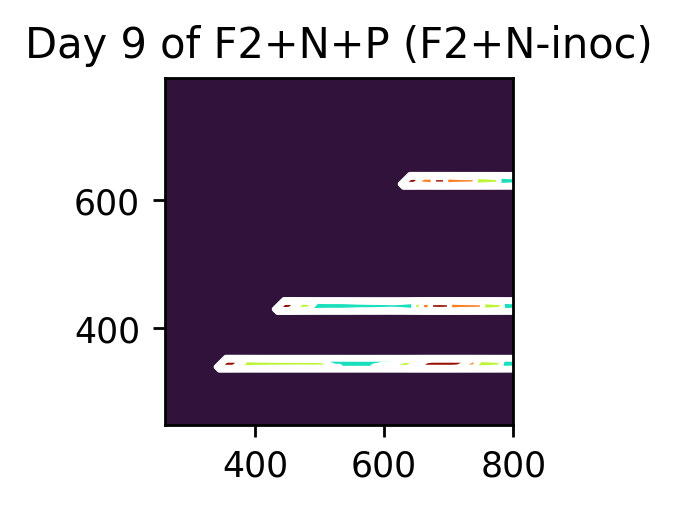

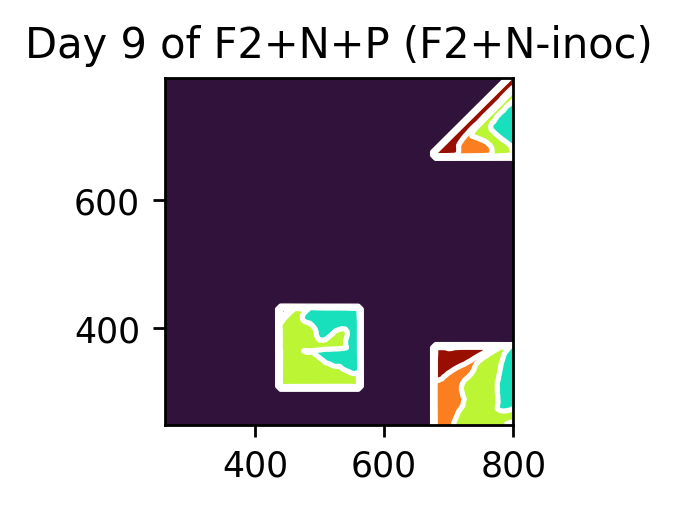

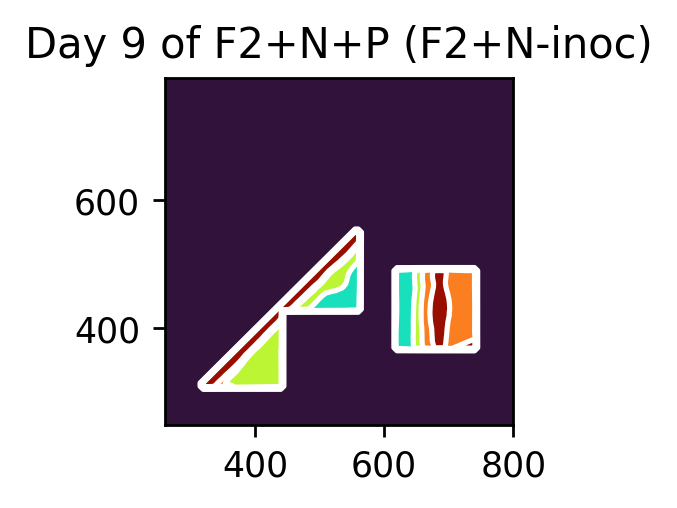

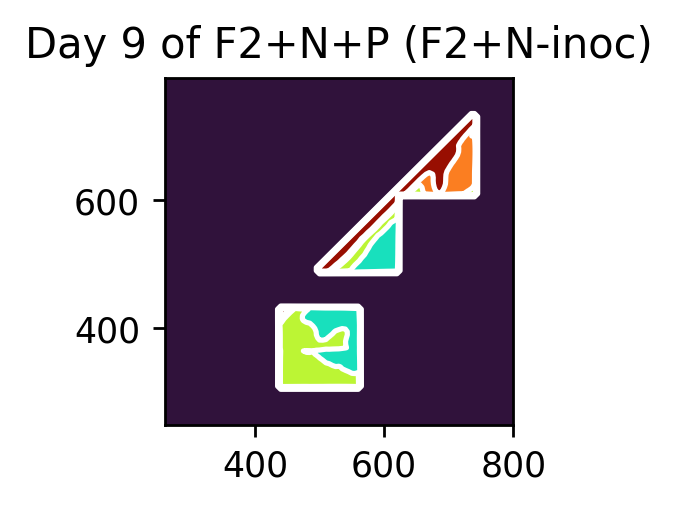

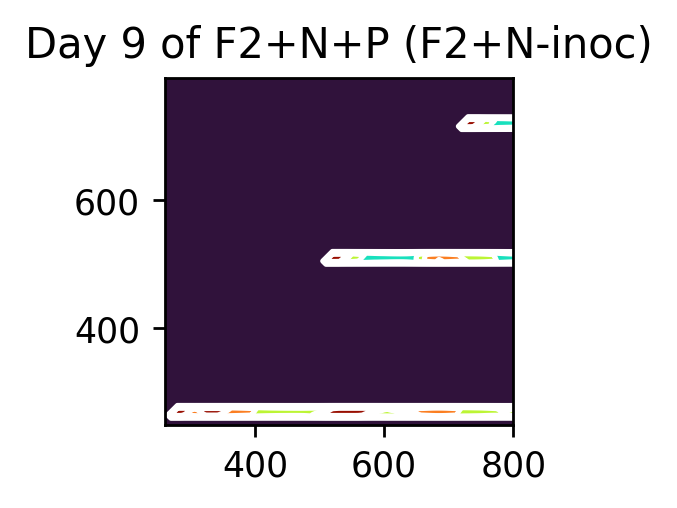

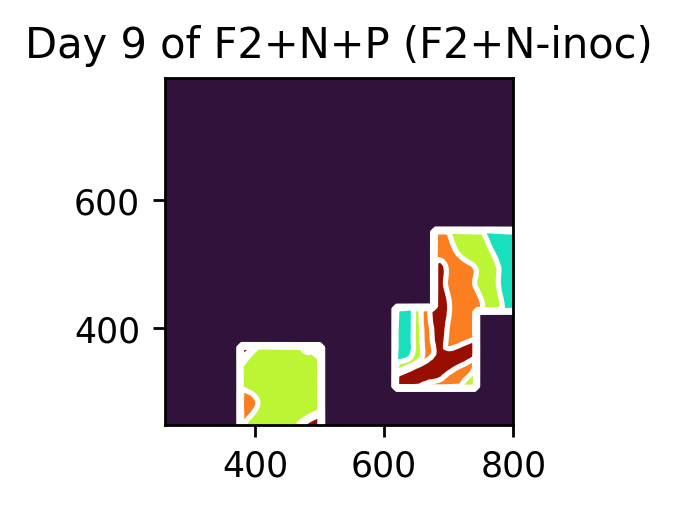

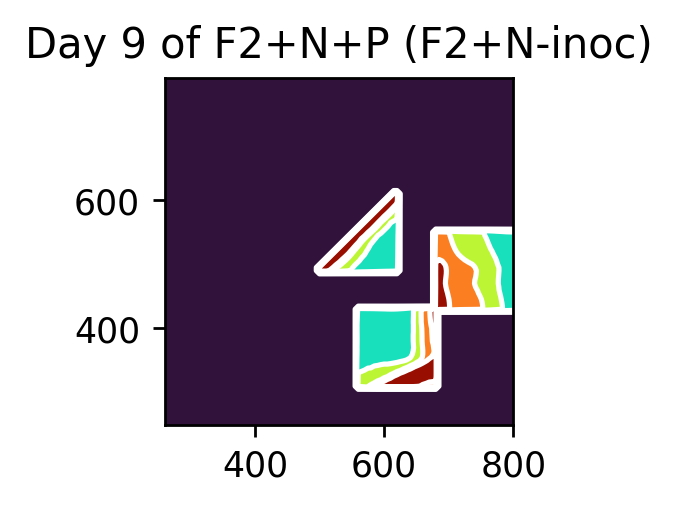

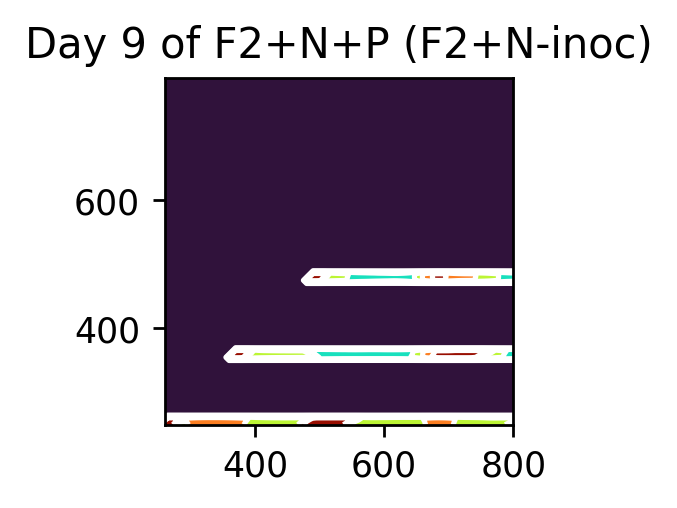

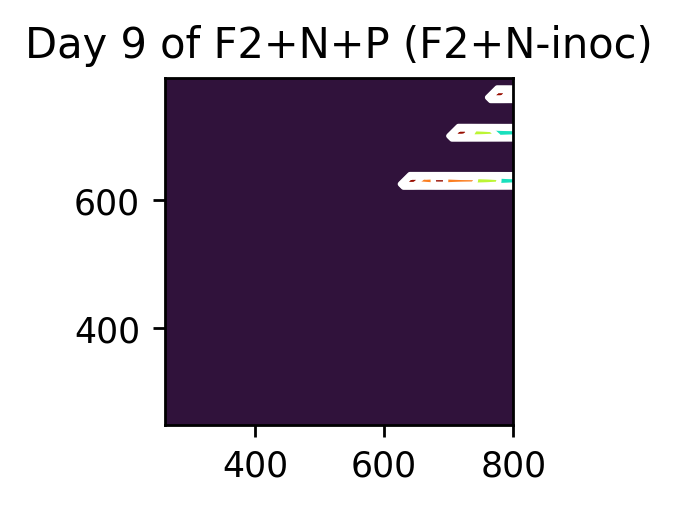

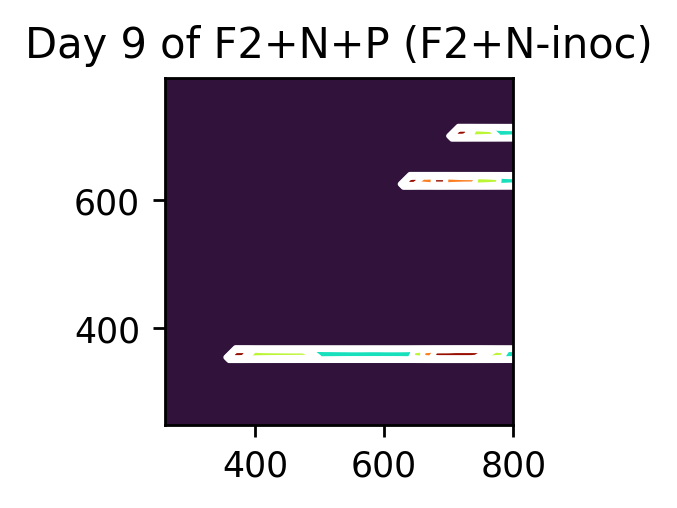

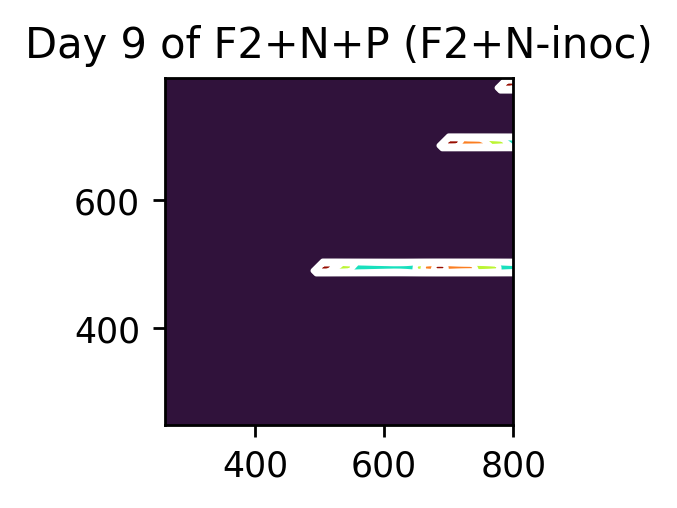

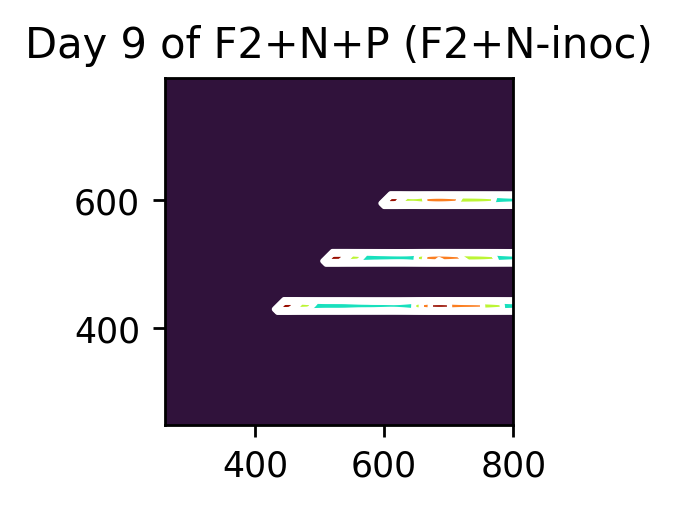

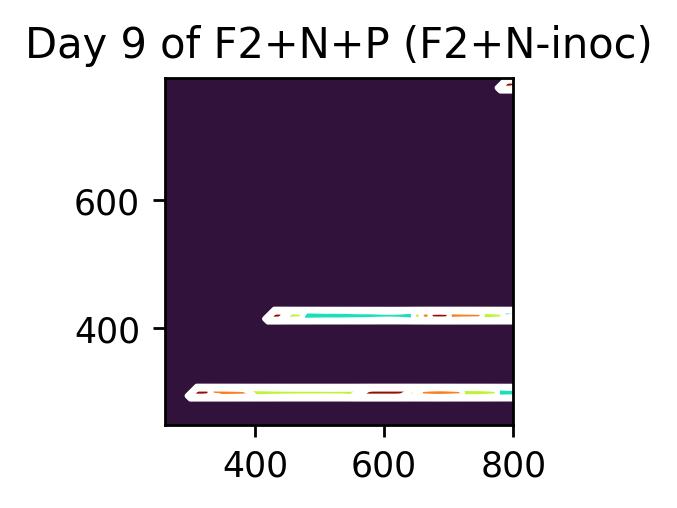

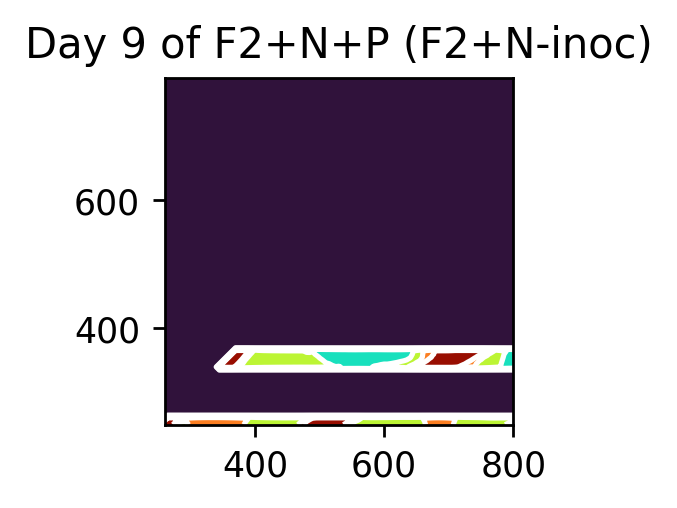

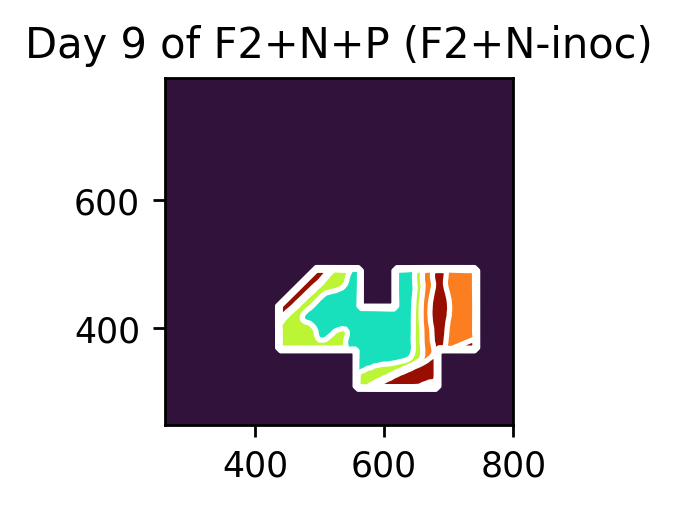

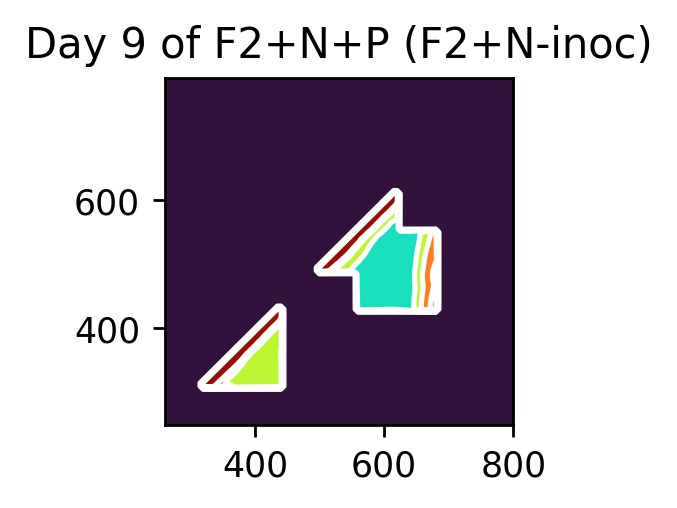

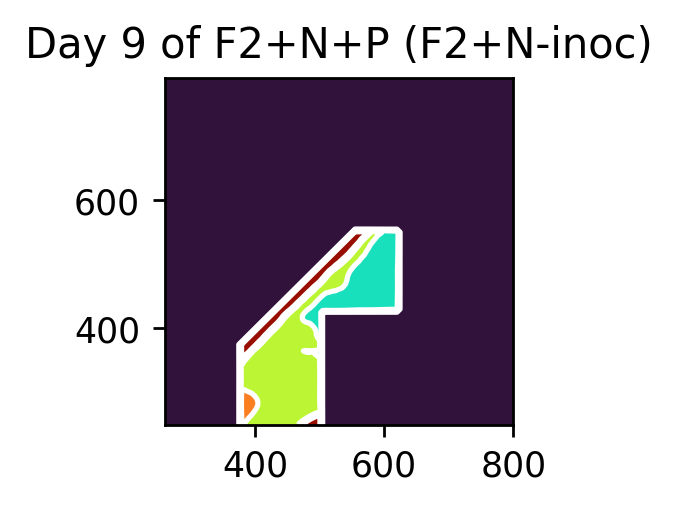

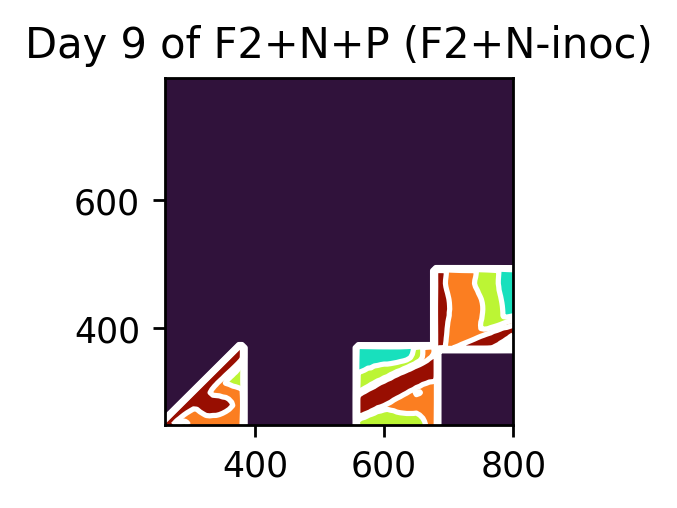

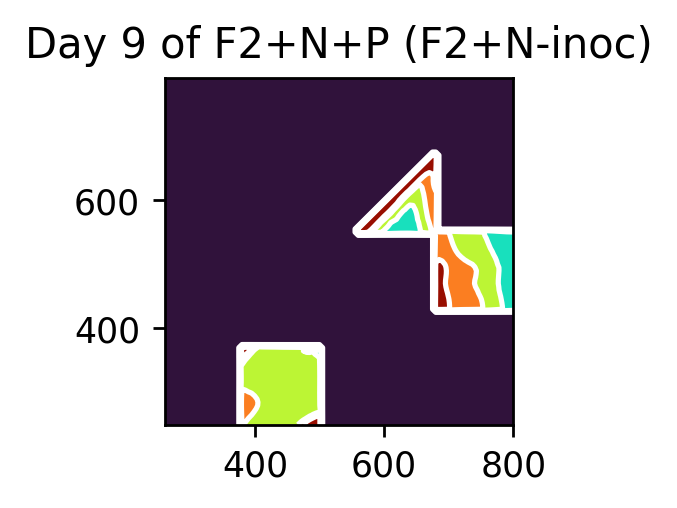

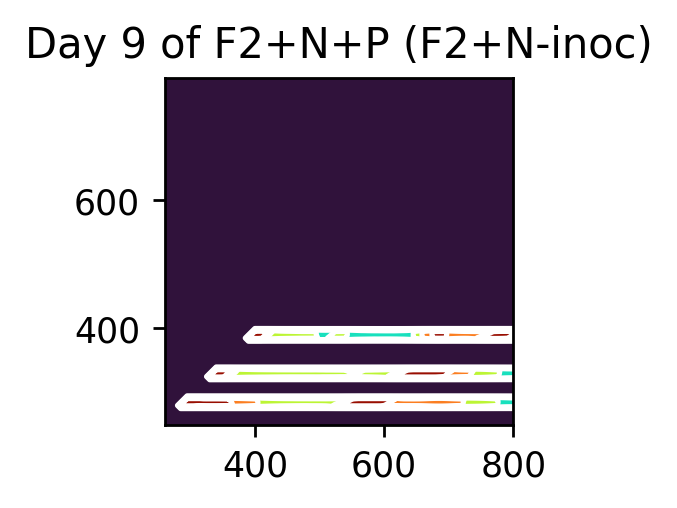

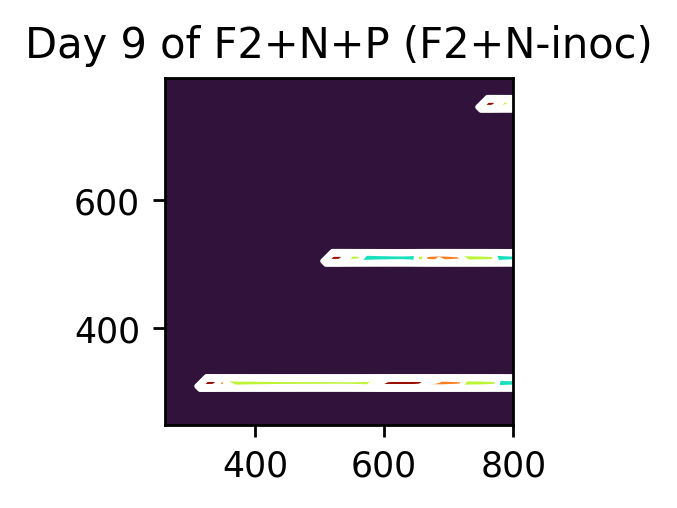

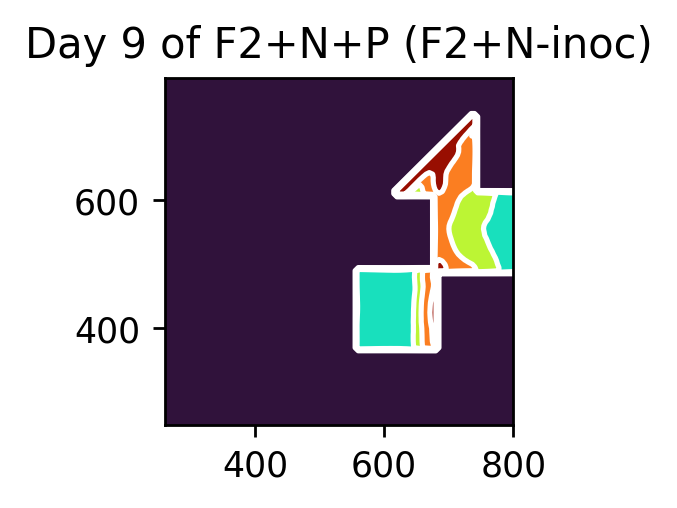

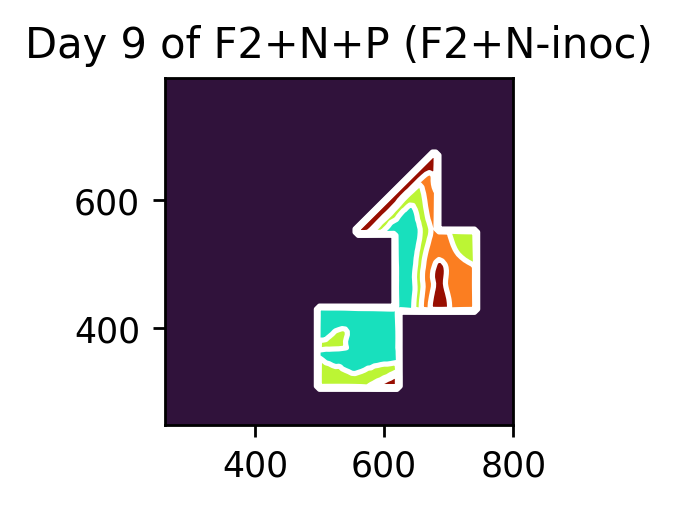

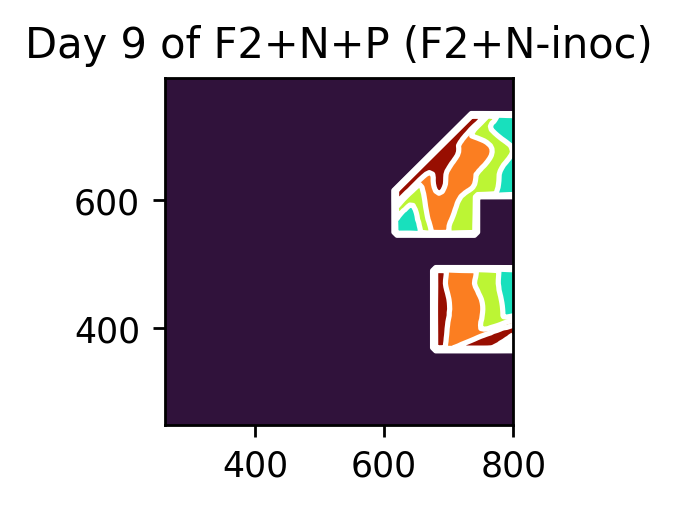

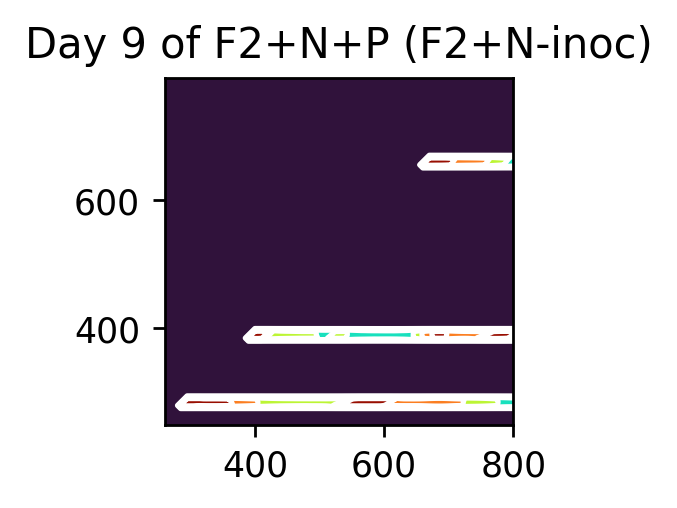

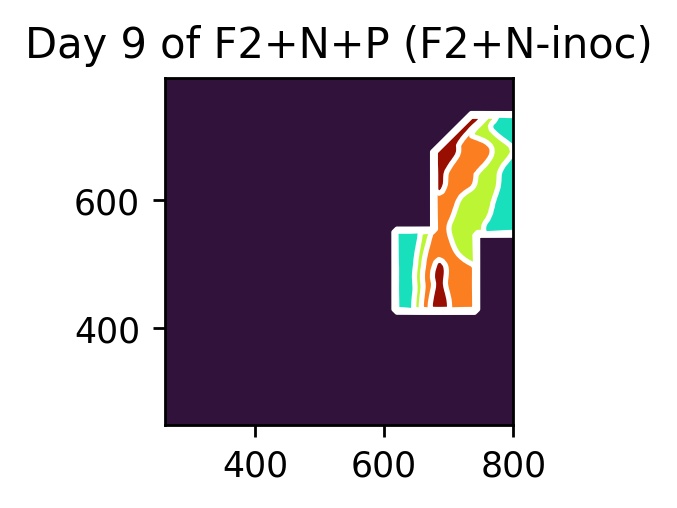

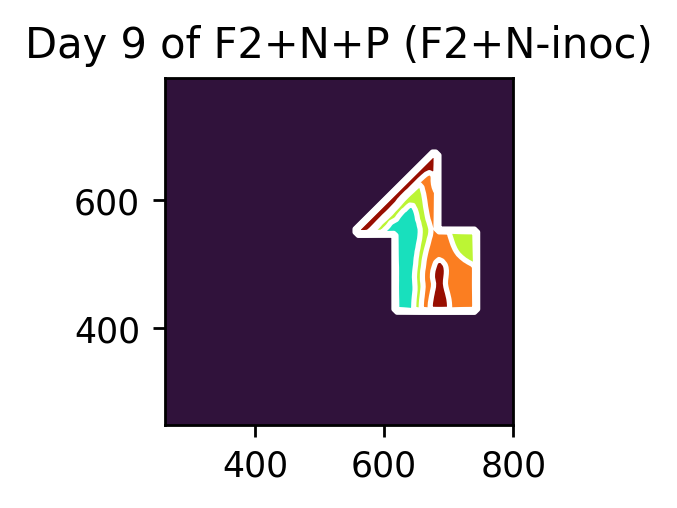

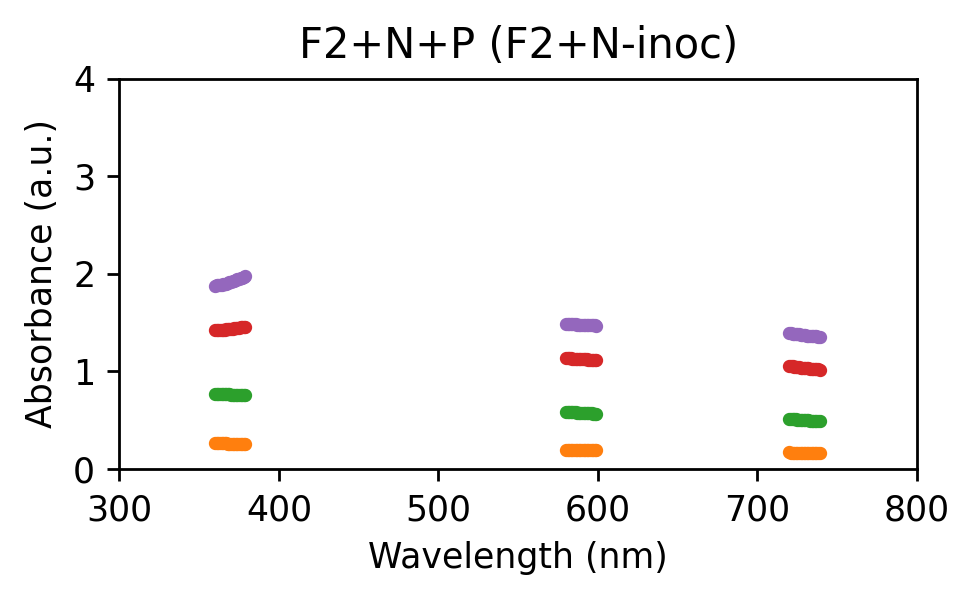

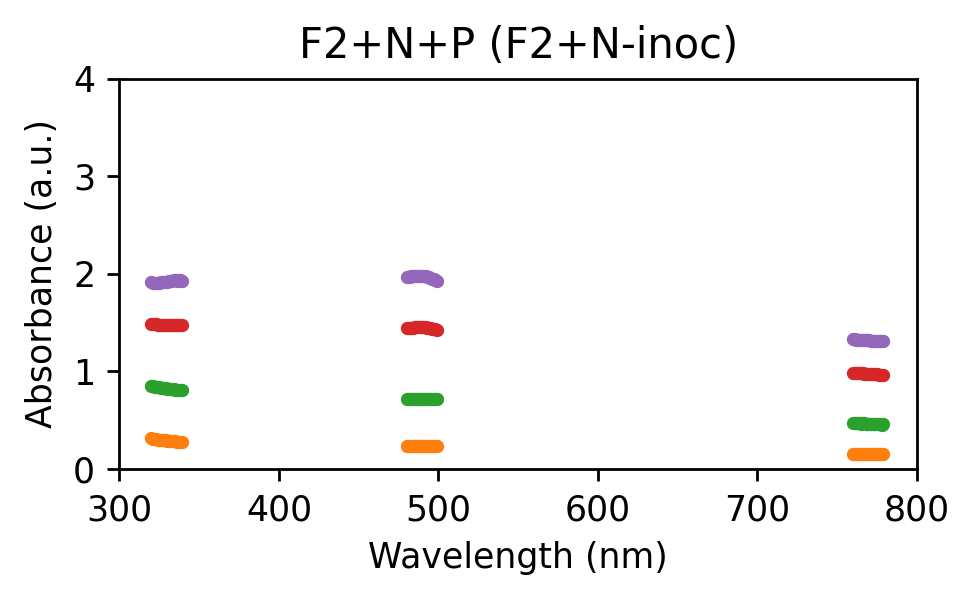

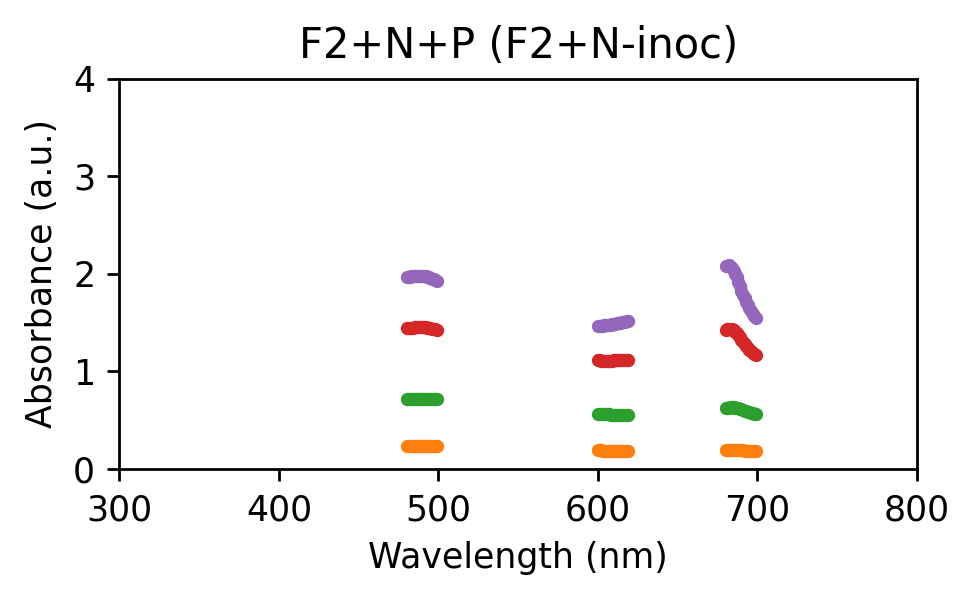

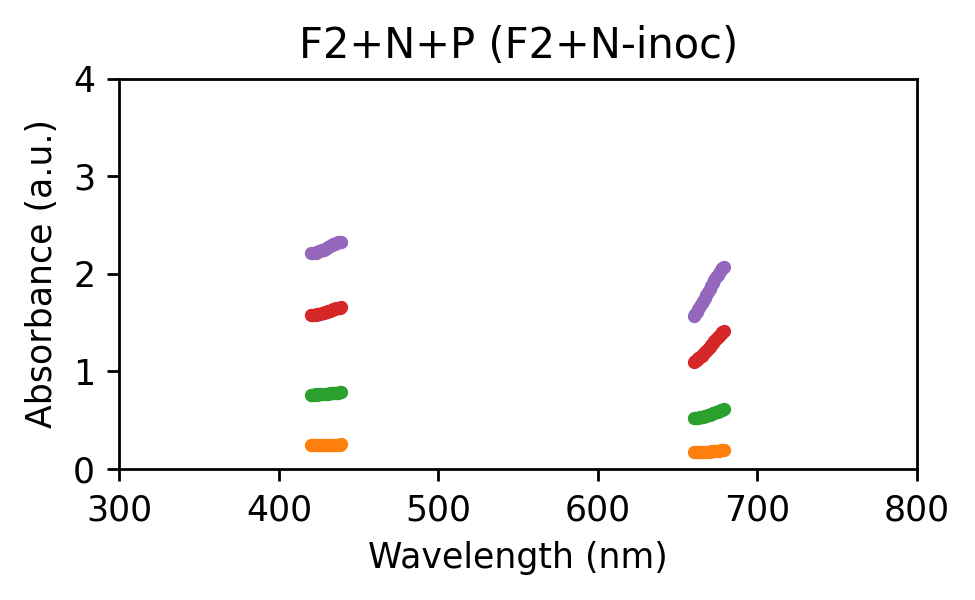

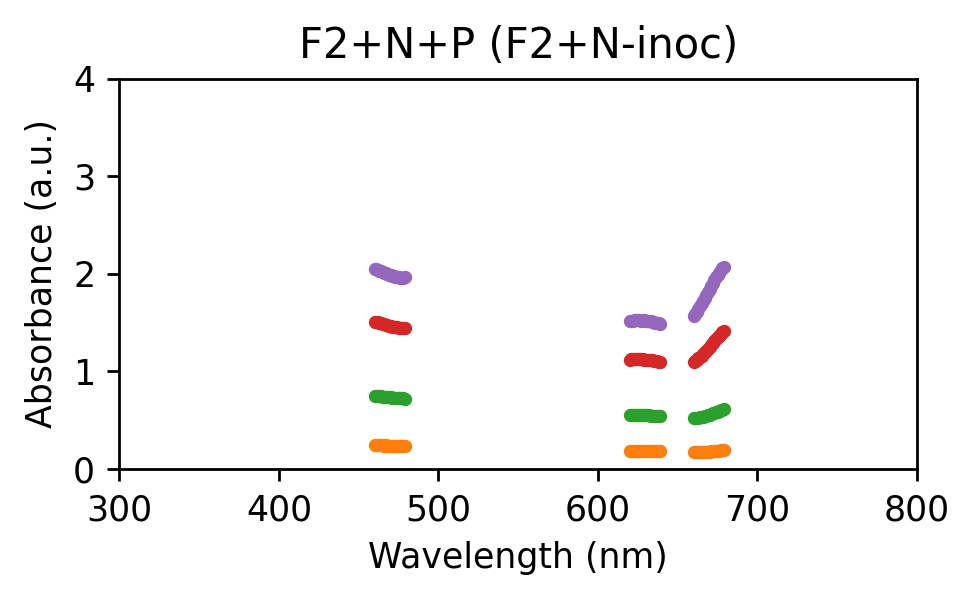

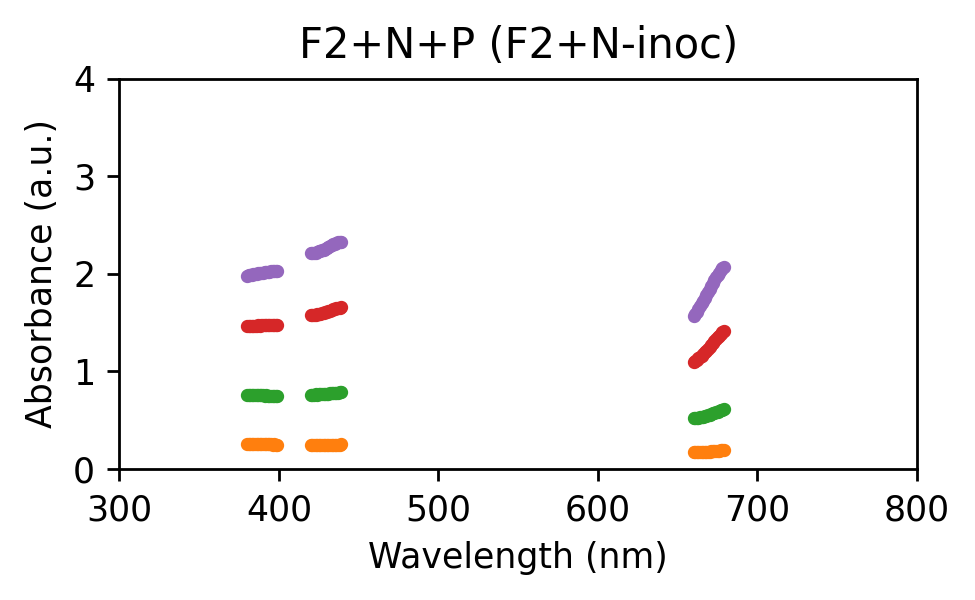

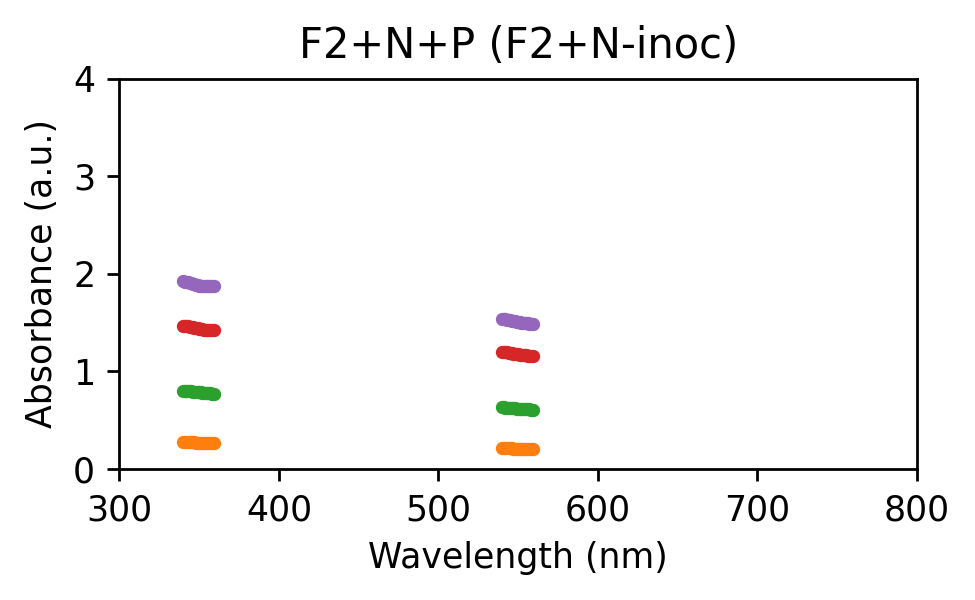

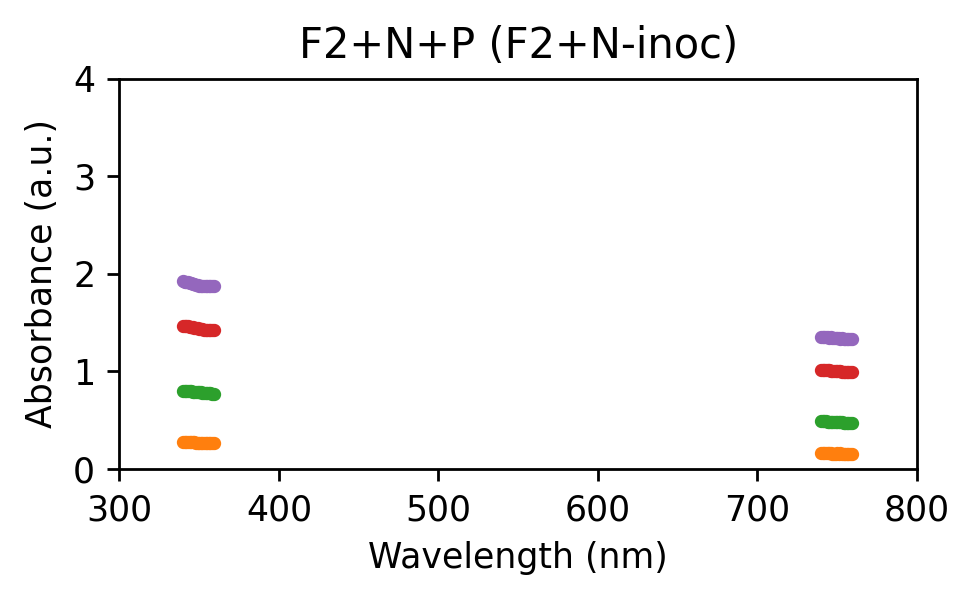

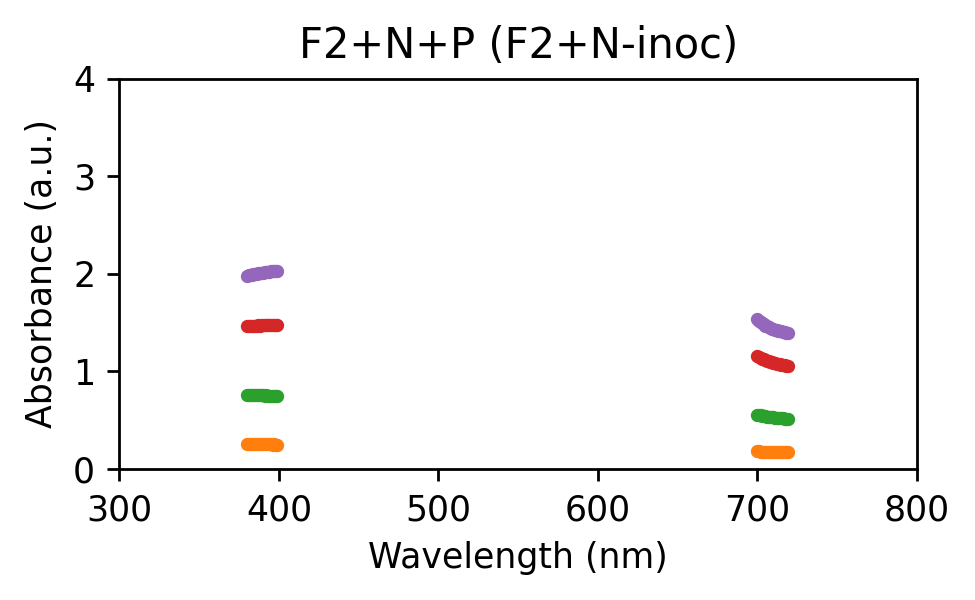

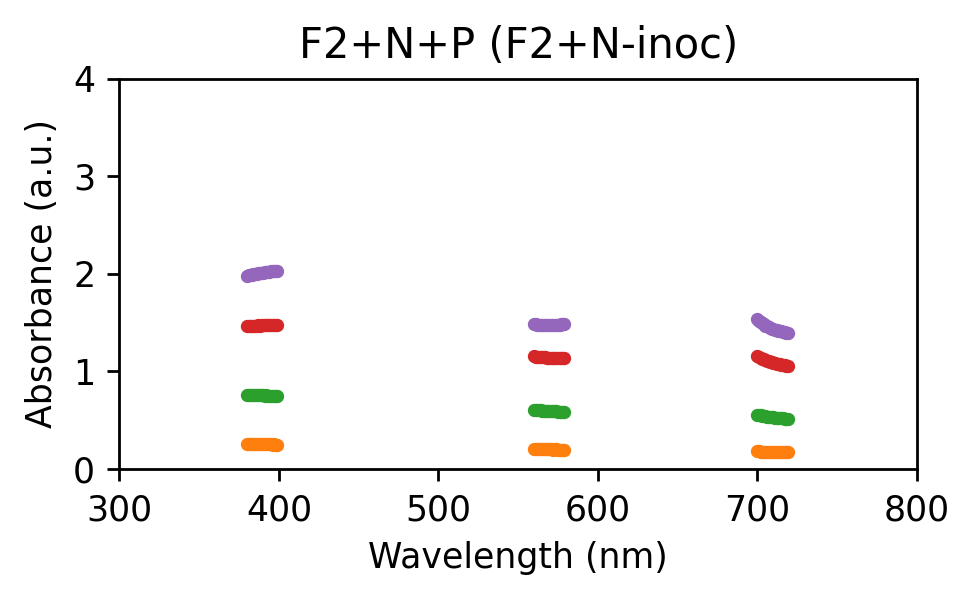

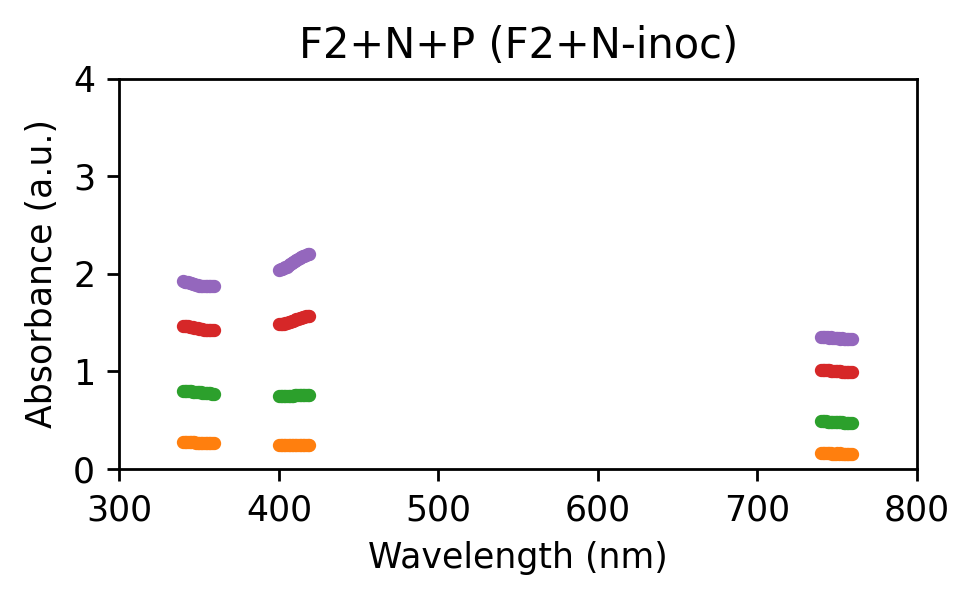

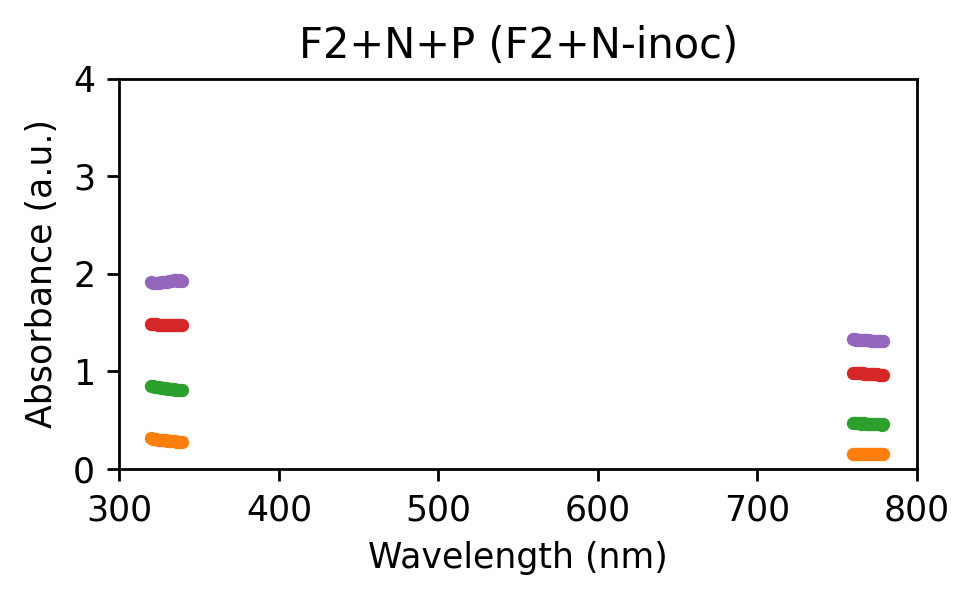

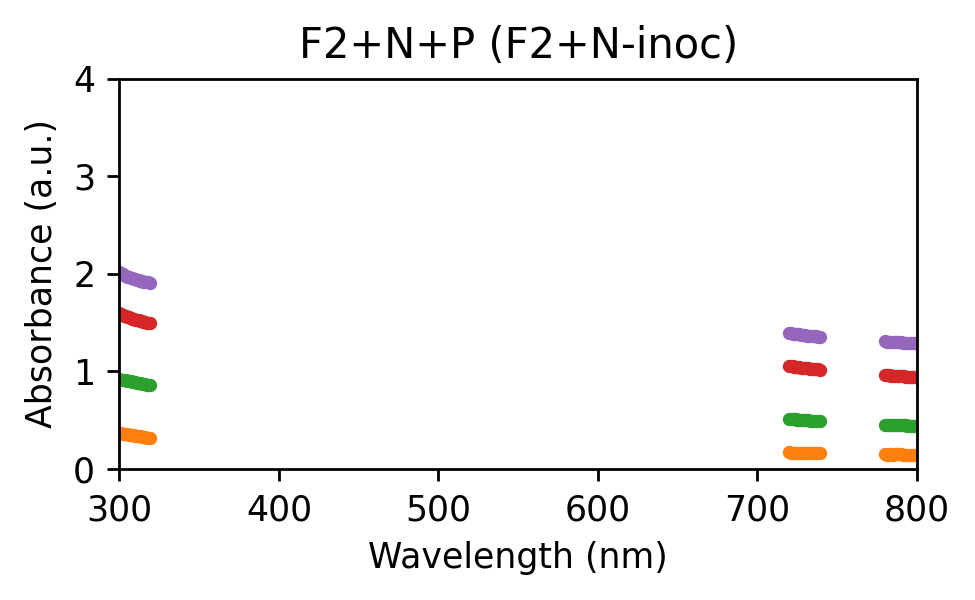

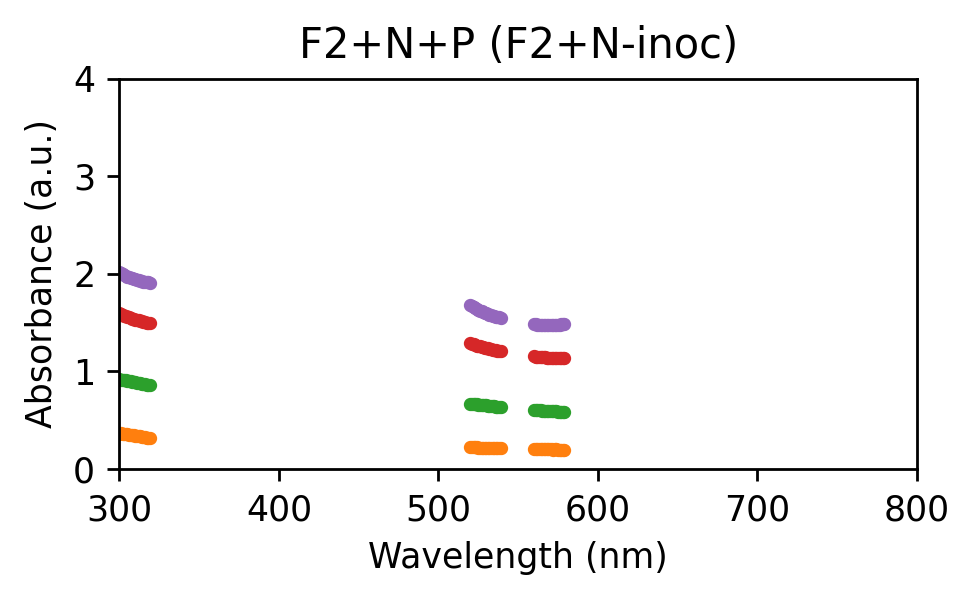

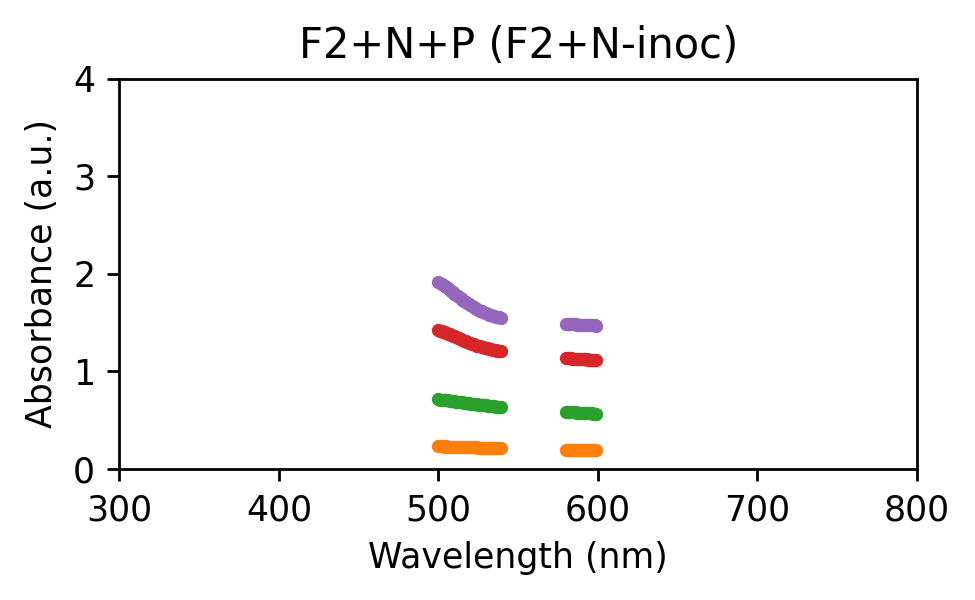

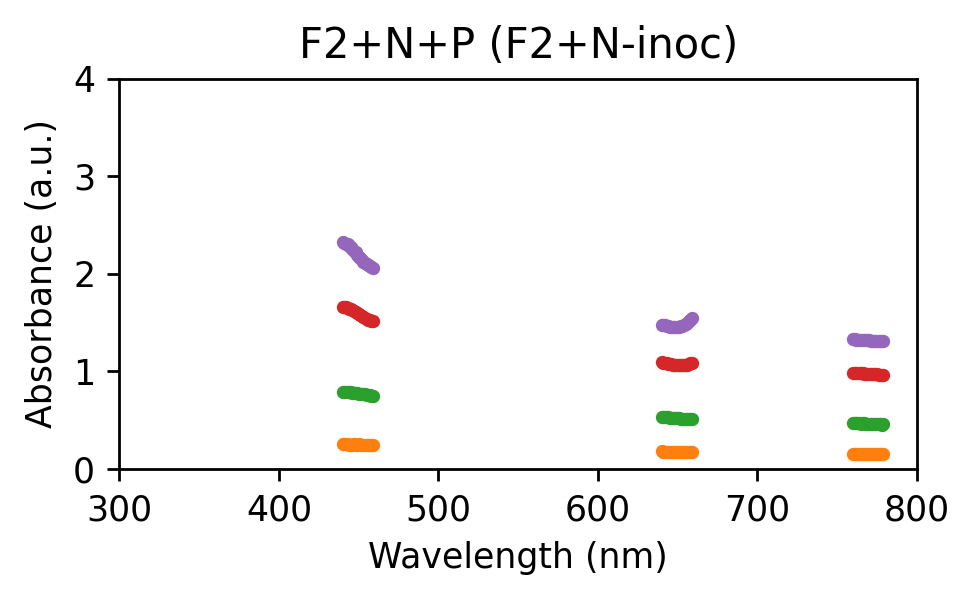

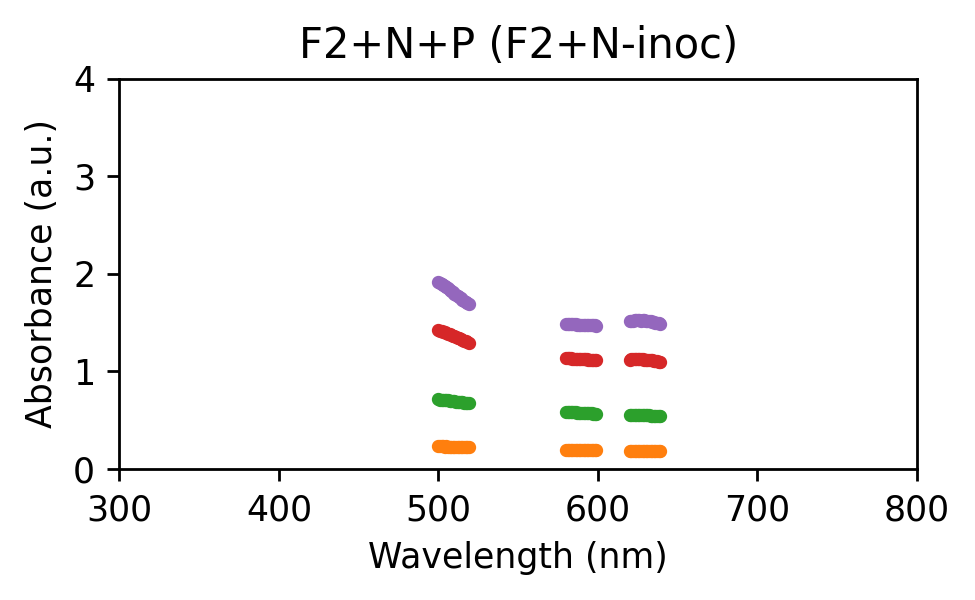

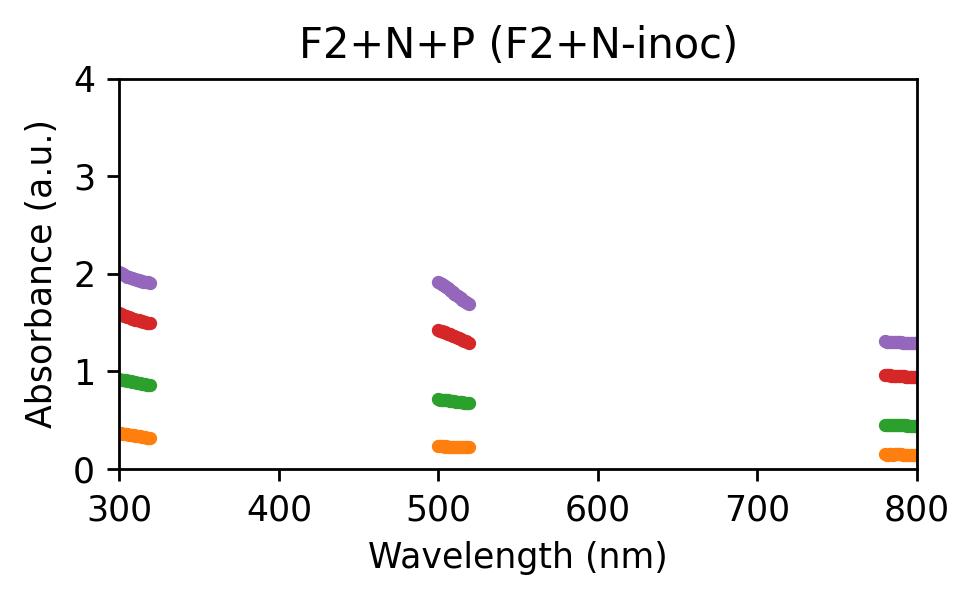

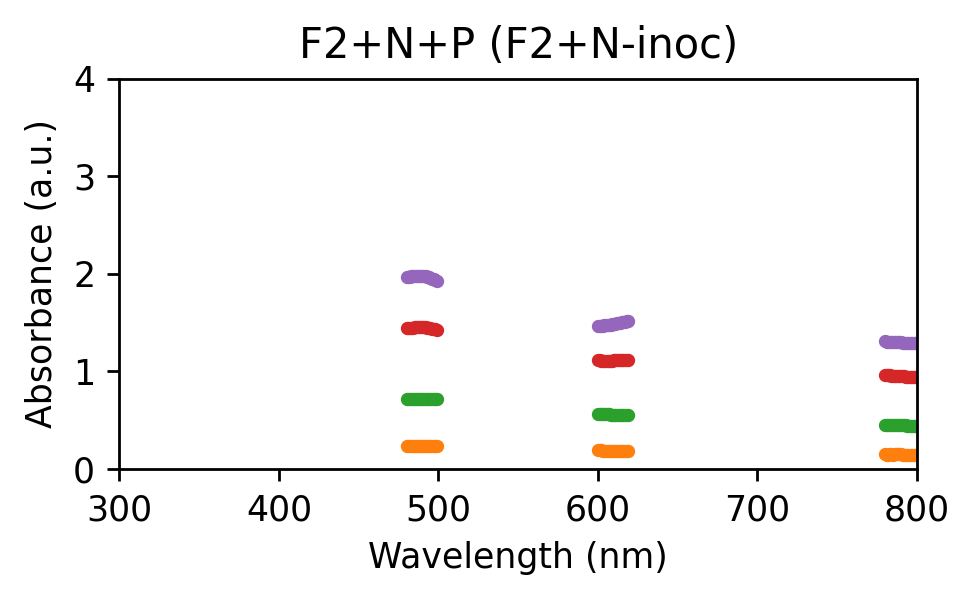

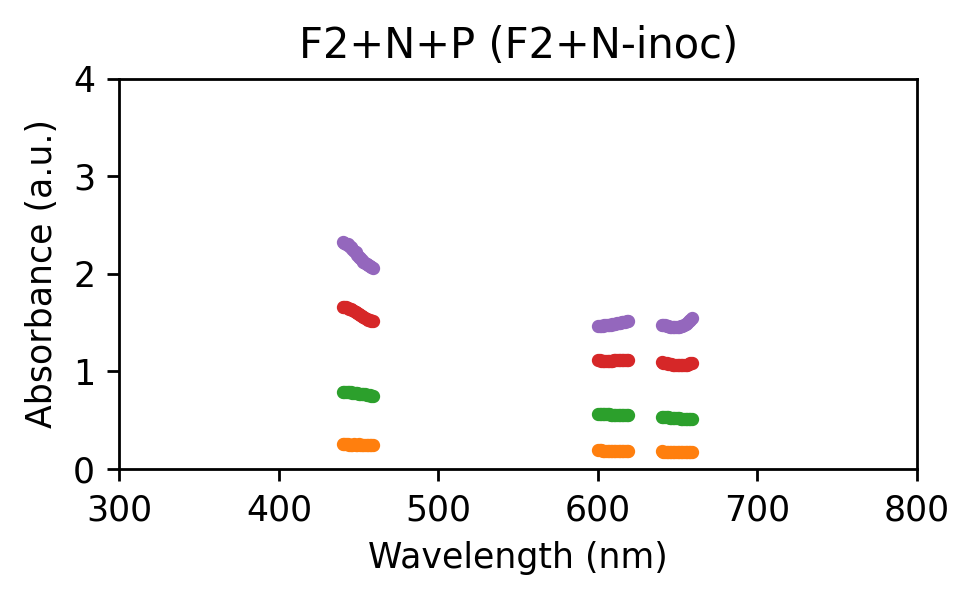

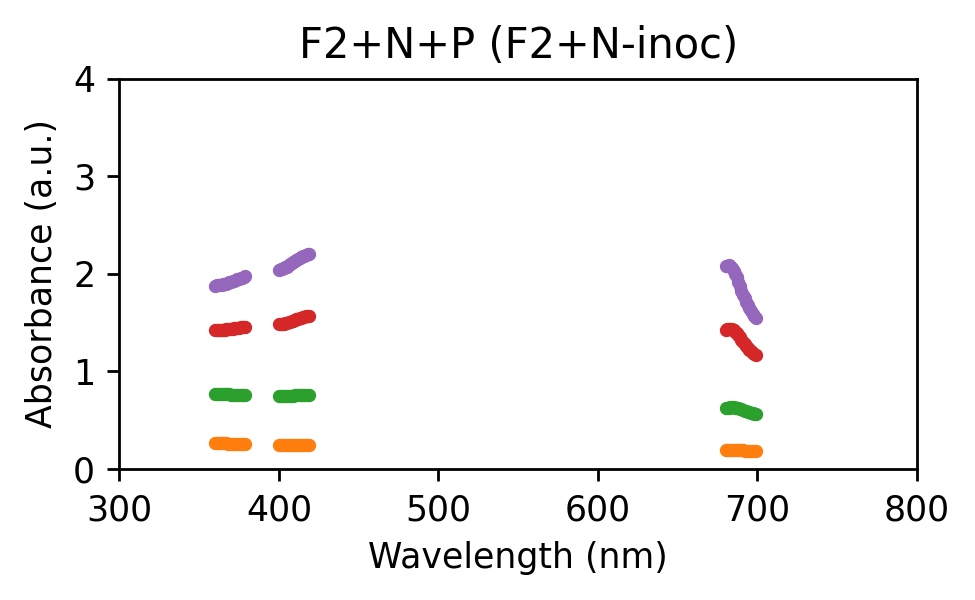

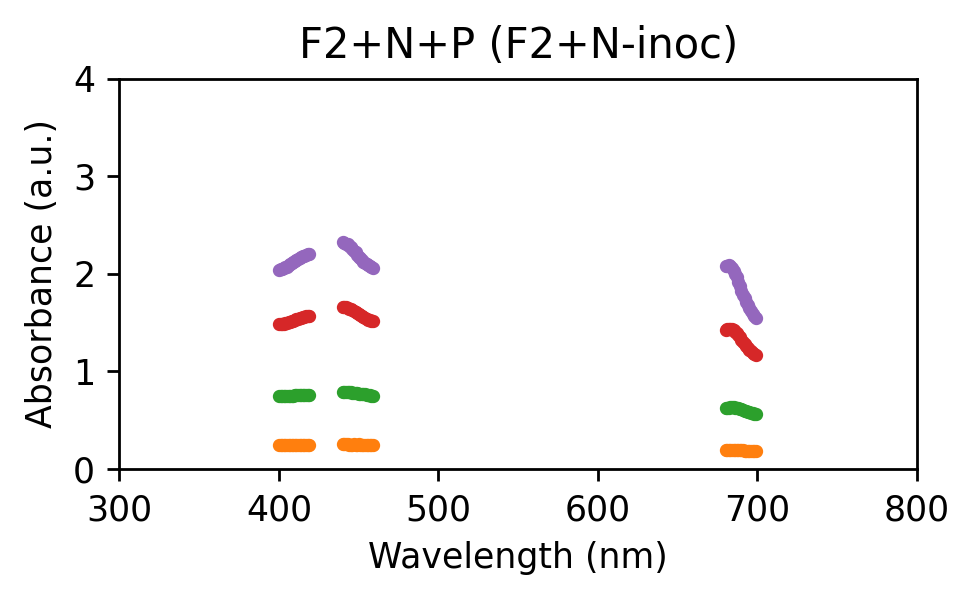

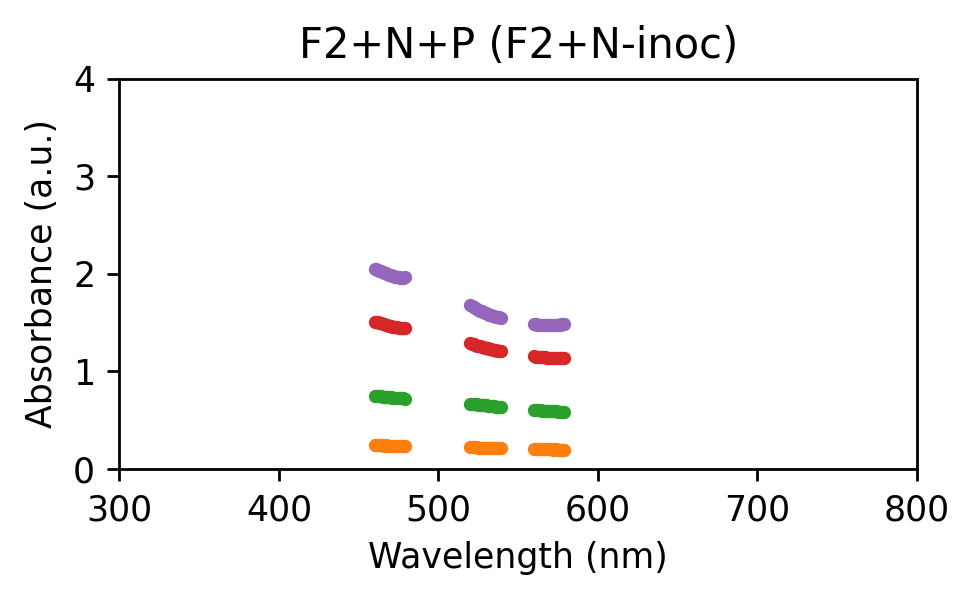

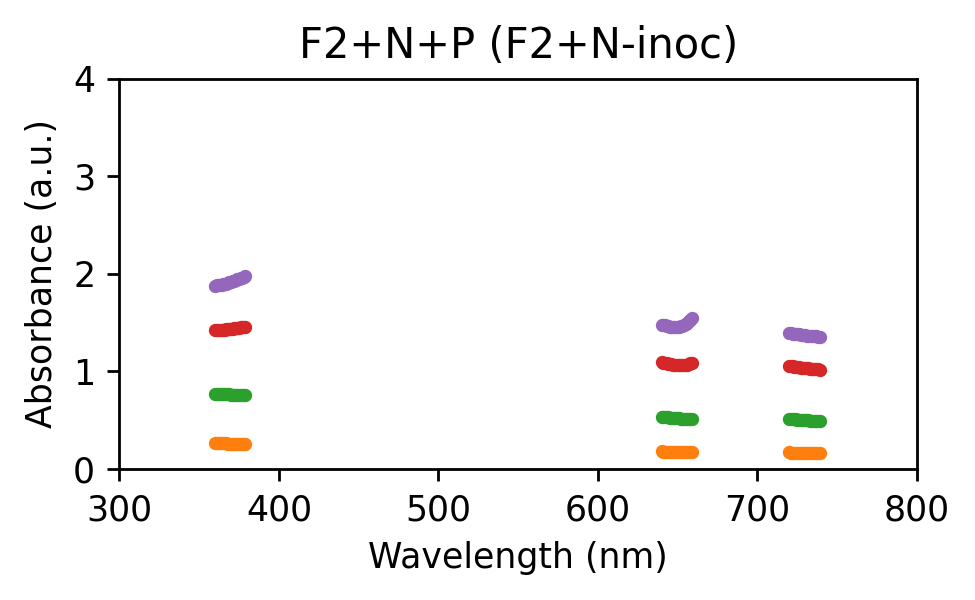

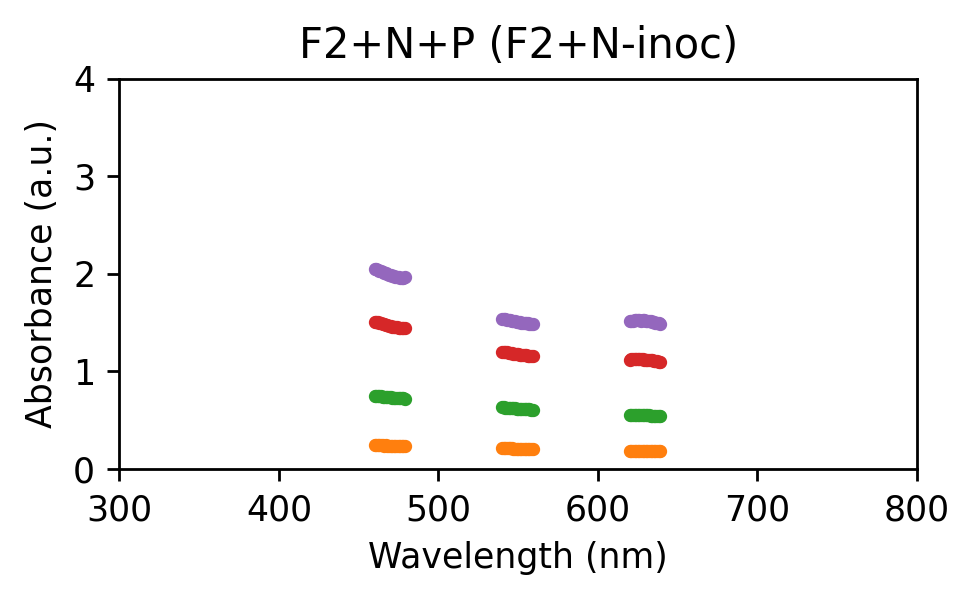

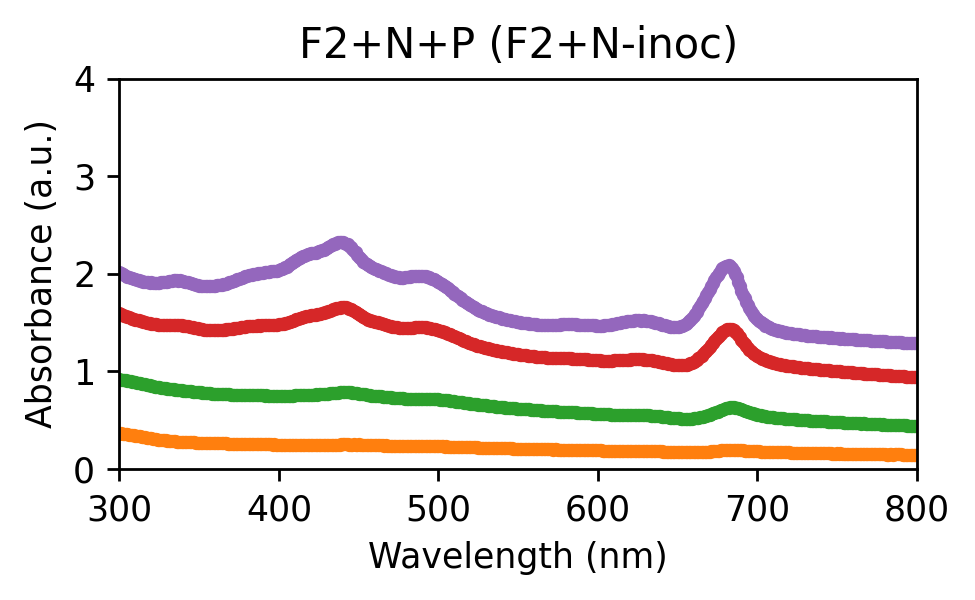

In [9]:
# Generate random windows

window_dict = {}
counter = {}

import itertools,random

# 2 windows in EEM
w2 = EEM_squaredwindowgenerator(size=25, overlap=0.5, numberofwindows=3, desired_length=50)


# Groups of 3 emission scans(low cost tools read like this)
w3 = fluoro1Dgen(fluorowaves,moving_excitation=True,window_size=3,random_selection=3,
                                    wave_interval= range(250,790,5),desired_length=50)

wfinal = w2 + w3
random.shuffle(wfinal)
add_windows(wfinal, "Rand")


assays = ['F2+N+P (F2+N-inoc)']
days = [9]

for window in window_dict.keys():
    
    # Pre-process pipeline with just a step of variable selection
    varsel = waveRestrictor2(window_dict = window_dict, window = window)
    
    X_transf = varsel.fit_transform(fluorodata)
    plot_meanpartialspectrum(fluorodata, X_transf,days,assays,sampleinfo,
                             contours = 1,
                             log=1)


window_dict = {}
counter = {}

w1 = movingwindow_forAbs(absdata,
                         window_size=20,
                              step_size=20,
                              window_no=3)

from spectrum_plotter import plotmeanAbsSpecs

add_windows(w1, "MW1abs_")
add_windows([abswaves], "absall_")

days = [1,3,5,7,9]

for window in window_dict.keys():
    
    # Pre-process pipeline with just a step of variable selection
    varsel = waveRestrictor2(window_dict = window_dict, window = window)
    X_transf = varsel.fit_transform(absdata)
    plotmeanAbsSpecs(assays, 'Assay',
                     days,
                     window_dict[window],
                     X_transf,ymax=4,dataindex= True,legend=False) 
    


This functions will be integrated in the machine learning methodology
[LearningFromSpec_part3](LearningFromSpec_part3.ipynb)